IDEAT: Vix takas? Joku momentum indikaattori? Sentimentti?




##Model settings

In [1]:
use_regime_split = False

#Default modelsD
RF = True # perus random forest
RF2 = False
GB = False # perus gradient boost
Hybrid = False

#Looping models
RF_feature_seek = False
seek_all = False
gb_loop = False

#DATA
FF5 = False
FF5_long = False
MSCI = False
Alueet = True

RSI = False
#3kk MA
MA3 = False
#12kk MA - latest month
MA12 = True

local = False #ajetaanko colab vai oma kone

compute_pdp = True   # <-- set to False if you want to skip PDP entirely




In [2]:
# Identify active model flags
active_modes = [name for name, flag in zip(
    ['RF', 'GB', 'RF_feature_seek', 'Hybrid', 'seek_all', 'gb_loop'],
    [RF, GB, RF_feature_seek, Hybrid, seek_all, gb_loop]
) if flag]

if active_modes:
    print("✅ Active model modes:", ", ".join(active_modes))
else:
    print("⚠️ No active model mode selected.")

# Check dataset toggles: exactly one must be True
datasets = {
    'FF5': FF5,
    'FF5_long': FF5_long,
    'MSCI': MSCI,
    'Alueet': Alueet
}
active_datasets = [name for name, flag in datasets.items() if flag]

if len(active_datasets) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")
else:
    print(f"📊 Using dataset: {active_datasets[0]}")


✅ Active model modes: RF
📊 Using dataset: Alueet


In [3]:
# # Import Required Libraries
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [4]:
# Use only the filename if the file is in the same folder as your script
xls_path = "Työ_Data.xlsx"

# Load the Excel file
xls_file = pd.ExcelFile(xls_path)

# (Optional) Check available sheet names
print(xls_file.sheet_names)


['Returns >', 'MSCI', 'Alueet', 'RSI', 'Bonds', 'MSCI_uus', 'FF5', 'FF5_long', 'Features >', 'Feature_data', 'Used_features', 'Ajodata >', 'ajodata_alueet', 'ajodata_bonds', 'ajodata_US', 'ajodata_FF5', 'ajodata_FF5_long', 'ajodata_MSCI', 'ajodata_MSCI_2', 'Grave yard >', 'Sheet2', 'ajodata', 'Cape', 'Sheet1', 'HV']


In [5]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [6]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [7]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI_2"
  FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'VIX']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

In [8]:
if Alueet:
  SHEET_NAME = "ajodata_alueet"
  FEATURES = ['CESIUSD', 'CESIEM', 'CESIEUR', 'CESIAPAC', 'VIX', 'DGS10',
  #'CSIIAPAC', 'CSIIEM', 'CSIIUSD', 'CSIIEUR'
]

  FACTORS = ['USA', 'EM', 'Europe', 'APAC']
  BENCHMARK = ['ACWI']
  show_benchmark = True

##Prepare data

In [9]:
df = xls_file.parse(SHEET_NAME)
df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_alueet' sheet:
Index(['Date', 'ACWI', 'USA', 'EM', 'Europe', 'APAC', 'CESIUSD', 'CESIEM',
       'CESIEUR', 'CESIAPAC', 'US_PE', 'EM_PE', 'EUR_PE', 'APAC_PE', 'VIX',
       'DGS10', 'DXY', 'USA_EPS', 'EM_EPS', 'EUR_EPS', 'APAC_EPS', 'EUR',
       'YEN', 'EM Currency Index', 'CSIIAPAC', 'CSIIUSD', 'CSIIEUR', 'CSIIEM',
       'CESIUSD-CESIEUR', 'CESIEM-CESIAPAC'],
      dtype='object')


In [10]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) RSI FEATURE ENGINEERING
# ──────────────────────────────────────────────────────────────────────────────
if RSI:
    raw          = xls_file.parse("RSI", header=None)
    RSI_WINDOW   = 14
    RSI_FEATURES = []

    # --- locate factor‑header row ------------------------------------------------
    factor_header_idx = next(
        i for i,row in raw.iterrows()
        if set(FACTORS).issubset({str(v).strip() for v in row if pd.notna(v)})
    )
    header_factors = raw.iloc[factor_header_idx].astype(str).str.strip()

    # --- locate “DATES” header row ----------------------------------------------
    date_header_idx = next(
        i for i,row in raw.iterrows()
        if any(str(v).strip().lower()=="dates" for v in row if pd.notna(v))
    )
    header_date = raw.iloc[date_header_idx].astype(str).str.strip()

    # --- pick correct DATES column ----------------------------------------------
    date_cols      = [j for j,val in enumerate(header_date) if val.lower()=="dates"]
    first_data_idx = max(factor_header_idx, date_header_idx) + 1
    valid_dates = [
        j for j in date_cols
        if pd.notna(pd.to_datetime(raw.iat[first_data_idx, j], dayfirst=True, errors="coerce"))
    ]
    date_col = valid_dates[0] if len(valid_dates)==1 else date_cols[0]

    # --- map each factor to its numeric column ----------------------------------
    col_pos = {}
    for f in FACTORS:
        matches = [j for j,val in enumerate(header_factors) if val==f]
        if len(matches) > 1:
            nums = [
                j for j in matches
                if pd.notna(pd.to_numeric(raw.iat[factor_header_idx+1, j], errors="coerce"))
            ]
            col_pos[f] = nums[0] if len(nums)==1 else matches[0]
        else:
            col_pos[f] = matches[0]

    # --- build daily frame -------------------------------------------------------
    data = raw.iloc[factor_header_idx+1 :].reset_index(drop=True)
    daily = pd.DataFrame({
        "Date": pd.to_datetime(data.iloc[:, date_col], dayfirst=True),
        **{ f: pd.to_numeric(data.iloc[:, col_pos[f]], errors="coerce") for f in FACTORS }
    }).set_index("Date").sort_index()

    # --- Wilder RSI helper -------------------------------------------------------
    def calc_rsi(x: pd.Series, window:int=RSI_WINDOW) -> pd.Series:
        d   = x.diff()
        up  = d.clip(lower=0)
        dn  = -d.clip(upper=0)
        aup = up.ewm(alpha=1/window, min_periods=window).mean()
        adn = dn.ewm(alpha=1/window, min_periods=window).mean()
        rs  = aup / adn
        return 100 - 100/(1+rs)

    # --- compute daily RSI columns ----------------------------------------------
    for f in FACTORS:
        c = f + "_RSI"
        daily[c] = calc_rsi(daily[f])
        RSI_FEATURES.append(c)

    # --- resample to month‑end ---------------------------------------------------
    rsi_monthly = (
        daily[RSI_FEATURES]
        .resample("M").last()
        .rename_axis("Date")
        .reset_index()
    )

    # --- merge into main df ------------------------------------------------------
    df = df.merge(rsi_monthly, on="Date", how="left")
    FEATURES += RSI_FEATURES
    print("✨ Added RSI features:", RSI_FEATURES)

    # ★ 1b) —— FILL ANY REMAINING RSI GAPS so later dropna() treats both
    #        pipelines identically.
    df[RSI_FEATURES] = df[RSI_FEATURES].ffill().bfill()
    print("🩹 Forward/back‑filled remaining RSI gaps")

# ──────────────────────────────────────────────────────────────────────────────
# 2) MOVING‑AVERAGE FEATURES
# ──────────────────────────────────────────────────────────────────────────────
if MA12:
    for f in FACTORS:
        df[f + '_MA12'] = (
            df[f].shift(1).rolling(window=12, min_periods=12).mean()
        )
    FEATURES += [f + '_MA12' for f in FACTORS]
    print("✨ Added lagged 12‑month MA:", [f + '_MA12' for f in FACTORS])

if MA3:
    for f in FACTORS:
        df[f + '_MA3'] = (
            df[f].shift(1).rolling(window=3, min_periods=3).mean()
        )
    FEATURES += [f + '_MA3' for f in FACTORS]
    print("✨ Added lagged 3‑month MA:", [f + '_MA3' for f in FACTORS])

print("🧩 New FEATURES list:", FEATURES)

# ──────────────────────────────────────────────────────────────────────────────
# 3) TRIM TO FIRST FULLY‑VALID ROW
# ──────────────────────────────────────────────────────────────────────────────
valid_mask       = df[FEATURES].notna().all(axis=1)
first_valid_idx  = valid_mask.idxmax()
first_valid_date = df.loc[first_valid_idx, "Date"]

df = df[df["Date"] >= first_valid_date].reset_index(drop=True)
print(f"🗓  Trimmed data to start on {first_valid_date.date()} (first full‑feature row)")

# ──────────────────────────────────────────────────────────────────────────────
# 4) DROP ROWS WITH ANY REMAINING FEATURE NaNs
# ──────────────────────────────────────────────────────────────────────────────
if True:          # drop_empty toggle
    before = len(df)
    df.dropna(subset=FEATURES, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"✂️  Dropped {before - len(df)} rows with missing FEATURES")

# ──────────────────────────────────────────────────────────────────────────────
# 5) DEFINE TARGET VARIABLE
# ──────────────────────────────────────────────────────────────────────────────
df['Winning Factor']      = df[FACTORS].idxmax(axis=1).astype('category')
df['Winning Factor Code'] = df['Winning Factor'].cat.codes

print(f"✅ Final data from {df['Date'].iloc[0].date()} to {df['Date'].iloc[-1].date()}, {len(df)} rows")
print("Target distribution:\n", df['Winning Factor'].value_counts())


✨ Added lagged 12‑month MA: ['USA_MA12', 'EM_MA12', 'Europe_MA12', 'APAC_MA12']
🧩 New FEATURES list: ['CESIUSD', 'CESIEM', 'CESIEUR', 'CESIAPAC', 'VIX', 'DGS10', 'USA_MA12', 'EM_MA12', 'Europe_MA12', 'APAC_MA12']
🗓  Trimmed data to start on 2006-08-31 (first full‑feature row)
✂️  Dropped 0 rows with missing FEATURES
✅ Final data from 2006-08-31 to 2025-05-31, 226 rows
Target distribution:
 Winning Factor
USA       81
EM        65
Europe    50
APAC      30
Name: count, dtype: int64


In [11]:
df

Date      ACWI       USA        EM    Europe      APAC  CESIUSD  \
0   2006-08-31  0.021438  0.019383  0.020553  0.025298  0.018070     -7.6   
1   2006-09-30  0.019045  0.033042  0.015164  0.018526  0.003282    -39.2   
2   2006-10-31  0.030043  0.026350  0.039735  0.034451  0.022495    -52.6   
3   2006-11-30 -0.011073 -0.019864  0.033961 -0.005186 -0.006793    -54.9   
4   2006-12-31  0.026609  0.015726  0.049350  0.037224  0.035966     22.0   
..         ...       ...       ...       ...       ...       ...      ...   
221 2025-01-31  0.025895  0.022614  0.009708  0.064104  0.006712     12.4   
222 2025-02-28 -0.004812 -0.014731  0.005777  0.034796 -0.001724    -16.5   
223 2025-03-31 -0.078270 -0.095809 -0.034750 -0.043569 -0.045308     -4.4   
224 2025-04-30 -0.040557 -0.053567 -0.038013 -0.013582 -0.023111     -8.6   
225 2025-05-31  0.055694  0.063705  0.040535  0.039211  0.046022     11.5   

     CESIEM  CESIEUR  CESIAPAC  ...  CSIIEUR  CSIIEM  CESIUSD-CESIEUR  \
0      24.9    -40.4      36.7  ...     4.89   -7.67             32.8   
1      13.9    -42.1      21.6  ...     9.50   -5.94              2.9   
2       9.6     33.5      10.7  ...    -4.37   -2.60            -86.1   
3       8.6     45.5       0.6  ...    -3.67  -12.25           -100.4   
4       5.6     42.0      -5.7  ...    -8.21  -12.23            -20.0   
..      ...      ...       ...  ...      ...     ...              ...   
221     3.7     -0.6       6.1  ...     5.37  -20.84             13.0   
222     5.0     22.9      11.9  ...    10.32  -18.54            -39.4   
223     8.0     18.4      22.9  ...    15.44  -20.91            -22.8   
224    18.8    -15.7      35.1  ...    12.99  -21.76              7.1   
225    39.0     17.7      63.0  ...     7.28  -17.78             -6.2   

     CESIEM-CESIAPAC  USA_MA12   EM_MA12  Europe_MA12  APAC_MA12  \
0              -11.8 -0.001195  0.016809     0.010787   0.015152   
1               -7.7  0.002733  0.019408     0.012952   0.015617   
2               -1.1  0.002757  0.010810     0.010809   0.006864   
3                8.0  0.006107  0.019368     0.015818   0.011248   
4               11.3 -0.000158  0.013849     0.012834   0.005154   
..               ...       ...       ...          ...        ...   
221             -2.4  0.023821  0.010104     0.004841   0.011619   
222             -6.9  0.022813  0.013249     0.008917   0.011975   
223            -14.9  0.016843  0.009472     0.010324   0.008220   
224            -16.3  0.006273  0.004672     0.003752   0.002456   
225            -24.0  0.004437  0.000424     0.003828   0.000920   

     Winning Factor  Winning Factor Code  
0            Europe                    2  
1               USA                    3  
2                EM                    1  
3                EM                    1  
4                EM                    1  
..              ...                  ...  
221          Europe                    2  
222          Europe                    2  
223              EM                    1  
224          Europe                    2  
225             USA                    3  

[226 rows x 36 columns]

In [12]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# ------------------------------------------------------------
# 1.  Inputs
# ------------------------------------------------------------
# df      : DataFrame of monthly total-return series (index = month-end dates)
# FACTORS : list/tuple of column names in df you want analysed
#
# Example:
# df       = pd.read_csv("monthly_returns.csv", parse_dates=["Date"]).set_index("Date")
# FACTORS  = ["Value", "Momentum", "Quality", "LowVol"]
# ------------------------------------------------------------

# ---------- Helper functions ----------
def annualized_return(returns: pd.Series) -> float:
    """Compounded annualised return from monthly series."""
    return (1 + returns).prod() ** (12 / len(returns)) - 1

def compute_metrics(returns: pd.Series) -> tuple[float, float, float]:
    """Annualised return, annualised volatility, and cumulative return."""
    ann_ret = annualized_return(returns)
    ann_vol = returns.std() * np.sqrt(12)          # monthly → annual
    cum_ret = (1 + returns).prod() - 1
    return ann_ret, ann_vol, cum_ret

# ---------- Win-rate (highest-return months, factors only) ----------
monthly_winner = df[FACTORS].idxmax(axis=1)        # winner each month (benchmark excluded)
win_rates = (
    monthly_winner.value_counts()                  # how many wins per factor
    .reindex(FACTORS, fill_value=0) / len(df)      # re-index ensures original order
)

# ---------- Number-format helper (space as thousands separator) ----------
NBSP = "\u202F"                                    # thin non-breaking space renders well in HTML

def pct_with_space(x: float) -> str:
    """Format a decimal as percentage with 1-dp and thin-space thousands separator."""
    return f"{x * 100:,.1f}%".replace(",", NBSP)

# ---------- Build the summary table ----------
records = []
for col in FACTORS:
    r = df[col]
    ann_ret, ann_vol, cum_ret = compute_metrics(r)
    records.append({
        "Factor":                   col,
        "Annualised Return":        pct_with_space(ann_ret),
        "Annualised Volatility":    pct_with_space(ann_vol),
        "Total Cumulative Return":  pct_with_space(cum_ret),
        "Win rate":                 pct_with_space(win_rates[col]),
    })

metrics_df = pd.DataFrame(records)

# ---------- Display ----------
display(HTML(metrics_df.to_html(index=False)))

In [13]:
# Toggle for dropping rows with missing values in the FEATURES columns.
drop_empty = True

# 1) Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# 2) Show missing‐value counts in FEATURES.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in FEATURES before cleaning:")
print(missing_counts)

# 3) Drop any rows with NA in FEATURES, if requested.
if drop_empty:
    before = len(df)
    df.dropna(subset=FEATURES, inplace=True)
    df.reset_index(drop=True, inplace=True)
    dropped = before - len(df)
    print(f"\nDropped {dropped} rows due to missing FEATURES.")
else:
    print("\nKeeping all rows, including those with missing FEATURES.")

# 4) Re‐check that FEATURES are now complete:
print("\nMissing values in FEATURES after cleaning:")
print(df[FEATURES].isna().sum())

# 5) Compute your target column in‐place.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1).astype('category')

# 6) (Optionally) create a numeric code column
df['Winning Factor Code'] = df['Winning Factor'].cat.codes

# 7) Quick summary:
print(f"\nFinal dataset now has {len(df)} rows.")
print("Target value counts:")
print(df['Winning Factor'].value_counts())

Total number of rows before cleaning: 226

Missing values in FEATURES before cleaning:
CESIUSD        0
CESIEM         0
CESIEUR        0
CESIAPAC       0
VIX            0
DGS10          0
USA_MA12       0
EM_MA12        0
Europe_MA12    0
APAC_MA12      0
dtype: int64

Dropped 0 rows due to missing FEATURES.

Missing values in FEATURES after cleaning:
CESIUSD        0
CESIEM         0
CESIEUR        0
CESIAPAC       0
VIX            0
DGS10          0
USA_MA12       0
EM_MA12        0
Europe_MA12    0
APAC_MA12      0
dtype: int64

Final dataset now has 226 rows.
Target value counts:
Winning Factor
USA       81
EM        65
Europe    50
APAC      30
Name: count, dtype: int64


In [14]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Models

##Feature seek

In [15]:
if RF_feature_seek:
    import itertools
    import os
    import time
    from collections import OrderedDict

    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    ###############################  PARAMETERS  #################################
    # data‐selection
    min_months_train        = 60
    min_obs_regime          = 50
    min_obs_train           = 0
    use_regime_split        = False
    default_hyperparameters = False

    # window & parallelism
    use_fixed_window    = True
    rolling_window_size = 60   # months
    n_jobs              = -1

    # extras (placeholders—you can implement below)
    compute_permutation_importance = True
    compute_shap                    = True
    ##############################################################################

    ###########################  MODEL HYPER-PARAMS  #############################
    rf_params = (
        dict(
            n_estimators      = 100,
            max_depth         = None,
            max_features      = "sqrt",
            min_samples_split = 2,
            min_samples_leaf  = 1,
            bootstrap         = True,
            n_jobs            = n_jobs
        ) if default_hyperparameters else
        dict(
            n_estimators      = 100,
            max_depth         = 7,
            max_features      = 10,
            min_samples_split = 2,
            min_samples_leaf  = 3,
            bootstrap         = False,
            n_jobs            = n_jobs
        )
    )
    ##############################################################################

    # --------------------------
    # Feature grouping (always together)
    # --------------------------
    GROUPS = OrderedDict({
        'CESI':  ['CESIUSD','CESIEM','CESIEUR','CESIAPAC'],
        'MA12':  ['USA_MA12','EM_MA12','Europe_MA12','APAC_MA12'],
        'MA3':   ['USA_MA3','EM_MA3','Europe_MA3','APAC_MA3'],
        'RSI':   ['USA_RSI','EM_RSI','Europe_RSI','APAC_RSI'],
        'CSII':  ['CSIIAPAC', 'CSIIEM', 'CSIIUSD', 'CSIIEUR']
    })

    def is_valid_comb(comb):
        """Return True if for every group, comb includes either all or none of its features."""
        comb_set = set(comb)
        for group_feats in GROUPS.values():
            intersect = comb_set & set(group_feats)
            if intersect and not set(group_feats).issubset(comb_set):
                return False
        return True

    # --------------------------
    # Parameters for Feature & Training Window Search
    # --------------------------
    min_features = 4                    # minimum features in a subset
    max_features = len(FEATURES)        # maximum features
    min_obs_for_prediction = min_months_train

    output_filename = "strategy_cumulative_returns.csv"
    if os.path.exists(output_filename):
        os.remove(output_filename)

    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # ----------------------------------------------------------------
    # Helper to write one‐row summary (compounded return) to CSV
    # ----------------------------------------------------------------
    def write_summary(year_label, feature_list, cum_return):
        df_row = pd.DataFrame([{
            "TrainingWindow": year_label,
            "Features_used": str(feature_list),
            "Cumulative_Return": cum_return
        }])
        header = not os.path.exists(output_filename)
        df_row.to_csv(output_filename, mode='a', header=header, index=False)

    # --------------------------
    # Fixed Rolling Windows
    # --------------------------
    training_window_years = [rolling_window_size // 12]  # e.g. 60 months → 5 years
    for years in training_window_years:
        window_size = years * 12
        start_idx = max(min_obs_for_prediction, window_size)
        print(f"\n--- Fixed {years}y window (start at idx {start_idx}) ---")

        for r in range(min_features, max_features + 1):
            all_combs = list(itertools.combinations(FEATURES, r))
            valid_combs = [c for c in all_combs if is_valid_comb(c)]
            total = len(valid_combs)
            print(f"  Size {r}: {total} strategies")

            for idx, comb in enumerate(valid_combs, 1):
                feats = list(comb)
                start = time.time()
                rets = []

                for i in range(start_idx, len(df_sorted)):
                    test = df_sorted.iloc[i]
                    train = df_sorted.iloc[i-window_size:i].copy()
                    last_date = train['Date'].iloc[-1]
                    if (last_date.year == test['Date'].year and
                        last_date.month >= test['Date'].month):
                        continue

                    # regime‐based filtering
                    if use_regime_split:
                        rc = train[REGIMES_COLUMN].value_counts()
                        if any(rc < min_obs_regime):
                            continue
                        regime = test[REGIMES_COLUMN]
                        train = train[train[REGIMES_COLUMN] == regime]
                        if len(train) < min_obs_regime:
                            continue

                    X = train[feats].dropna()
                    if X.empty:
                        continue
                    y = train['Winning Factor'].loc[X.index]

                    # —— use your chosen hyperparameters here ——
                    model = RandomForestClassifier(**rf_params, random_state=42)
                    model.fit(X, y)

                    X_test = X.iloc[[-1]]
                    if X_test.empty:
                        continue

                    prob = model.predict_proba(X_test)[0]
                    full_p = np.zeros(len(FACTORS))
                    for cls, p in zip(model.classes_, prob):
                        try:
                            full_p[FACTORS.index(cls)] = p
                        except ValueError:
                            pass
                    alloc = (full_p * test[FACTORS].values).sum()
                    rets.append(alloc)

                # compound monthly returns
                cum = np.prod([1 + r for r in rets]) - 1 if rets else np.nan
                write_summary(years, feats, cum)

                dt = time.time() - start
                m, s = divmod(int(dt), 60)
                rem = total - idx
                print(f"    [{idx}/{total}] {m:02d}:{s:02d} → cum_ret={cum:.2%}, {rem} left")

    # --------------------------
    # (Optional) Expanding Window
    # --------------------------
    if run_expanding_window:
        print("\n--- Expanding Window ---")
        for r in range(min_features, max_features + 1):
            all_combs = list(itertools.combinations(FEATURES, r))
            valid_combs = [c for c in all_combs if is_valid_comb(c)]
            total = len(valid_combs)
            print(f"  Size {r}: {total} strategies")

            for idx, comb in enumerate(valid_combs, 1):
                feats = list(comb)
                start = time.time()
                rets = []

                for i in range(min_obs_for_prediction, len(df_sorted)):
                    test = df_sorted.iloc[i]
                    train = df_sorted.iloc[:i].copy()
                    last_date = train['Date'].iloc[-1]
                    if (last_date.year == test['Date'].year and
                        last_date.month >= test['Date'].month):
                        continue

                    X = train[feats].dropna()
                    if X.empty:
                        continue
                    y = train['Winning Factor'].loc[X.index]

                    model = RandomForestClassifier(**rf_params, random_state=42)
                    model.fit(X, y)

                    X_test = X.iloc[[-1]]
                    if X_test.empty:
                        continue

                    prob = model.predict_proba(X_test)[0]
                    full_p = np.zeros(len(FACTORS))
                    for cls, p in zip(model.classes_, prob):
                        try:
                            full_p[FACTORS.index(cls)] = p
                        except ValueError:
                            pass
                    alloc = (full_p * test[FACTORS].values).sum()
                    rets.append(alloc)

                cum = np.prod([1 + r for r in rets]) - 1 if rets else np.nan
                write_summary("expanding", feats, cum)

                dt = time.time() - start
                m, s = divmod(int(dt), 60)
                rem = total - idx
                print(f"    [{idx}/{total}] {m:02d}:{s:02d} → cum_ret={cum:.2%}, {rem} left")

    print(f"\nResults written to {output_filename}")


##Seek all

In [16]:
if seek_all:
    import pandas as pd
    import numpy as np
    import time
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import ParameterGrid

    # ───────────────────────────────────────
    # 1) User‐defined feature combinations
    # ───────────────────────────────────────
    feature_combinations = [
        ['CESIUSD', 'CESIEM', 'CESIEUR', 'CESIAPAC', 'VIX', 'DGS10', 'DXY',
         'USA_RSI', 'EM_RSI', 'Europe_RSI', 'APAC_RSI',
         'USA_MA12', 'EM_MA12', 'Europe_MA12', 'APAC_MA12'],
        # add more combos here...
    ]
    n_feature_sets = len(feature_combinations)
    print(f"Total feature‐sets provided: {n_feature_sets}")

    # ───────────────────────────────────────
    # 2) RF hyperparameter grid (excluding max_features)
    # ───────────────────────────────────────
    param_grid_template = {
        'n_estimators':      [100],
        'max_depth':         [7],
        'min_samples_split': [2],
        'min_samples_leaf':  [3],
        'bootstrap':         [False],
        'n_jobs':            [-1]
    }
    base_param_list = list(ParameterGrid(param_grid_template))

    # ───────────────────────────────────────
    # 3) Compute total iterations & report
    # ───────────────────────────────────────
    total_iterations = n_feature_sets * len(base_param_list)
    print(f"Total RF iterations to run: {total_iterations}\n")

    # ───────────────────────────────────────
    # 4) Rolling‐window settings
    # ───────────────────────────────────────
    rolling_window_size = 60   # months
    min_months_train    = 60   # months
    use_fixed_window    = True # False ⇒ expanding

    # ───────────────────────────────────────
    # 5) Loop & collect summaries
    # ───────────────────────────────────────
    iteration = 0
    summary_records = []

    for feat_set in feature_combinations:
        n_feats = len(feat_set)
        # use the base parameter list without varying max_features
        param_list = base_param_list

        for rf_params in param_list:
            iteration += 1
            tic = time.perf_counter()

            print(f"Iteration {iteration}/{total_iterations}:")
            print(f"  Features ({n_feats}): {feat_set}")
            print(f"  RF params: {rf_params}")

            # drop missing
            df_iter = df.dropna(subset=feat_set).copy()
            df_sorted = df_iter.sort_values('Date').reset_index(drop=True)
            rets = []
            eq_rets = []

            for i in range(1, len(df_sorted)):
                test_row = df_sorted.iloc[i]
                # training window
                if use_fixed_window:
                    start_i = max(0, i - rolling_window_size)
                    train = df_sorted.iloc[start_i:i]
                else:
                    train = df_sorted.iloc[:i]
                if len(train) < min_months_train:
                    continue

                X_train = train[feat_set].dropna()
                if X_train.empty:
                    continue
                y_train = train['Winning Factor'].loc[X_train.index]

                rf = RandomForestClassifier(**rf_params, random_state=42)
                rf.fit(X_train, y_train)

                X_test = train[feat_set].iloc[[-1]].dropna()
                if X_test.empty:
                    continue

                probs = rf.predict_proba(X_test)[0]
                full_p = np.zeros(len(FACTORS))
                for cls, p in zip(rf.classes_, probs):
                    full_p[FACTORS.index(cls)] = p

                alloc_ret = (full_p * test_row[FACTORS].values).sum()
                eq_ret    = test_row[FACTORS].mean()
                rets.append(alloc_ret)
                eq_rets.append(eq_ret)

            # build summary for this run
            dates = df_sorted['Date'].iloc[1:1+len(rets)]
            if rets:
                df_res = pd.DataFrame({
                    'Date': dates,
                    'Allocated_Return': rets,
                    'Equal_Weight_Return': eq_rets
                }).sort_values('Date')

                post2k = df_res[df_res['Date'] >= pd.Timestamp("2000-01-01")]
                cum_alloc_2k  = (1 + post2k['Allocated_Return']).prod() - 1
                cum_eq_2k     = (1 + post2k['Equal_Weight_Return']).prod() - 1
                cum_alloc_tot = (1 + df_res['Allocated_Return']).prod() - 1
                cum_eq_tot    = (1 + df_res['Equal_Weight_Return']).prod()   - 1
                sharpe_2k     = (post2k['Allocated_Return'].mean() /
                                 post2k['Allocated_Return'].std()) * np.sqrt(12)
                win2k         = (post2k['Allocated_Return'] >
                                 post2k['Equal_Weight_Return']).sum()

                summary = {
                    'Iteration':           iteration,
                    'Features':            ",".join(feat_set),
                    'Hyperparameters':     ";".join(f"{k}={v}" for k,v in rf_params.items()),
                    'Num_Preds':           len(df_res),
                    'First_Pred':          df_res['Date'].iloc[0].strftime("%Y-%m-%d"),
                    'Last_Pred':           df_res['Date'].iloc[-1].strftime("%Y-%m-%d"),
                    'CumAlloc_Post2000':   cum_alloc_2k,
                    'CumEqual_Post2000':   cum_eq_2k,
                    'CumAlloc_Total':      cum_alloc_tot,
                    'CumEqual_Total':      cum_eq_tot,
                    'Sharpe_Post2000':     sharpe_2k,
                    'Win_Count_Post2000':  win2k
                }
            else:
                # no predictions made
                summary = {
                    'Iteration':           iteration,
                    'Features':            ",".join(feat_set),
                    'Hyperparameters':     ";".join(f"{k}={v}" for k,v in rf_params.items()),
                    'Num_Preds':           0,
                    **{k: np.nan for k in [
                        'First_Pred','Last_Pred',
                        'CumAlloc_Post2000','CumEqual_Post2000',
                        'CumAlloc_Total','CumEqual_Total',
                        'Sharpe_Post2000','Win_Count_Post2000'
                    ]}
                }

            summary_records.append(summary)

            toc = time.perf_counter()
            print(f"  → Done in {toc-tic:.1f}s\n")

    # ───────────────────────────────────────
    # 6) Write Excel with cumulative returns
    # ───────────────────────────────────────
    df_summary = pd.DataFrame(summary_records)
    excel_file = 'seek_all_cumulative_returns.xlsx'
    df_summary.to_excel(excel_file, index=False)
    print(f"All results saved to: {excel_file}")


## Random forest

###By feature plots

In [17]:
if RF:

    ###############################################################################
    # CELL A — Random-Forest rolling training / prediction (storing rf_models)
    ###############################################################################

    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance
    from IPython.display import display
    import shap

    # ---------------------------------------------------------------------------
    # Assumes these are already defined in your notebook:
    #   df, FEATURES, FACTORS, REGIMES_COLUMN, regime_short_mapping, BENCHMARK
    #   e.g. BENCHMARK = ['ACWI']
    # ---------------------------------------------------------------------------

    ###############################  PARAMETERS  #################################
    min_months_train        = 60
    min_obs_regime          = 50
    min_obs_train           = 0
    use_regime_split        = False
    default_hyperparameters = False

    use_fixed_window    = True
    rolling_window_size = 60
    n_jobs              = -1

    compute_permutation_importance = True
    compute_shap                    = True
    ##############################################################################

    ###########################  MODEL HYPER-PARAMS  #############################
    rf_params = (
        dict(
            n_estimators      = 100,
            max_depth         = None,
            max_features      = "sqrt",
            min_samples_split = 2,
            min_samples_leaf  = 1,
            bootstrap         = True,
            n_jobs            = n_jobs
        ) if default_hyperparameters else
        dict(
            n_estimators      = 100,
            max_depth         = 7,
            max_features      = 10,
            min_samples_split = 2,
            min_samples_leaf  = 3,
            bootstrap         = False,
            n_jobs            = n_jobs
        )
    )
    ##############################################################################

    ###########################  OPTIONAL CONTAINERS  ############################
    if compute_shap:
        shap_data = []

    if compute_permutation_importance:
        perm_importances_list: list[np.ndarray] = []
        months_list:            list[pd.Timestamp] = []
    ##############################################################################

    #############################  TRAINING LOOP  ################################
    df_sorted = df.sort_values("Date").reset_index(drop=True)

    results   = []      # one dict per “prediction step”
    rf_models = []      # store each fitted RandomForestClassifier

    for i in range(1, len(df_sorted) + 1):
        # 1) build training window
        train_window = (
            df_sorted.iloc[max(0, i - rolling_window_size):i].copy()
            if use_fixed_window else
            df_sorted.iloc[:i].copy()
        )
        if len(train_window) < min_months_train:
            continue

        train_start_date = train_window["Date"].iloc[0]
        train_end_date   = train_window["Date"].iloc[-1]

        # 2) regime split (optional)
        if use_regime_split:
            counts = train_window[REGIMES_COLUMN].value_counts()
            if any(counts < min_obs_regime):
                continue
            current_regime = df_sorted.iloc[min(i, len(df_sorted)-1)][REGIMES_COLUMN]
            train_window   = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = "NoRegime"

        # 3) prepare X/y
        X_train = train_window[FEATURES].dropna()
        y_train = train_window.loc[X_train.index, "Winning Factor"]
        if len(X_train) < min_obs_train:
            continue

        # 4) fit RF
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_models.append(rf_model)

        # 5) permutation importance
        if compute_permutation_importance and i < len(df_sorted):
            pi = permutation_importance(
                rf_model, X_train, y_train,
                n_repeats    = 10,
                random_state = 42,
                n_jobs       = n_jobs
            )
            perm_importances_list.append(pi.importances_mean)
            months_list.append(train_end_date)

        # 6) pick row to predict
        future_row = (i == len(df_sorted))
        X_test_src, Predicted_month = (
            (df_sorted.iloc[[-1]],
            df_sorted["Date"].iloc[-1] + pd.offsets.MonthEnd(1))
            if future_row else
            (train_window.iloc[[-1]], df_sorted.iloc[i]["Date"])
        )
        X_test = X_test_src[FEATURES].dropna()
        if X_test.empty:
            continue

        # 7) SHAP snapshot (optional)
        if compute_shap:
            try:
                explainer = shap.Explainer(rf_model, X_train)
                vals      = explainer(X_test).values
            except Exception:
                explainer = shap.TreeExplainer(rf_model)
                sv_list   = explainer.shap_values(X_test)
                vals      = (np.stack(sv_list, axis=-1)[0]
                            if isinstance(sv_list, list) else sv_list)

            shap_mat = (
                vals[0].T if vals.ndim == 3 else
                (vals.T if vals.shape[0] == len(FEATURES) else
                np.tile(vals, (len(FACTORS), 1)))
            )
            shap_data.append({
                "month":        Predicted_month,
                "feature_vals": X_test.iloc[0].values,
                "shap_values":  shap_mat
            })

        # 8) prediction & single-period returns
        probs  = rf_model.predict_proba(X_test)[0]
        winner = rf_model.classes_[probs.argmax()]
        full_p = np.zeros(len(FACTORS))
        for cls, p in zip(rf_model.classes_, probs):
            if cls in FACTORS:
                full_p[FACTORS.index(cls)] = p

        if future_row:
            allocated_return = equal_ret = bench_return = actual_winner = np.nan
            months_ahead = 1
        else:
            row           = df_sorted.iloc[i]
            allocated_return = (full_p * row[FACTORS].values).sum()
            equal_ret        = row[FACTORS].mean()
            bench_return     = row[BENCHMARK[0]]
            actual_winner    = row["Winning Factor"]
            months_ahead     = (
                (Predicted_month.year  - train_end_date.year) * 12 +
                (Predicted_month.month - train_end_date.month)
            )

        feat_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        # 9) save one row of results
        results.append({
            "Regime":                     regime_used,
            "Predicted_month":            Predicted_month,
            "Train_Start_Date":           train_start_date,
            "Train_End_Date":             train_end_date,
            "Train_Count":                len(X_train),
            "Feature_Importances":        rf_model.feature_importances_,
            "Predicted_Probabilities":    full_p,
            "Predicted_Winner":           winner,
            "Allocated_Return":           allocated_return,
            "Equal_Weight_Return":        equal_ret,
            "Benchmark_Return":           bench_return,            # raw ACWI
            "Actual_Winner":              actual_winner,
            "Num_Trees":                  rf_model.n_estimators,
            "Average_Tree_Depth":         np.mean([t.tree_.max_depth for t in rf_model.estimators_]),
            "Max_Tree_Depth":             np.max([t.tree_.max_depth for t in rf_model.estimators_]),
            "Prediction_Horizon_Months":  months_ahead,
            **feat_levels
        })

        # 10) progress print
        print(
            f"Test row date: {Predicted_month.date()} → model trained, "
            f"prediction made ({train_start_date.date()} – {train_end_date.date()})"
        )

    ##########################  WRAP-UP / DISPLAY  ###############################
    results_df_rf = pd.DataFrame(results)
    results_df_rf = results_df_rf.sort_values("Predicted_month").reset_index(drop=True)

    # compute compounded cumulative series
    results_df_rf["Cumulative_Return"]              = (
        1 + results_df_rf["Allocated_Return"].fillna(0)
    ).cumprod() - 1

    results_df_rf["Equal_Weight_Cumulative_Return"] = (
        1 + results_df_rf["Equal_Weight_Return"].fillna(0)
    ).cumprod() - 1

    results_df_rf["Benchmark_Cumulative_Return"]    = (
        1 + results_df_rf["Benchmark_Return"].fillna(0)
    ).cumprod() - 1

    pd.set_option('display.max_columns', None)
    display(results_df_rf.tail(12))

    # quick summary of latest cumulative performance
    _last = results_df_rf.iloc[-1]
    print(
        f"\nLatest cumulative returns:\n"
        f"  Strategy:     {_last['Cumulative_Return']:.2%}\n"
        f"  Equal-Weight: {_last['Equal_Weight_Cumulative_Return']:.2%}\n"
        f"  {BENCHMARK[0]} Bench.: {_last['Benchmark_Cumulative_Return']:.2%}"
    )

Test row date: 2011-08-31 → model trained, prediction made (2006-08-31 – 2011-07-31)
Test row date: 2011-09-30 → model trained, prediction made (2006-09-30 – 2011-08-31)
Test row date: 2011-10-31 → model trained, prediction made (2006-10-31 – 2011-09-30)
Test row date: 2011-11-30 → model trained, prediction made (2006-11-30 – 2011-10-31)
Test row date: 2011-12-31 → model trained, prediction made (2006-12-31 – 2011-11-30)
Test row date: 2012-01-31 → model trained, prediction made (2007-01-31 – 2011-12-31)
Test row date: 2012-02-29 → model trained, prediction made (2007-02-28 – 2012-01-31)
Test row date: 2012-03-31 → model trained, prediction made (2007-03-31 – 2012-02-29)
Test row date: 2012-04-30 → model trained, prediction made (2007-04-30 – 2012-03-31)
Test row date: 2012-05-31 → model trained, prediction made (2007-05-31 – 2012-04-30)
Test row date: 2012-06-30 → model trained, prediction made (2007-06-30 – 2012-05-31)
Test row date: 2012-07-31 → model trained, prediction made (2007-

Regime Predicted_month Train_Start_Date Train_End_Date  Train_Count  \
155  NoRegime      2024-07-31       2019-07-31     2024-06-30           60   
156  NoRegime      2024-08-31       2019-08-31     2024-07-31           60   
157  NoRegime      2024-09-30       2019-09-30     2024-08-31           60   
158  NoRegime      2024-10-31       2019-10-31     2024-09-30           60   
159  NoRegime      2024-11-30       2019-11-30     2024-10-31           60   
160  NoRegime      2024-12-31       2019-12-31     2024-11-30           60   
161  NoRegime      2025-01-31       2020-01-31     2024-12-31           60   
162  NoRegime      2025-02-28       2020-02-29     2025-01-31           60   
163  NoRegime      2025-03-31       2020-03-31     2025-02-28           60   
164  NoRegime      2025-04-30       2020-04-30     2025-03-31           60   
165  NoRegime      2025-05-31       2020-05-31     2025-04-30           60   
166  NoRegime      2025-06-30       2020-06-30     2025-05-31           60   

                                   Feature_Importances  \
155  [0.05496075862771808, 0.023755433632824542, 0....   
156  [0.07110986065418788, 0.006839525961401013, 0....   
157  [0.08013305643448095, 0.041829894544725785, 0....   
158  [0.07297131414861362, 0.008455244911947199, 0....   
159  [0.06868550897969661, 0.028169751731215838, 0....   
160  [0.06034667473774472, 0.023448806774441885, 0....   
161  [0.06034667473774472, 0.023448806774441878, 0....   
162  [0.1465422666905011, 0.019755628208628254, 0.1...   
163  [0.17723841932223763, 0.01470148012639281, 0.2...   
164  [0.16242667107328743, 0.0, 0.14411563901077168...   
165  [0.16432620627508807, 0.0, 0.13656825770496542...   
166  [0.12177716014060333, 0.0010626992561105213, 0...   

                               Predicted_Probabilities Predicted_Winner  \
155  [0.0, 0.600000000000001, 0.39999999999999925, ...               EM   
156  [0.3333333333333329, 0.0, 0.3333333333333329, ...             APAC   
157  [0.0, 0.46666666666666695, 0.5333333333333331,...           Europe   
158  [0.0, 0.8533333333333336, 0.14666666666666675,...               EM   
159                               [1.0, 0.0, 0.0, 0.0]              USA   
160                               [1.0, 0.0, 0.0, 0.0]              USA   
161                             [0.25, 0.75, 0.0, 0.0]               EM   
162                               [0.0, 0.0, 1.0, 0.0]           Europe   
163  [0.3333333333333329, 0.0, 0.6666666666666659, ...           Europe   
164                               [0.0, 1.0, 0.0, 0.0]               EM   
165                               [0.0, 0.0, 1.0, 0.0]           Europe   
166                             [0.75, 0.0, 0.0, 0.25]              USA   

     Allocated_Return  Equal_Weight_Return  Benchmark_Return Actual_Winner  \
155         -0.001547             0.003141          0.006410        Europe   
156          0.002559            -0.000117          0.001651        Europe   
157          0.023061             0.024585          0.012731            EM   
158         -0.020834            -0.013719          0.002858           USA   
159          0.090686             0.025712          0.065097           USA   
160         -0.005992             0.004520         -0.003888            EM   
161          0.012934             0.025784          0.025895        Europe   
162          0.034796             0.006029         -0.004812        Europe   
163         -0.060982            -0.054859         -0.078270            EM   
164         -0.038013            -0.032068         -0.040557        Europe   
165          0.039211             0.047368          0.055694           USA   
166               NaN                  NaN               NaN           NaN   

     Num_Trees  Average_Tree_Depth  Max_Tree_Depth  Prediction_Horizon_Months  \
155        100                5.30               6                          1   
156        100                6.00               6                          1   
157


Latest cumulative returns:
  Strategy:     213.92%
  Equal-Weight: 134.01%
  ACWI Bench.: 231.78%


###RF tree visualization

In [18]:
###############################################################################
# CELL B — Interactive selector for prediction date & tree number
###############################################################################

import ipywidgets as widgets
from IPython.display import display
from sklearn import tree
import matplotlib.pyplot as plt

# --------------------- 1. Build a list of prediction dates ------------------
# (Each entry in `results` has a “Predicted_month” timestamp.)
prediction_dates = [
    res["Predicted_month"].date()
    for res in results
]

# --------------------- 2. Map date → fitted model  --------------------------
# rf_models was populated in Cell A, in the same order as results
model_by_date = dict(zip(prediction_dates, rf_models))

# 3. Dropdown widget to pick a “Date” (prediction point)
date_widget = widgets.Dropdown(
    options    = prediction_dates,
    description= "Date:",
)

# 4. Slider widget to pick “Tree #” within that forest
tree_widget = widgets.IntSlider(
    value      = 0,
    min        = 0,
    max        = rf_params["n_estimators"] - 1,
    step       = 1,
    description= "Tree #:",
)

# 5. Plot‐function: draws the chosen tree for the chosen date
def plot_tree_for_selection(chosen_date, tree_idx):
    # Retrieve the correct RandomForest for that date
    model     = model_by_date[chosen_date]
    estimator = model.estimators_[tree_idx]

    plt.figure(figsize=(30, 15), dpi=300)
    tree.plot_tree(
        estimator,
        feature_names = FEATURES,                  # SAME FEATURES list used in training
        class_names   = [str(c) for c in model.classes_],
        filled        = True,
        rounded       = True,
        fontsize      = 16,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 6. Wire up the interactive UI
interactive_ui = widgets.interactive(
    plot_tree_for_selection,
    chosen_date = date_widget,
    tree_idx    = tree_widget
)

display(interactive_ui)

interactive(children=(Dropdown(description='Date:', options=(datetime.date(2011, 8, 31), datetime.date(2011, 9…

##RF2

In [19]:
# Cell 2 — second RF run under RF2
if RF2:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # RF2: Drop _MA12 and GARCH_1M
    # -------------------
    RF2_FEATURES = [f for f in FEATURES if not f.endswith('_MA12') and f != 'GARCH_1M']
    #RF2_FEATURES = [f for f in FEATURES if f not in ['Cape']]


    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train    = 60
    min_obs_regime      = 50
    min_obs_train       = 0
    use_regime_split    = False
    default_hyperparams = False

    use_fixed_window    = True
    rolling_window_size = 60

    n_jobs = -1

    # -------------------
    # Hyperparameter Settings
    # -------------------
    if default_hyperparams:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': 'sqrt',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'bootstrap': True,
            'n_jobs': n_jobs
        }
    else:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': None,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'bootstrap': False,
            'n_jobs': n_jobs
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results_rf2 = []

    # -------------------
    # 2) Main Loop
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Skip if insufficient data or overlapping dates
        if len(train_window) < min_months_train:
            continue
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            continue

        # Prepare X_train / y_train using RF2_FEATURES
        X_train = train_window[RF2_FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            continue

        # Train RF
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Prepare X_test
        X_test = train_window[RF2_FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            continue

        # Predict and map probabilities
        probs = rf_model.predict_proba(X_test)[0]
        full_probs = np.zeros(len(FACTORS))
        for cls, p in zip(rf_model.classes_, probs):
            if cls in FACTORS:
                full_probs[FACTORS.index(cls)] = p

        # Calculate returns
        allocated_return    = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Feature levels from RF2_FEATURES
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in RF2_FEATURES}

        result = {
            'Regime': 'NoRegime',
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_window['Date'].iloc[0],
            'Train_End_Date': last_train_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': rf_model.classes_[probs.argmax()],
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': np.mean([t.tree_.max_depth for t in rf_model.estimators_]),
            'Max_Tree_Depth': np.max([t.tree_.max_depth for t in rf_model.estimators_]),
            'Prediction_Horizon_Months': ((Predicted_month.year - last_train_date.year) * 12 +
                                         (Predicted_month.month - last_train_date.month)),
            **feature_levels
        }
        results_rf2.append(result)

    # -------------------
    # 3) Build RF2 results DataFrame
    # -------------------
    results_df_rf2 = pd.DataFrame(results_rf2)
    print("Final results_df_rf2 columns:", results_df_rf2.columns.tolist())
    display(results_df_rf2.tail(10))

    # -------------------
    # Cumulative returns (2000 onward & total)
    # -------------------
    filtered2 = results_df_rf2[results_df_rf2['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered2.empty:
        cum_alloc2 = (1 + filtered2['Allocated_Return']).prod() - 1
        cum_eq2    = (1 + filtered2['Equal_Weight_Return']).prod() - 1
        print(f"Cumulative 2000–present — RF2: {cum_alloc2:.4f}  /  Equal: {cum_eq2:.4f}")

    if not results_df_rf2.empty:
        cum_alloc_all2 = (1 + results_df_rf2['Allocated_Return']).prod() - 1
        cum_eq_all2    = (1 + results_df_rf2['Equal_Weight_Return']).prod() - 1
        print(f"Total cumulative — RF2: {cum_alloc_all2:.4f}  /  Equal: {cum_eq_all2:.4f}")


## Gradient boosting


In [20]:
if GB:

    ###############################################################################
    # CELL B — XGBoost rolling training / prediction (storing gb_models + importances)
    ###############################################################################

    import pandas as pd
    import numpy as np
    import random
    from xgboost import XGBClassifier
    from sklearn.inspection import permutation_importance
    from IPython.display import display
    import shap

    # ---------------------------------------------------------------------------
    # Assumes these are already defined in your notebook:
    #   df                : DataFrame with a 'Date' column and 'Winning Factor'
    #   FEATURES          : list of feature-column names
    #   FACTORS           : list of all factor names
    #   REGIMES_COLUMN    : name of your regime column (if used)
    #   regime_short_mapping: dict to shorten regime names
    #   BENCHMARK         : e.g. ['ACWI']
    #   seed              : e.g. 39
    # ---------------------------------------------------------------------------

    # 1) GLOBAL SETTINGS
    random.seed(seed)
    np.random.seed(seed)

    min_months_train        = 60    # months of history required
    min_obs_regime          = 50
    min_obs_train           = 0
    use_regime_split        = False

    use_fixed_window    = True
    rolling_window_size = 60    # months
    n_jobs              = -1

    compute_permutation_importance = True
    compute_shap                   = True

    # 2) XGB hyper-parameters (from best Optuna trial)
    gb_params = dict(
        n_estimators      = 200,
        learning_rate     = 0.179061318,
        max_depth         = 20,
        subsample         = 0.584977842,
        colsample_bytree  = 0.927086646,
        min_child_weight  = 7,
        gamma             = 0.51504741,
        random_state      = seed,
        n_jobs            = -1,
        eval_metric       = 'mlogloss'
    )

    # 3) Prepare containers
    if compute_shap:
        shap_data_gb = []
    if compute_permutation_importance:
        perm_importances_list_gb = []
        months_list_gb           = []

    df_sorted = df.sort_values("Date").reset_index(drop=True)
    results_gb = []
    gb_models  = []

    # 4) Rolling training + prediction
    for i in range(1, len(df_sorted) + 1):
        # 4.1) Build training window
        if use_fixed_window:
            start_i = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_i:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()
        if len(train_window) < min_months_train:
            continue
        ts, te = train_window["Date"].iloc[[0, -1]]

        # 4.2) Optional regime split
        if use_regime_split:
            vc = train_window[REGIMES_COLUMN].value_counts()
            if (vc < min_obs_regime).any():
                continue
            reg = df_sorted.iloc[min(i, len(df_sorted)-1)][REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == reg]
            if len(train_window) < min_obs_regime:
                continue
            regime_used = regime_short_mapping.get(reg, str(reg))
        else:
            regime_used = "NoRegime"

        # 4.3) Prepare X_train / y_train + label-encode
        X_train = train_window[FEATURES].dropna()
        y_train = train_window.loc[X_train.index, "Winning Factor"]
        if len(X_train) < min_obs_train:
            continue

        y_cat       = y_train.astype("category")
        y_num       = y_cat.cat.codes
        code_to_lbl = dict(enumerate(y_cat.cat.categories))

        # 4.4) Fit XGB model
        gb = XGBClassifier(**gb_params)
        gb.fit(X_train, y_num)
        gb_models.append(gb)

        # 4.5) Permutation importance
        if compute_permutation_importance and i < len(df_sorted):
            pi = permutation_importance(
                gb, X_train, y_num,
                n_repeats=10, random_state=seed, n_jobs=n_jobs
            )
            perm_importances_list_gb.append(pi.importances_mean)
            months_list_gb.append(te)

        # 4.6) Pick test row & prediction date
        if i == len(df_sorted):
            X_src      = df_sorted.iloc[[-1]]
            pred_month = df_sorted["Date"].iloc[-1] + pd.offsets.MonthEnd(1)
        else:
            X_src      = train_window.iloc[[-1]]
            pred_month = df_sorted.iloc[i]["Date"]

        X_test = X_src[FEATURES].dropna()
        if X_test.empty:
            continue

        # 4.7) SHAP snapshot
        if compute_shap:
            try:
                expl = shap.TreeExplainer(gb)
                sv   = expl.shap_values(X_test)
                vals = np.stack(sv, axis=-1)[0] if isinstance(sv, list) else sv
                shap_data_gb.append({
                    "month":        pred_month,
                    "feature_vals": X_test.iloc[0].values,
                    "shap_values":  vals
                })
            except Exception:
                pass

        # 4.8) Predict probabilities & compute returns
        probs     = gb.predict_proba(X_test)[0]
        cls_codes = gb.classes_
        winner_lbl = code_to_lbl[cls_codes[probs.argmax()]]

        full_p = np.zeros(len(FACTORS))
        for cls_code, p in zip(cls_codes, probs):
            lbl = code_to_lbl[cls_code]
            if lbl in FACTORS:
                full_p[FACTORS.index(lbl)] = p

        if i == len(df_sorted):
            ar = er = br = aw = np.nan
            ma = 1
        else:
            row = df_sorted.iloc[i]
            ar = (full_p * row[FACTORS].values).sum()
            er = row[FACTORS].mean()
            br = row[BENCHMARK[0]]
            aw = row["Winning Factor"]
            ma = ((pred_month.year - te.year) * 12 +
                (pred_month.month - te.month))

        feats = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        # 4.9) Log this prediction
        results_gb.append({
            "Regime":                     regime_used,
            "Predicted_month":            pred_month,
            "Train_Start_Date":           ts,
            "Train_End_Date":             te,
            "Train_Count":                len(X_train),
            "Feature_Importances":        gb.feature_importances_,
            "Predicted_Probabilities":    full_p,
            "Predicted_Winner":           winner_lbl,
            "Allocated_Return":           ar,
            "Equal_Weight_Return":        er,
            "Benchmark_Return":           br,
            "Actual_Winner":              aw,
            "Num_Estimators":             gb.n_estimators,
            "Prediction_Horizon_Months":  ma,
            **feats
        })

        print(f"GB → {pred_month.date()}  (trained {ts.date()}–{te.date()})")

    # 5) WRAP-UP
    results_df_gb = pd.DataFrame(results_gb)

    # Drop any trailing “future” row without valid predictions
    results_df_gb = results_df_gb.dropna(subset=["Predicted_Probabilities"])

    # Compute cumulative returns
    results_df_gb["Cumulative_Return"]              = (
        1 + results_df_gb["Allocated_Return"].fillna(0)
    ).cumprod() - 1
    results_df_gb["Equal_Weight_Cumulative_Return"] = (
        1 + results_df_gb["Equal_Weight_Return"].fillna(0)
    ).cumprod() - 1
    results_df_gb["Benchmark_Cumulative_Return"]    = (
        1 + results_df_gb["Benchmark_Return"].fillna(0)
    ).cumprod() - 1

    # Display last 12 months and summary
    pd.set_option('display.max_columns', None)
    display(results_df_gb.tail(12))

    _last = results_df_gb.iloc[-1]
    print(
        f"\nGB Latest cum. returns:\n"
        f"  Strategy:     {_last['Cumulative_Return']:.2%}\n"
        f"  Equal-Weight: {_last['Equal_Weight_Cumulative_Return']:.2%}\n"
        f"  ACWI Bench.:  {_last['Benchmark_Cumulative_Return']:.2%}"
    )


##Gradint boosting loop

In [21]:
if gb_loop:
    import pandas as pd
    import numpy as np
    import random
    from datetime import datetime
    from xgboost import XGBClassifier
    import optuna
    import time

    # -------------------
    # 0) User‐defined feature sets
    # -------------------
    feature_combinations = [
        ['CESIUSD', 'CESIEM', 'CESIEUR', 'CESIAPAC', 'VIX', 'DGS10', 'DXY', 'USA_MA12', 'EM_MA12', 'Europe_MA12', 'APAC_MA12'],
        # add more feature‐lists here...
    ]
    n_sets = len(feature_combinations)

    # -------------------
    # 1) Optuna & data globals
    # -------------------
    seed     = 39
    n_trials = 350

    min_months_train    = 60    # months
    min_obs_regime      = 50    # if regime splitting
    use_regime_split    = False
    use_fixed_window    = True
    rolling_window_size = 60    # months

    # reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # sort once
    df_sorted_master = df.sort_values('Date').reset_index(drop=True)

    total_trials = n_sets * n_trials
    print(f"Will run {n_sets} feature‐sets × {n_trials} trials = {total_trials} total Optuna trials.\n")

    # collect every trial’s metrics
    summary_records = []

    # ───────────────────────────────────────
    # loop over your feature‐sets
    # ───────────────────────────────────────
    for feat_set in feature_combinations:
        print(f"Starting Optuna for features ({len(feat_set)}): {feat_set}")
        FEATURES = feat_set  # for inner functions

        # create new study
        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=seed)
        )

        # objective uses outer FEATURES and df_sorted_master
        def objective(trial):
            start_time = time.time()

            # hyperparameters to tune
            xgb_params = {
                'n_estimators':     trial.suggest_categorical('n_estimators', [100, 200]),
                'learning_rate':    trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
                'max_depth':        20,
                'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
                'gamma':            trial.suggest_float('gamma', 0.0, 0.7),
                'n_jobs':           -1,
                'random_state':     seed,
                'eval_metric':      'mlogloss'
            }

            results = []
            # per-time-step loop
            for i in range(1, len(df_sorted_master)):
                row = df_sorted_master.iloc[i]
                # build train window
                if use_fixed_window:
                    start_i = max(0, i - rolling_window_size)
                    train = df_sorted_master.iloc[start_i:i].copy()
                else:
                    train = df_sorted_master.iloc[:i].copy()

                if len(train) < min_months_train:
                    continue

                # regime filter
                if use_regime_split:
                    rc = train[REGIMES_COLUMN].value_counts()
                    if (rc < min_obs_regime).any():
                        continue
                    regime = row[REGIMES_COLUMN]
                    train = train[train[REGIMES_COLUMN] == regime]
                    if len(train) < min_obs_regime:
                        continue

                # last-train < test-date
                last = train['Date'].iloc[-1]
                if (last.year == row['Date'].year and last.month >= row['Date'].month):
                    continue

                X_train = train[FEATURES].dropna()
                if X_train.empty:
                    continue
                y_train = train['Winning Factor'].loc[X_train.index].astype('category')
                codes   = y_train.cat.codes
                mapping = dict(enumerate(y_train.cat.categories))

                model = XGBClassifier(**xgb_params)
                model.fit(X_train, codes)

                X_test = train[FEATURES].iloc[[-1]].dropna()
                if X_test.empty:
                    continue

                probs = model.predict_proba(X_test)[0]
                # map back to FACTORS
                full_p = np.zeros(len(FACTORS))
                for cls_code, p in zip(model.classes_, probs):
                    factor = mapping[cls_code]
                    if factor in FACTORS:
                        full_p[FACTORS.index(factor)] = p

                alloc_ret = (full_p * row[FACTORS].values).sum()
                results.append(alloc_ret)

            # nothing predicted?
            if not results:
                trial.set_user_attr("duration", 0)
                trial.set_user_attr("total_cum", 0)
                trial.set_user_attr("filtered_cum", 0)
                trial.set_user_attr("total_sharpe", 0)
                trial.set_user_attr("filtered_sharpe", 0)
                return 0.0

            # metrics
            duration = time.time() - start_time
            total_cum    = np.prod([1 + r for r in results]) - 1
            # post-2000
            dates = df_sorted_master['Date'].iloc[1:1+len(results)]
            alloc_df = pd.DataFrame({'Date': dates, 'R': results})
            filt = alloc_df[alloc_df['Date'] >= pd.Timestamp("2000-01-01")]['R']
            filtered_cum = np.prod(1 + filt) - 1 if not filt.empty else 0

            def sharpe(arr):
                sd = np.std(arr)
                return (np.mean(arr)/sd)*np.sqrt(12) if sd else 0

            total_sharpe    = sharpe(results)
            filtered_sharpe = sharpe(filt) if not filt.empty else 0

            # log attrs
            trial.set_user_attr("duration", duration)
            trial.set_user_attr("total_cum", total_cum)
            trial.set_user_attr("filtered_cum", filtered_cum)
            trial.set_user_attr("total_sharpe", total_sharpe)
            trial.set_user_attr("filtered_sharpe", filtered_sharpe)

            return filtered_cum

        # callback to collect every trial
        def logging_callback(study, trial):
            ua = trial.user_attrs
            mins, secs = divmod(int(ua["duration"]), 60)
            entry = {
                'Feature_Set': ",".join(FEATURES),
                'Trial':        trial.number,
                'Duration':     f"{mins:02d}:{secs:02d}",
                'Filtered_Cum_Return': ua["filtered_cum"],
                'Total_Cum_Return':    ua["total_cum"],
                'Filtered_Sharpe':     ua["filtered_sharpe"],
                'Total_Sharpe':        ua["total_sharpe"],
                **trial.params
            }
            summary_records.append(entry)

        # run Optuna
        study.optimize(objective, n_trials=n_trials, callbacks=[logging_callback])
        print(f"→ Completed feature‐set: {feat_set}\n")

    # ───────────────────────────────────────
    # 2) Write all trials to Excel
    # ───────────────────────────────────────
    df_summary = pd.DataFrame(summary_records)
    excel_file = "gb_loop_cumulative_returns.xlsx"
    df_summary.to_excel(excel_file, index=False)
    print(f"All {len(df_summary)} trial results saved to: {excel_file}")


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [22]:
if Hybrid:
    import numpy as np
    import pandas as pd
    from functools import reduce

    # names of the two result‐DataFrames in your namespace
    MODEL_DF_NAMES = ['results_df_rf', 'results_df_rf2']

    # 1) load raw factor‐return sheet & rename its date column to match the models
    df_returns = xls_file.parse(SHEET_NAME)
    df_returns.rename(columns={'Date': 'Predicted_month'}, inplace=True)
    # FACTORS should already be defined as your list of factor‐return columns
    df_factor = df_returns[['Predicted_month'] + FACTORS].copy()

    # 2) extract each model’s month + prob vector
    prob_dfs = []
    for name in MODEL_DF_NAMES:
        tmp = globals()[name][['Predicted_month', 'Predicted_Probabilities']].copy()
        tmp.rename(
            columns={'Predicted_Probabilities': f'Prob_{name}'},
            inplace=True
        )
        prob_dfs.append(tmp)

    # 3) inner‑join on Predicted_month
    df_probs = reduce(
        lambda left, right: pd.merge(left, right, on='Predicted_month', how='inner'),
        prob_dfs
    )

    # 4) bring in the Actual_Winner from your first RF run
    df_probs = pd.merge(
        df_probs,
        results_df_rf[['Predicted_month', 'Actual_Winner']],
        on='Predicted_month',
        how='left'
    )

    # 5) compute the averaged (“hybrid”) probabilities
    df_probs['Hybrid_Predicted_Probabilities'] = df_probs.apply(
        lambda row: np.mean([row[f'Prob_{n}'] for n in MODEL_DF_NAMES], axis=0),
        axis=1
    )
    # rename to match the other DataFrames’ column
    df_probs.rename(
        columns={'Hybrid_Predicted_Probabilities': 'Predicted_Probabilities'},
        inplace=True
    )

    # 6) merge in the factor returns
    df_hybrid = pd.merge(
        df_probs,
        df_factor,
        on='Predicted_month',
        how='inner'
    )

    # 7) compute the hybrid allocated return
    df_hybrid['Allocated_Return'] = df_hybrid.apply(
        lambda row: np.dot(row['Predicted_Probabilities'], row[FACTORS].values),
        axis=1
    )

    # 8) keep only date, actual winner, predicted probabilities, and the allocated return
    df_hybrid = df_hybrid[
        ['Predicted_month', 'Actual_Winner', 'Predicted_Probabilities', 'Allocated_Return']
    ]

#Model evaluation

In [23]:
# Cell 3 — collect both RF and RF2 (and others) into your dict
results_dfs = {}

if RF:
    results_dfs["Random Forest"] = results_df_rf.copy()
    print("Results from Random Forest added.")

if RF2:
    results_dfs["Random Forest 2"] = results_df_rf2.copy()
    print("Results from Random Forest 2 added.")

if GB:
    results_dfs["Gradient Boosting"] = results_df_gb.copy()
    print("Results from Gradient Boosting added.")

if Hybrid:
    results_dfs["Hybrid"] = df_hybrid.copy()
    print("Results from Hybrid Model added.")

if not results_dfs:
    raise ValueError("No valid model was selected; set at least one of [RF, RF2, GB, Hybrid] to True.")

print("\nAvailable model results:")
for name, df in results_dfs.items():
    print(f" • {name}: {df.shape[0]} rows × {df.shape[1]} cols")

from IPython.display import display
for name, df in results_dfs.items():
    print(f"\n=== {name} (first 5 rows) ===")
    display(df.head())

Results from Random Forest added.

Available model results:
 • Random Forest: 167 rows × 29 cols

=== Random Forest (first 5 rows) ===


Regime Predicted_month Train_Start_Date Train_End_Date  Train_Count  \
0  NoRegime      2011-08-31       2006-08-31     2011-07-31           60   
1  NoRegime      2011-09-30       2006-09-30     2011-08-31           60   
2  NoRegime      2011-10-31       2006-10-31     2011-09-30           60   
3  NoRegime      2011-11-30       2006-11-30     2011-10-31           60   
4  NoRegime      2011-12-31       2006-12-31     2011-11-30           60   

                                 Feature_Importances  \
0  [0.2860163092721233, 0.03403361344537814, 0.29...   
1  [0.30343134498978686, 0.03835291692434545, 0.3...   
2  [0.16507144441276173, 0.09436426292713719, 0.2...   
3  [0.16155436843012252, 0.12764586438892833, 0.2...   
4  [0.3208963934497375, 0.032137448198548274, 0.2...   

                             Predicted_Probabilities Predicted_Winner  \
0                               [0.0, 0.0, 0.0, 1.0]             APAC   
1                               [1.0, 0.0, 0.0, 0.0]              USA   
2  [0.7999999999999985, 0.0, 0.0, 0.1999999999999...              USA   
3                               [0.0, 1.0, 0.0, 0.0]               EM   
4  [0.7999999999999985, 0.19999999999999962, 0.0,...              USA   

   Allocated_Return  Equal_Weight_Return  Benchmark_Return Actual_Winner  \
0         -0.088098            -0.086421         -0.077057           USA   
1         -0.007178            -0.042593         -0.031958           USA   
2          0.062678             0.068626          0.066661            EM   
3         -0.032465            -0.012045          0.003757           USA   
4          0.041353             0.032660          0.034408           USA   

   Num_Trees  Average_Tree_Depth  Max_Tree_Depth  Prediction_Horizon_Months  \
0        100                 7.0               7                          1   
1        100                 7.0               7                          1   
2        100                 7.0               7                          1   
3        100                 7.0               7                          1   
4        100                 7.0               7                          1   

   Feature_Level_CESIUSD  Feature_Level_CESIEM  Feature_Level_CESIEUR  \
0                  -91.4                 -18.2                   -3.0   
1                  -53.1                  -3.7                 -103.3   
2                  -29.5                   1.1                  -81.4   
3                   18.0                   2.6                  -50.1   
4                   61.8                  11.6                  -22.2   

   Feature_Level_CESIAPAC  Feature_Level_VIX  Feature_Level_DGS10  \
0                    -8.5              25.25                 2.82   
1                    11.1              31.62                 2.23   
2                     5.0              42.96                 1.92   
3                    -3.6              29.96                 2.17   
4                   -19.1              27.80                 2.08   

   Feature_Level_USA_MA12  Feature_Level_EM_MA12  Feature_Level_Europe_MA12  \
0                0.007486               0.004838                   0.009589   
1                0.006176               0.003748                   0.003364   
2                0.002853              -0.004571                  -0.004097   
3                0.001025              -0.014560                  -0.010637   
4                0.005417              -0.007592                  -0.006161   

   Feature_Level_APAC_MA12  Cumulative_Return  Equal_Weight_Cumulative_Return  \
0                 0.001276          -0.088098                       -0.086421   
1                 0.003811          -0.094643                       -0.125333   
2                -0.004040          -0.037897                       -0.065308   
3                -0.007363          -0.069132                       -0.076566   
4                -0.004381          -0.030637                       -0.046407   

   Benchmark_Cumulative_

In [24]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# Define the date range
start_date = pd.to_datetime('2000-08-01')
end_date   = pd.to_datetime('2025-05-30')

# Dictionary to store filtered results for each model using the new naming format.
filtered_results_dfs = {}

# Loop through each model's results dataframe in results_dfs and add numbering.
for i, (model_name, df) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_name}"

    # Convert 'Predicted_month' to datetime if not already
    df['Predicted_month'] = pd.to_datetime(df['Predicted_month'])

    # Filter the DataFrame within the specified date range and sort by date.
    filtered_df = df[(df['Predicted_month'] >= start_date) & (df['Predicted_month'] <= end_date)].copy().sort_values('Predicted_month')

    # Store the filtered dataframe in our new dictionary using the new model name.
    filtered_results_dfs[new_model_name] = filtered_df

    # Display the filtered results with a header showing the new model name.
    print(f"\n=== Filtered Results for Model '{new_model_name}' ===")
    display(filtered_df)

# Reset column width option to default after display.
pd.reset_option('display.max_colwidth')



=== Filtered Results for Model 'ML1: Random Forest' ===


Regime Predicted_month Train_Start_Date Train_End_Date  Train_Count  \
0    NoRegime      2011-08-31       2006-08-31     2011-07-31           60   
1    NoRegime      2011-09-30       2006-09-30     2011-08-31           60   
2    NoRegime      2011-10-31       2006-10-31     2011-09-30           60   
3    NoRegime      2011-11-30       2006-11-30     2011-10-31           60   
4    NoRegime      2011-12-31       2006-12-31     2011-11-30           60   
..        ...             ...              ...            ...          ...   
160  NoRegime      2024-12-31       2019-12-31     2024-11-30           60   
161  NoRegime      2025-01-31       2020-01-31     2024-12-31           60   
162  NoRegime      2025-02-28       2020-02-29     2025-01-31           60   
163  NoRegime      2025-03-31       2020-03-31     2025-02-28           60   
164  NoRegime      2025-04-30       2020-04-30     2025-03-31           60   

                                                                                                                                                                                                        Feature_Importances  \
0                                          [0.2860163092721233, 0.03403361344537814, 0.29070744576900515, 0.11187307904134153, 0.018319327731092457, 0.0848153214774283, 0.04486222395935118, 0.0, 0.0, 0.1293726793042802]   
1       [0.30343134498978686, 0.03835291692434545, 0.31310854280779044, 0.04565131837859107, 0.020333951762523214, 0.06368446368446373, 0.04862090290661722, 0.00101010101010101, 0.00101010101010101, 0.16479635652568006]   
2     [0.16507144441276173, 0.09436426292713719, 0.29526829125631554, 0.0017076957196717683, 0.0018784652916389452, 0.06403858948769131, 0.0922364794221081, 0.09182523841206465, 0.08113994233754705, 0.11246959073306352]   
3                         [0.16155436843012252, 0.12764586438892833, 0.2445936451967809, 0.0, 0.06039780886584278, 0.15012245494754553, 0.07191233374586815, 0.04286434916109224, 0.03188068867200351, 0.10902848659181603]   
4    [0.3208963934497375, 0.032137448198548274, 0.28356730542071384, 0.0020413525597119332, 0.030870205007702527, 0.12862539617433588, 0.10018757706519728, 0.002043872666182452, 0.02717071205134995, 0.07245973740652042]   
..                                                                                                                                                                                                                      ...   
160    [0.06034667473774472, 0.023448806774441885, 0.1629281579226881, 0.018980412282952674, 0.16274533523956178, 0.0003464203233256352, 0.17701538615510015, 0.14891400357320125, 0.10396714544828473, 0.1413076575426992]   
161     [0.06034667473774472, 0.023448806774441878, 0.1629281579226881, 0.018980412282952674, 0.16274533523956178, 0.08124386280044477, 0.21543298047877593, 0.21543243374930582, 0.0230697029711656, 0.036371633042918614]   
162   [0.1465422666905011, 0.019755628208628254, 0.16247017783041526, 0.015771293115830694, 0.16131597527489236, 0.00033519553072625715, 0.20878928718209389, 0.1984990982675774, 0.04836019203494449, 0.03816088586439033]   
163       [0.17723841932223763, 0.01470148012639281, 0.20250637788166118, 0.004856145019125228, 0.10937839808619801, 0.023000166306336306, 0.17698154558367282, 0.171755152434319, 0.0802575189653188, 0.03932479627473807]   
164                                         [0.16242667107328743, 0.0, 0.14411563901077168, 0.0, 0.2785023783949673, 0.01804511278195487, 0.166881157231814, 0.16136094268873016, 0.03410311493018255, 0.03456498388829218]   

                                 Predicted_Probabilities Predicted_Winner  \
0                                   [0.0, 0.0, 0.0, 1.0]             APAC   
1                                   [1.0, 0.0, 0.0, 0.0]              USA   
2    [0.7999999999999985, 0.0, 0.0, 0.19999999999999962]              USA   
3                                   [0.0, 1.0, 0.0, 0.0]               EM   
4    [0.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 0) User-set window
start_date = "2020-12-31"
end_date   = "2025-06-30"

# 1) Convert to Timestamps
start_dt = pd.to_datetime(start_date)
end_dt   = pd.to_datetime(end_date)

# 2) Pull & slice the compounded‐return tables
rf = (
    results_df_rf
      .set_index("Predicted_month")
      .sort_index()
)
gb = (
    results_df_gb
      .set_index("Predicted_month")
      .sort_index()
)
rf.index = pd.to_datetime(rf.index)
gb.index = pd.to_datetime(gb.index)

# 3) Figure out where your data actually *starts*
first_obs = max(rf.index.min(), gb.index.min())
# if user asked for earlier, we’ll clamp to first_obs
plot_start = max(start_dt, first_obs)

# 4) Slice from that real start (up to user’s end)
rf_slice = rf.loc[plot_start:end_dt]
gb_slice = gb.loc[plot_start:end_dt]

# 5) Build the *wealth* series and rebase to 1 at plot_start
series = {}
for name, df in [("Random Forest", rf_slice),
                 ("Gradient Boosting", gb_slice)]:
    w = 1 + df["Cumulative_Return"]                          # convert cum‐return → wealth
    series[name] = w.div(w.iloc[0])                           # rebase so first point = 1

# Equal‐weight & ACWI come from the RF table (could use GB equally)
w_eq = 1 + rf_slice["Equal_Weight_Cumulative_Return"]
series["Equal Weight"] = w_eq.div(w_eq.iloc[0])

w_bm = 1 + rf_slice["Benchmark_Cumulative_Return"]
#series["ACWI Benchmark"] = w_bm.div(w_bm.iloc[0])

# 6) Plot
plt.figure(figsize=(12, 6))
for label, s in series.items():
    plt.plot(s.index, s.values, label=label)

plt.title(f"Cumulative Wealth (Rebased to 1 @ {plot_start.date()})")
plt.xlabel("Date")
plt.ylabel("Wealth Index")
plt.xlim(plot_start, end_dt)
plt.grid(True, linestyle=":")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

NameError: name 'results_df_gb' is not defined

##PDP

C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\1290552553.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = {cls: df.applymap(fmt_pct) for cls, df in pdp_dev.items()}


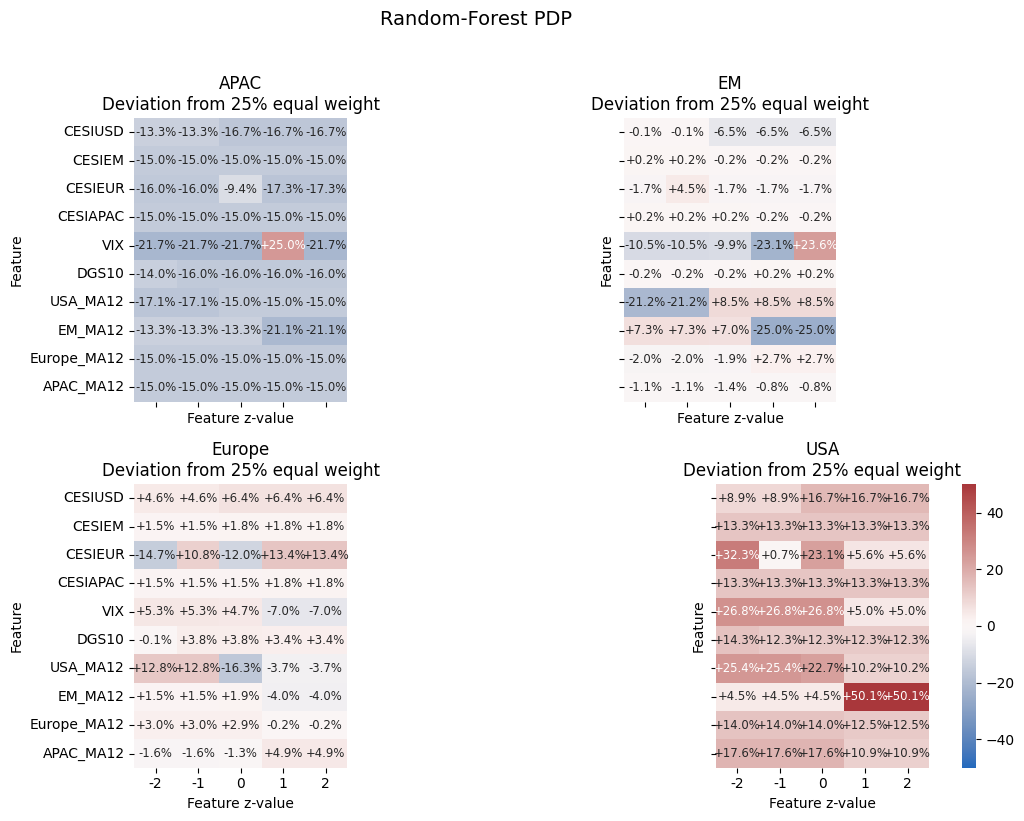

In [26]:
# ───────────────────────────────────────────────────────────────────────────────
#    STEP 0: Turn PDP on/off (place this right after RF/GB flags in your notebook)
# ───────────────────────────────────────────────────────────────────────────────
compute_pdp = True   # <-- set to False if you want to skip PDP entirely


# ───────────────────────────────────────────────────────────────────────────────
#    STEP 1: Combined PDP Heat-maps for Random-Forest (RF) and Gradient-Boost (XGB)
# ───────────────────────────────────────────────────────────────────────────────
if compute_pdp:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # ----- 1) Common settings ---------------------------------------------------
    z_grid = np.array([-2, -1, 0, 1, 2])       # standard-score grid
    # note: eq_w (equal‐weight) will be computed separately for RF and XGB below
    fmt_pct = lambda v: f"{v:+.1f}%"           # helper for annotating heatmap cells

    # Helper function to draw a 2×2 heatmap panel for a dict {class_name → DataFrame}
    def plot_panel(pdp_dev: dict, title_suffix: str):
        # pdp_dev is a dict mapping each class/factor → a DataFrame of deviations (Features×z_grid)
        vlim = max(df.abs().values.max() for df in pdp_dev.values())
        annot = {cls: df.applymap(fmt_pct) for cls, df in pdp_dev.items()}

        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
        axes = axes.flatten()
        eq_w_pct = 100.0 / len(pdp_dev)  # e.g., if 4 classes, each “equal weight” is 25%

        for ax, cls in zip(axes, pdp_dev.keys()):
            sns.heatmap(
                pdp_dev[cls], ax=ax,
                cmap="vlag", center=0,
                vmin=-vlim, vmax=+vlim,
                annot=annot[cls], fmt="",
                cbar=(ax is axes[-1]),
                annot_kws={"fontsize": "small"}
            )
            ax.set_aspect(1 / 1.5)
            ax.set_title(f"{cls}\nDeviation from {eq_w_pct:.0f}% equal weight")
            ax.set_xlabel("Feature z-value")
            ax.set_ylabel("Feature")

        plt.suptitle(title_suffix, y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()


    # ---------------------------------------------------------------------
    # 2) Random-Forest PDP (only if RF=True, rf_model & X_train exist)
    # ---------------------------------------------------------------------
    if RF and "rf_model" in globals() and "X_train" in globals():
        # 2a) Grab the actual class labels from rf_model
        rf_classes = list(rf_model.classes_)  
        #      └─ for example: ["ACWI", "USA", "EM", "Europe"] (whatever your labels are)

        # 2b) Build a DataFrame per class, indexed by FEATURES × z_grid
        pdp_rf = {
            cls: pd.DataFrame(index=FEATURES, columns=z_grid, dtype=float)
            for cls in rf_classes
        }

        # 2c) For each feature and each z in z_grid, overwrite X_train[feat] → (μ + z·σ),
        #     predict probabilities, then average across all rows
        for feat in FEATURES:
            mu, sd = X_train[feat].mean(), X_train[feat].std()
            for z in z_grid:
                x_val = mu + z * sd
                X_tmp = X_train.copy()
                X_tmp[feat] = x_val

                # predict_proba returns shape (n_rows, n_classes); take mean over rows
                avg_p = rf_model.predict_proba(X_tmp).mean(axis=0)

                # 2d) Store each class’s mean probability in the corresponding DataFrame
                for ci, cls in enumerate(rf_classes):
                    pdp_rf[cls].at[feat, z] = avg_p[ci]

        # 2e) Convert raw probabilities → %-point deviations from “equal weight”
        eq_w_rf = 1.0 / len(rf_classes)
        pdp_rf_dev = {
            cls: (df - eq_w_rf) * 100
            for cls, df in pdp_rf.items()
        }

        # 2f) Plot the 2×2 heatmap panel
        plot_panel(pdp_rf_dev, "Random-Forest PDP")


    # ---------------------------------------------------------------------
    # 3) XGBoost PDP (only if GB=True, xgb_model & X_train exist)
    # ---------------------------------------------------------------------
    if GB and "xgb_model" in globals() and "X_train" in globals():
        # 3a) We need a mapping from numeric codes → category names
        #     (this assumes y_train was used to fit xgb_model)
        y_cat = y_train.astype("category")
        mapping = dict(enumerate(y_cat.cat.categories))
        #     └─ e.g. {0: "ACWI", 1: "USA", 2: "EM", 3: "Europe"}

        # 3b) Build a DataFrame per class name (mapping.values()), indexed by FEATURES×z_grid
        pdp_xgb = {
            fac: pd.DataFrame(index=FEATURES, columns=z_grid, dtype=float)
            for fac in mapping.values()
        }

        # 3c) Same logic: for each feature and each z, overwrite and predict
        for feat in FEATURES:
            mu, sd = X_train[feat].mean(), X_train[feat].std()
            for z in z_grid:
                x_val = mu + z * sd
                X_tmp = X_train.copy()
                X_tmp[feat] = x_val

                avg_p = xgb_model.predict_proba(X_tmp).mean(axis=0)
                for ci, code in enumerate(xgb_model.classes_):
                    fac = mapping[code]
                    pdp_xgb[fac].at[feat, z] = avg_p[ci]

        # 3d) Convert raw probabilities → %-point deviations from “equal weight”
        eq_w_xgb = 1.0 / len(pdp_xgb)
        pdp_xgb_dev = {
            fac: (df - eq_w_xgb) * 100
            for fac, df in pdp_xgb.items()
        }

        # 3e) Plot the 2×2 heatmap panel
        plot_panel(pdp_xgb_dev, "XGBoost PDP")


    # ---------------------------------------------------------------------
    # 4) Warning if a requested model or X_train is missing
    # ---------------------------------------------------------------------
    if (RF and "rf_model" not in globals()) or (GB and "xgb_model" not in globals()):
        print(
            "⛔ PDP not drawn for one or both models because "
            "the model object (rf_model/xgb_model) or X_train is not in scope."
        )


# ───────────────────────────────────────────────────────────────────────────────
# end of “Combined PDP Heat-maps” cell
# ───────────────────────────────────────────────────────────────────────────────

###By feature plots

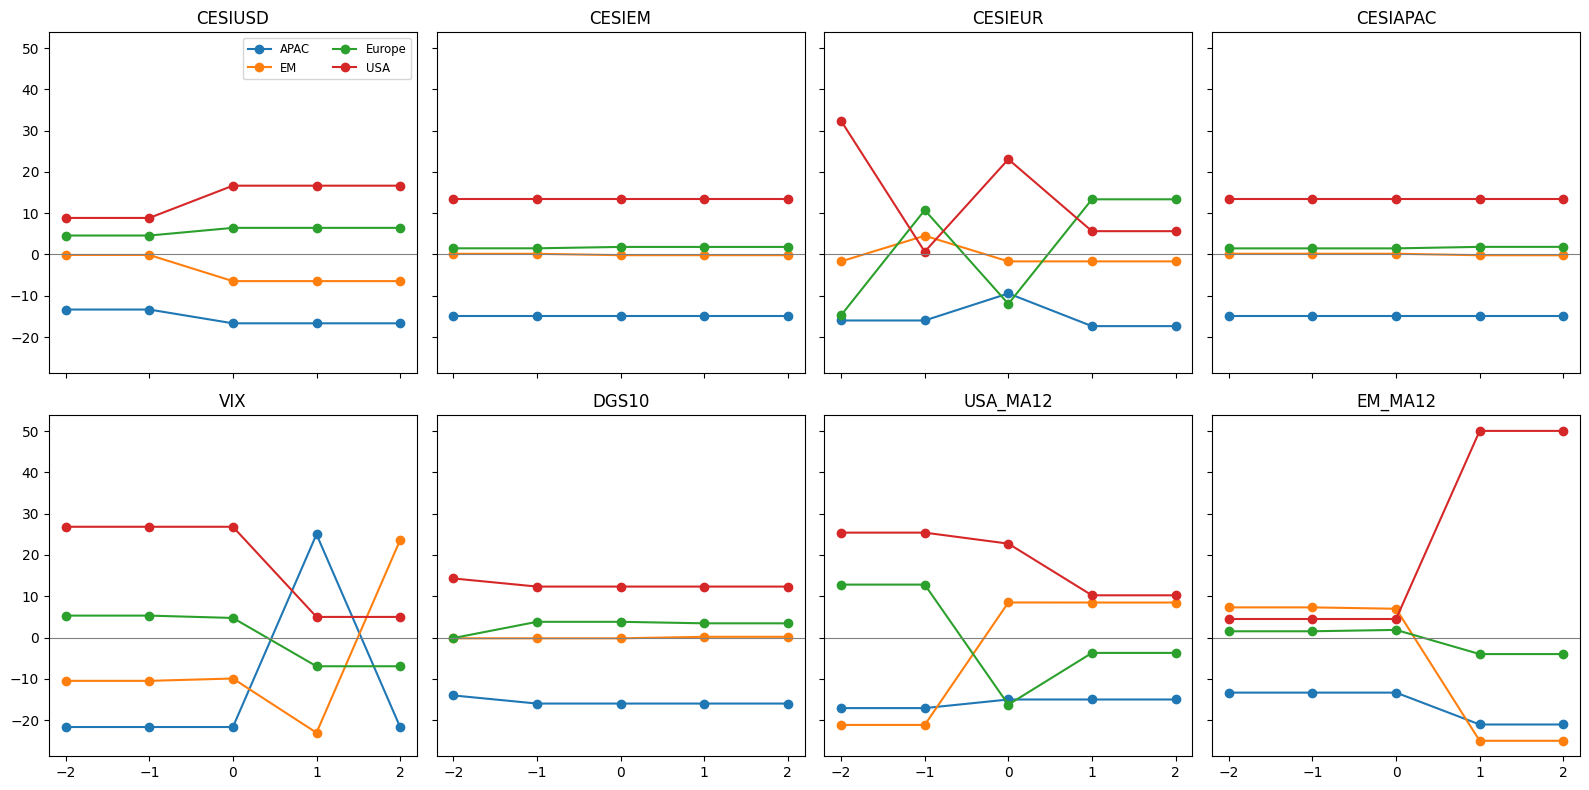

In [27]:
# ───────────────────────────────────────────────────────────────────────────────
#    Feature‐by‐feature PDP Line‐Plots (Random‐Forest & XGBoost)
# ───────────────────────────────────────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt

# Ensure z_grid matches what you used when computing pdp_rf_dev/pdp_xgb_dev:
z_grid = np.array([-2, -1, 0, 1, 2])

# ───────────────────────────────────────────────────────────────────────────────
# 1) Random‐Forest line plots (only if RF=True, compute_pdp=True, and pdp_rf_dev exists)
# ───────────────────────────────────────────────────────────────────────────────
if RF and compute_pdp and "pdp_rf_dev" in globals():
    pdp_dfs = pdp_rf_dev   # dict mapping each RF class → DataFrame of %-point deviations

    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    for ax, feat in zip(axes, FEATURES):
        for fac, df in pdp_dfs.items():
            # df.loc[feat] is a Series indexed by z_grid, already in %-point deviation
            dev = df.loc[feat]
            ax.plot(z_grid, dev, marker='o', label=fac)
        ax.set_title(feat)
        ax.axhline(0, color='gray', lw=0.8)
        if feat == FEATURES[0]:
            ax.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────────────────────────────────────────────────
# 2) XGBoost line plots (only if GB=True, compute_pdp=True, and pdp_xgb_dev exists)
# ───────────────────────────────────────────────────────────────────────────────
if GB and compute_pdp and "pdp_xgb_dev" in globals():
    pdp_dfs = pdp_xgb_dev   # dict mapping each XGB class → DataFrame of %-point deviations

    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    for ax, feat in zip(axes, FEATURES):
        for fac, df in pdp_dfs.items():
            dev = df.loc[feat]  # already in %-point deviation
            ax.plot(z_grid, dev, marker='o', label=fac)
        ax.set_title(feat)
        ax.axhline(0, color='gray', lw=0.8)
        if feat == FEATURES[0]:
            ax.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

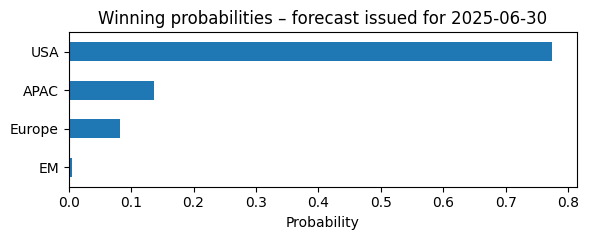

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# Function: show_probs
#     • date_input – any string accepted by pd.to_datetime
# ─────────────────────────────────────────────────────────────
def show_probs(date_input: str) -> None:
    requested = pd.to_datetime(date_input)

    mask = results_df_rf["Predicted_month"] <= requested
    if mask.any():
        idx_use = results_df_rf.loc[mask, "Predicted_month"].idxmax()
    else:
        idx_use = results_df_rf["Predicted_month"].idxmin()
        print("Requested date predates first model run – showing earliest "
              f"available prediction ({results_df_rf.at[idx_use, 'Predicted_month'].date()}).")

    row   = results_df_rf.loc[idx_use]
    probs = (pd.Series(row["Predicted_Probabilities"], index=FACTORS,
                       name="Probability").sort_values())

    display(probs.to_frame().style.format("{:.1%}"))

    ax = probs.plot(kind="barh", figsize=(6, 2.5))
    ax.set_xlabel("Probability")
    ax.set_title(f"Winning probabilities – forecast issued for "
                 f"{row['Predicted_month'].date()}")
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────
# USER-CONFIGURABLE DATE → edit this and run the cell
# ─────────────────────────────────────────────────────────────
DATE_REQUESTED = "2025-06-30"   # ← change me to any date you like

show_probs(DATE_REQUESTED)


##SHAP


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
from IPython.display import display, clear_output

# ───────────────────────────────────────────────────────────────────────────────
# 0) Make sure rf_model, results_df_rf, shap_data, FEATURES are already defined.
#    In particular, rf_model.classes_ must match the rows of each shap_values matrix.
# ───────────────────────────────────────────────────────────────────────────────

# 0a) Derive the exact “factor‐names” from the RF classifier itself,
#     so that we never pick an invalid index. This list length = number of rows in shap_values.
rf_classes = list(rf_model.classes_)  
#    e.g., rf_classes might be ['ACWI', 'USA', 'EM', 'Europe'] (length = 4).
#    If you had FACTORS = ['ACWI','USA','EM','Europe','APAC'], that APAC entry would be excluded
#    because rf_model.classes_ only contains 4 labels.

# ───────────────────────────────────────────────────────────────────────────────
# 1) Utility to pick the most‐recent snapshot ON or BEFORE a given timestamp
# ───────────────────────────────────────────────────────────────────────────────
def _snapshot_before(ts: pd.Timestamp):
    """
    Return the shap_data entry whose 'month' is the largest date <= ts.
    Raises ValueError if no snapshot is ≤ ts.
    """
    candidates = [s for s in shap_data if pd.to_datetime(s["month"]) <= ts]
    if not candidates:
        raise ValueError(f"No forecast available on or before {ts.date()}.")
    return max(candidates, key=lambda s: pd.to_datetime(s["month"]))


# ───────────────────────────────────────────────────────────────────────────────
# 2) Build the two widgets: a DatePicker (for forecast date) and a Dropdown (for factor/class)
# ───────────────────────────────────────────────────────────────────────────────
date_pick = w.DatePicker(
    description="Forecast date:",
    # Default to the latest predicted month in results_df_rf
    value=results_df_rf["Predicted_month"].max().date()
)

factor_pick = w.Dropdown(
    options=rf_classes,
    description="Factor:",
    # We will set factor_pick.value inside _redraw() if needed
)

out = w.Output()  # for capturing and clearing the plot area


# ───────────────────────────────────────────────────────────────────────────────
# 3) Callback to redraw the SHAP bar chart + table any time date_pick or factor_pick changes
# ───────────────────────────────────────────────────────────────────────────────
def _redraw(_=None):
    with out:
        clear_output(wait=True)

        # 3a) Find the most‐recent snapshot on/ before the selected date
        ts = pd.Timestamp(date_pick.value)
        snap = _snapshot_before(ts)

        # 3b) Extract the SHAP matrix (shape = [n_classes, n_features]) and predicted probabilities
        shap_mat = np.asarray(snap["shap_values"])   
        # Confirm shap_mat’s n_classes matches rf_classes length
        n_cls, n_feat = shap_mat.shape
        if n_cls != len(rf_classes) or n_feat != len(FEATURES):
            raise ValueError(
                f"Mismatch: shap_mat.shape = {shap_mat.shape}, "
                f"but len(rf_classes)={len(rf_classes)}, len(FEATURES)={len(FEATURES)}."
            )

        # 3c) Find predicted probabilities for that same month in results_df_rf
        row = (
            results_df_rf
            .loc[results_df_rf["Predicted_month"] == snap["month"]]
            .iloc[0]
        )
        probs = np.asarray(row["Predicted_Probabilities"])  # shape = (n_classes,)
        winner_ix = int(probs.argmax())
        winner = rf_classes[winner_ix]

        # 3d) If the user has not manually chosen a factor yet (or if their choice is invalid),
        #     default to the winning class:
        if factor_pick.value not in rf_classes:
            factor_pick.value = winner

        # 3e) Plot the SHAP bar chart for the selected factor
        f = factor_pick.value
        f_ix = rf_classes.index(f)  
        #    └— This is guaranteed to be in [0 .. n_cls-1] because rf_classes was built from rf_model.classes_

        # 3f) Convert shap values into percentage‐point contributions
        delta_pp = shap_mat[f_ix] * 100  # shape = (n_features,)
        s = (
            pd.Series(delta_pp, index=FEATURES, name="ΔSHAP (pp)")
              .sort_values(key=np.abs, ascending=True)
        )

        # 3g) Draw a horizontal bar chart
        plt.figure(figsize=(7, 4))
        colors = ["#3b7ddd" if v > 0 else "#d35f5f" for v in s]
        s.plot(kind="barh", color=colors)
        plt.axvline(0, color="black", lw=0.8)
        plt.title(f"{f}: Feature contributions for {snap['month'].date()}")
        plt.xlabel("Change in probability (percentage points)")
        plt.tight_layout()
        plt.show()

        # 3h) Display a table sorted by absolute contribution descending
        display(
            s.sort_values(key=np.abs, ascending=False)
             .to_frame()
             .style.format("{:+.2f}")
        )


# ───────────────────────────────────────────────────────────────────────────────
# 4) Wire up the callbacks and display the widgets + output area
# ───────────────────────────────────────────────────────────────────────────────
#    Each time date_pick.value or factor_pick.value changes, _redraw() will fire.
_redraw()
date_pick.observe(_redraw, names="value")
factor_pick.observe(_redraw, names="value")
display(w.HBox([date_pick, factor_pick]), out)

Output()

##Permutation

In [29]:
###############################################################################
# CELL 2 —  Interactive permutation‐importance explorer (with correct date index)
###############################################################################
if RF and compute_permutation_importance:
    import pandas as pd
    import matplotlib.pyplot as plt
    import ipywidgets as widgets
    from IPython.display import display

    # ────────────────────────────────────────────────────────────────────────────
    # 1) Sanity check: do we have any permutation‐importance data?
    # ────────────────────────────────────────────────────────────────────────────
    if not perm_importances_list:
        print("⚠️  No permutation‐importance rows collected; run the training cell first.")
    else:
        # ────────────────────────────────────────────────────────────────────────
        # 2) Build the DataFrame with a “forecast‐month” index instead of the raw
        #    training‐end dates. That way, the dropdown will show e.g. “2025-06-30”
        #    (the actual predicted month) instead of “2025-04-30” (the last training month).
        # ────────────────────────────────────────────────────────────────────────

        # 2a) Grab the Predicted_month column from results_df_rf (dtype should be datetime or convertible)
        #     We assume that each entry in perm_importances_list corresponds, in order, to a row
        #     in results_df_rf. If that is not exactly one‐to‐one, you must align them manually.
        all_predicted = pd.to_datetime(results_df_rf["Predicted_month"].values)

        # 2b) Determine how many rows we actually have in perm_importances_list
        n_perm = len(perm_importances_list)
        n_pred = len(all_predicted)
        if n_perm != n_pred:
            # If they differ, trim or pad so that lengths match. Usually perm_importances_list
            # is generated in lock‐step with results_df_rf, so they should be equal.
            n = min(n_perm, n_pred)
            perm_importances_trimmed = perm_importances_list[:n]
            pred_months_trimmed      = all_predicted[:n]
        else:
            perm_importances_trimmed = perm_importances_list
            pred_months_trimmed      = all_predicted

        # 2c) Build the DataFrame, indexed by the “Predicted_month”s (i.e. June, not April)
        perm_df = pd.DataFrame(
            data=perm_importances_trimmed,
            index=pred_months_trimmed,
            columns=FEATURES
        ).sort_index()

        # ────────────────────────────────────────────────────────────────────────
        # 3) Create interactive widgets: two dropdowns for start/end, and a radio for agg
        # ────────────────────────────────────────────────────────────────────────
        date_opts = list(perm_df.index)
        start_w   = widgets.Dropdown(
            options=date_opts,
            value=date_opts[0],
            description="Start:"
        )
        end_w     = widgets.Dropdown(
            options=date_opts,
            value=date_opts[-1],
            description="End:"
        )
        agg_w     = widgets.RadioButtons(
            options=["mean", "median"],
            value="mean",
            description="Agg."
        )

        # ────────────────────────────────────────────────────────────────────────
        # 4) Callback to redraw the bar chart whenever start/end/agg changes
        # ────────────────────────────────────────────────────────────────────────
        def plot_perm_range(start, end, agg):
            # If user accidentally picks start > end, swap them
            if start > end:
                start, end = end, start

            block = perm_df.loc[start:end]
            if block.empty:
                print("No data for this range.")
                return

            # Compute aggregate across the selected date range
            if agg == "mean":
                vals = block.mean()
            else:  # "median"
                vals = block.median()

            # Sort ascending so the largest importance is at the bottom of the horizontal bar chart
            vals_sorted = vals.sort_values()

            # Plot
            title = f"{agg.capitalize()} Permutation Importance\n{start.date()} → {end.date()}"
            plt.figure(figsize=(10, 6))
            vals_sorted.plot.barh()
            plt.title(title)
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

        # ────────────────────────────────────────────────────────────────────────
        # 5) Wire up the widgets and display
        # ────────────────────────────────────────────────────────────────────────
        ui = widgets.interactive(
            plot_perm_range,
            start=start_w,
            end=end_w,
            agg=agg_w
        )
        display(ui)

interactive(children=(Dropdown(description='Start:', options=(Timestamp('2011-08-31 00:00:00'), Timestamp('201…

##Confusion Matrix

C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\3937458598.py:70: UserWarning: Random Forest: 1 rows skipped because they contain labels not present in FACTORS.
  warnings.warn(



Confusion matrix for Random Forest (row %):
        USA   EM  Europe  APAC
USA    53.8 12.3    15.4  18.5
EM     33.3 17.9    35.9  12.8
Europe 37.5 25.0    22.5  15.0
APAC   40.9 31.8    18.2   9.1


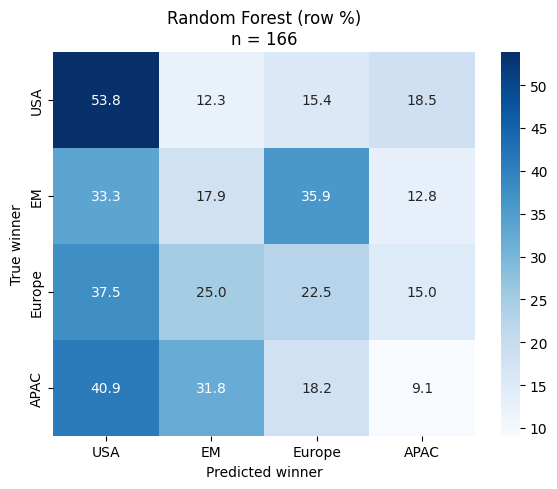


## Per‑Factor Metrics



C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\3937458598.py:70: UserWarning: Random Forest: 1 rows skipped because they contain labels not present in FACTORS.
  warnings.warn(



### Overall Performance Summary ###



C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\3937458598.py:70: UserWarning: Random Forest: 1 rows skipped because they contain labels not present in FACTORS.
  warnings.warn(


In [30]:
"""
Comprehensive evaluation script
===============================

Outputs
-------
1. Row‑normalised **confusion‑matrix heat‑maps** + a printed numeric table
   for each model
2. **Single combined per‑factor table** with a merged header row
3. Headline **Overall‑Performance Summary** table
"""

# ─────────────────────────────────────────────────────────────
# 0. Imports and expected inputs
# ─────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from IPython.display import display
import warnings  # ← FIX2: for clean user warnings

# -------------------------------------------------------------------
# EXPECTED INPUTS
#   FACTORS      : list[str]
#   results_dfs  : dict[str, pd.DataFrame] with
#                   • "Actual_Winner"
#                   • "Predicted_Winner"
# -------------------------------------------------------------------

# ← FIX2: robust auto‑derive FACTORS only if missing *and* ignore NaNs
if "FACTORS" not in globals():
    FACTORS = sorted(
        pd.concat(
            [df["Actual_Winner"].dropna().astype(str) for df in results_dfs.values()],
            ignore_index=True,
        ).unique()
    )

labels = FACTORS
items = list(results_dfs.items())

# ← FIX2: upfront validation
assert len(items) >= 1, "results_dfs must contain at least one model."
for name, df in items:
    for col in ("Actual_Winner", "Predicted_Winner"):
        if col not in df.columns:
            raise KeyError(f"{col} column missing from '{name}' DataFrame.")

# ─────────────────────────────────────────────────────────────
# Helper to clean each model’s label columns
# ─────────────────────────────────────────────────────────────
def _clean_labels(df, model_name):
    """Return y_true, y_pred with only allowed labels; drop bad rows."""
    y_true = df["Actual_Winner"].astype(str)
    y_pred = df["Predicted_Winner"].astype(str)

    valid_mask = y_true.isin(labels) & y_pred.isin(labels)
    dropped = (~valid_mask).sum()
    if dropped:
        warnings.warn(
            f"{model_name}: {dropped} rows skipped because they contain "
            "labels not present in FACTORS."
        )
    return y_true[valid_mask], y_pred[valid_mask]


# ─────────────────────────────────────────────────────────────
# 1. Confusion‑matrix heat‑maps + tables
# ─────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, len(items), figsize=(6 * len(items), 5), squeeze=False)
axes = axes[0]

for idx, (model_name, df_res) in enumerate(items):
    y_true, y_pred = _clean_labels(df_res, model_name)  # ← FIX2: use cleaner

    # Guard against empty after filtering
    if y_true.empty:
        warnings.warn(f"{model_name}: No valid rows left after cleaning; skipped.")
        continue

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_pct = np.divide(
        cm,
        cm.sum(axis=1, keepdims=True, dtype=float),
        where=cm.sum(axis=1, keepdims=True) != 0,
    ) * 100

    sns.heatmap(
        cm_pct,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        cbar=(idx == len(items) - 1),
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
    )
    axes[idx].set_title(f"{model_name} (row %)\nn = {len(y_true)}")
    axes[idx].set_xlabel("Predicted winner")
    axes[idx].set_ylabel("True winner")

    print(f"\nConfusion matrix for {model_name} (row %):")
    print(
        pd.DataFrame(cm_pct, index=labels, columns=labels).to_string(
            float_format=lambda x: f"{x:.1f}"
        )
    )

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 2. Combined per‑factor metrics table
# ─────────────────────────────────────────────────────────────
per_factor_tables: dict[str, pd.DataFrame] = {}

for model_name, df_res in items:
    y_true, y_pred = _clean_labels(df_res, model_name)
    if y_true.empty:
        continue

    rep = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=labels,
        output_dict=True,
        zero_division=0,
    )

    df_cr = (
        pd.DataFrame(rep)
        .T.drop("accuracy", errors="ignore")
        .rename(columns={"support": "Samples"})
    )

    for col in ("precision", "recall", "f1-score"):
        df_cr[col] = (df_cr[col] * 100).round(1)
    df_cr["Samples"] = df_cr["Samples"].astype(int)

    df_cr = df_cr.rename(
        columns={"precision": "Precision", "recall": "Recall", "f1-score": "F1-score"}
    )[
        ["Precision", "Recall", "F1-score", "Samples"]
    ]

    per_factor_tables[model_name] = df_cr

# Skip display if all models were emptied
if per_factor_tables:
    combined = pd.concat(
        {m: tbl.drop(columns="Samples") for m, tbl in per_factor_tables.items()},
        axis=1,
    )
    combined[("", "Samples")] = next(iter(per_factor_tables.values()))["Samples"]
    combined = combined.reindex(
        columns=[c for c in combined.columns if c[1] != "Samples"] + [("", "Samples")]
    )
    combined.columns.set_names(["Model", "Metric"], inplace=True)

    print("\n## Per‑Factor Metrics\n")
    display(
        combined.style.format(
            lambda x: f"{x:.1f}%" if isinstance(x, (float, np.floating)) else f"{x:d}"
        )
    )

# ─────────────────────────────────────────────────────────────
# 3. Overall‑performance summary
# ─────────────────────────────────────────────────────────────
summary_rows = []
for model_name, df_res in items:
    y_true, y_pred = _clean_labels(df_res, model_name)
    if y_true.empty:
        continue
    summary_rows.append(
        {
            "Model": model_name,
            "Accuracy (%)": round(accuracy_score(y_true, y_pred) * 100, 1),
            "Precision (wtd %)": round(
                precision_score(y_true, y_pred, average="weighted") * 100, 1
            ),
            "Recall (wtd %)": round(
                recall_score(y_true, y_pred, average="weighted") * 100, 1
            ),
            "F1 (wtd %)": round(
                f1_score(y_true, y_pred, average="weighted") * 100, 1
            ),
            "Samples": len(y_true),
        }
    )

if summary_rows:
    summary_df = pd.DataFrame(summary_rows).set_index("Model")
    print("\n### Overall Performance Summary ###\n")
    display(
        summary_df.style.format(
            {
                "Accuracy (%)": "{:.1f}%",
                "Precision (wtd %)": "{:.1f}%",
                "Recall (wtd %)": "{:.1f}%",
                "F1 (wtd %)": "{:.1f}%",
                "Samples": "{:d}",
            }
        )
    )
else:
    warnings.warn("No valid data left for overall performance summary.")


##Feature importance

C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\2288784291.py:37: UserWarning: df: no 'Date' column → skipping date filter.
  warnings.warn(f"{model_key}: no '{date_column}' column → skipping date filter.")
C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\2288784291.py:37: UserWarning: results_df_rf: no 'Date' column → skipping date filter.
  warnings.warn(f"{model_key}: no '{date_column}' column → skipping date filter.")
C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\2288784291.py:37: UserWarning: filtered_df: no 'Date' column → skipping date filter.
  warnings.warn(f"{model_key}: no '{date_column}' column → skipping date filter.")
C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\2288784291.py:37: UserWarning: rf: no 'Date' column → skipping date filter.
  warnings.warn(f"{model_key}: no '{date_column}' column → skipping date filter.")
C:\Users\B739223\AppData\Local\Temp\1\ipykernel_27092\2288784291.py:37: UserWarning: df_res: no 'Date' column → skipping date fi

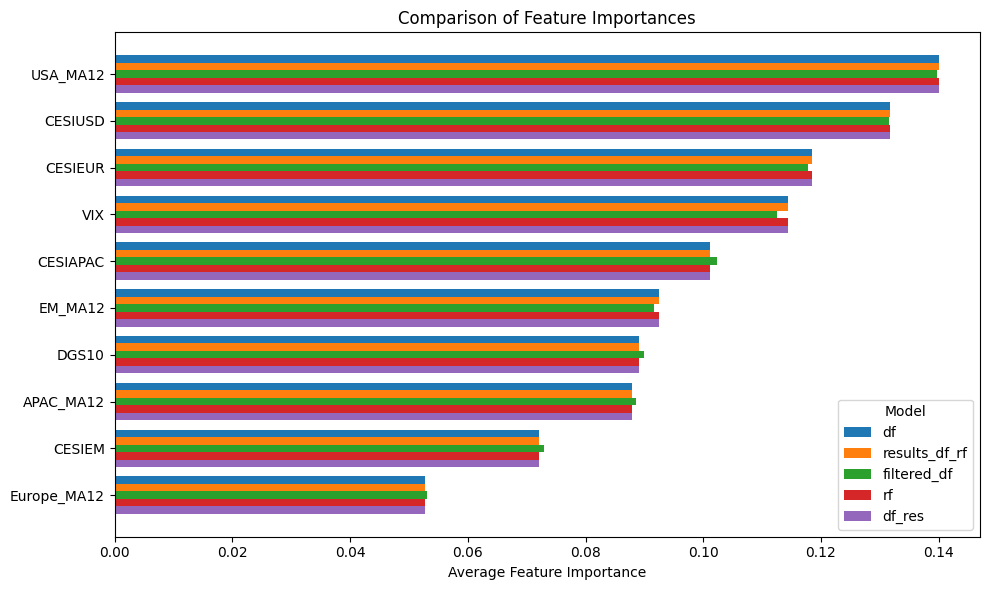

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


# ─ User‑set date filter (or None) ─
date_column = "Date"         # ← set your date column name, or None
start_date  = "2025-06-01"   # ← set start date (inclusive), or None
end_date    = "2025-06-30"   # ← set end date (inclusive), or None

def plot_feature_importances(
    results_dfs: dict[str, pd.DataFrame],
    FEATURES: list[str],
    date_column: str | None = None,
    start_date: str | pd.Timestamp | None = None,
    end_date:   str | pd.Timestamp | None = None
) -> None:
    """
    Plot grouped horizontal bars of average feature importances, optionally
    restricted to a date range.
    """
    # — Parse date bounds —
    if date_column and (start_date or end_date):
        if start_date is not None:
            start_date = pd.to_datetime(start_date)
        if end_date   is not None:
            end_date   = pd.to_datetime(end_date)

    # — Compute per‑model importances —
    model_importances: dict[str, np.ndarray] = {}
    for model_key, df in results_dfs.items():
        df_work = df
        # 1) filter by date if requested
        if date_column and (start_date or end_date):
            if date_column not in df.columns:
                warnings.warn(f"{model_key}: no '{date_column}' column → skipping date filter.")
            else:
                df_work = df.copy()
                df_work[date_column] = pd.to_datetime(df_work[date_column])
                mask = pd.Series(True, index=df_work.index)
                if start_date is not None:
                    mask &= df_work[date_column] >= start_date
                if end_date is not None:
                    mask &= df_work[date_column] <= end_date
                dropped = (~mask).sum()
                if dropped:
                    warnings.warn(
                        f"{model_key}: dropped {dropped} rows outside "
                        f"[{start_date.date() if start_date else '–'}, "
                        f"{end_date.date()   if end_date   else '–'}]."
                    )
                df_work = df_work.loc[mask]

        # 2) validate & stack feature importances
        if "Feature_Importances" not in df_work.columns:
            raise KeyError(f"'{model_key}' DataFrame lacks 'Feature_Importances'.")
        arrs = df_work["Feature_Importances"].apply(lambda x: np.asarray(x, float))
        bad = arrs[arrs.apply(lambda a: a.size != len(FEATURES))]
        if not bad.empty:
            raise ValueError(
                f"{model_key}: found length‑{bad.iloc[0].size} arrays, expected {len(FEATURES)}."
            )
        stacked = np.stack(arrs.values, axis=0)
        model_importances[model_key] = stacked.mean(axis=0)

    # — Build & sort DataFrame —
    imp_df = pd.DataFrame(model_importances, index=FEATURES)
    imp_df["MeanAcrossModels"] = imp_df.mean(axis=1)
    imp_df = imp_df.sort_values("MeanAcrossModels", ascending=False)
    sorted_feats = imp_df.index.tolist()
    imp_df = imp_df.drop(columns="MeanAcrossModels")

    # — Plot —
    models   = imp_df.columns.tolist()
    n_models = len(models)
    n_feats  = len(sorted_feats)
    y_pos    = np.arange(n_feats)
    bar_h    = 0.8 / n_models

    fig, ax = plt.subplots(figsize=(10, max(4, n_feats * 0.6)))
    for i, m in enumerate(models):
        offset = (i - (n_models - 1) / 2) * bar_h
        ax.barh(
            y_pos + offset,
            imp_df.loc[sorted_feats, m].values,
            height=bar_h,
            label=m
        )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_feats)
    ax.invert_yaxis()
    ax.set_xlabel("Average Feature Importance")
    ax.set_title("Comparison of Feature Importances")
    ax.legend(title="Model", loc="lower right")
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────────
# 1) Prepare your inputs (edit these as needed)
# ─────────────────────────────────────────────────────────────

# If you already have this dict & list defined, skip these two blocks
# ─ Auto‑discover DataFrames with 'Feature_Importances' ─
if "results_dfs" not in globals():
    results_dfs = {
        name: obj
        for name, obj in globals().items()
        if isinstance(obj, pd.DataFrame) and "Feature_Importances" in obj.columns
    }
    if not results_dfs:
        raise NameError("No DataFrame with 'Feature_Importances' found.")
    warnings.warn(f"Auto‑discovered DataFrames: {list(results_dfs)}")

# ─ Auto‑infer FEATURES list ─
if "FEATURES" not in globals():
    first = next(iter(results_dfs.values()))["Feature_Importances"].iloc[0]
    FEATURES = [f"Feature {i+1}" for i in range(len(first))]
    warnings.warn(f"FEATURES missing – using placeholders: {FEATURES}")


# ─────────────────────────────────────────────────────────────
# 2) Run the plot
# ─────────────────────────────────────────────────────────────
plot_feature_importances(
    results_dfs,
    FEATURES,
    date_column = date_column,
    start_date  = start_date,
    end_date    = end_date
)


##Allocation chart

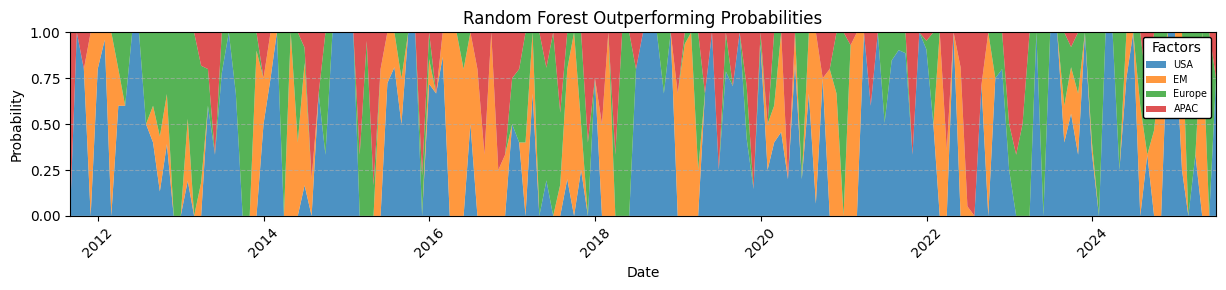

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── 0.  Figure parameters ───────────────────────────────────────────────────────
panel_height = 3.0
fig_width    = 12
num_models   = len(results_dfs)
fig_height   = panel_height * num_models

fig, axes = plt.subplots(
    nrows=num_models, ncols=1,
    figsize=(fig_width, fig_height),
    sharex=True,
)

if num_models == 1:      # keep iterable
    axes = [axes]

# ── 1.  Get the GLOBAL date span so every axis uses identical limits ───────────
all_dates = pd.concat(
    [pd.to_datetime(df["Predicted_month"], errors="coerce") for df in results_dfs.values()]
).dropna()
date_min, date_max = all_dates.min(), all_dates.max()

# ── 2.  Plot each model ────────────────────────────────────────────────────────
for ax, (model_key, df_model) in zip(axes, results_dfs.items()):
    df_temp = df_model.copy()

    # Parse dates & clean
    df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors="coerce")
    df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month")

    # Probability matrix → DataFrame
    full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
    probability_df         = pd.DataFrame(full_probs, columns=FACTORS)
    probability_df["Date"] = df_temp["Predicted_month"].values

    # Stackplot
    ax.stackplot(
        probability_df["Date"],
        [probability_df[col] for col in FACTORS],
        labels=FACTORS,
        alpha=0.8,
    )

    # Aesthetics
    ax.set_title(f"{model_key} Outperforming Probabilities", fontsize=12, pad=6)
    ax.set_ylabel("Probability", fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# ── 3.  Remove x-axis padding & apply shared limits ────────────────────────────
for ax in axes:
    ax.set_xlim(date_min, date_max)  # exact span
    ax.margins(x=0)                  # turn off the default 5% padding

# Legend only on the first axis (or wherever you prefer)
axes[0].legend(
    loc="upper right",
    fontsize="x-small",
    title="Factors",
    frameon=True,
    framealpha=1.0,
    facecolor="white",
    edgecolor="black",
)

# ── 4.  Final touches ──────────────────────────────────────────────────────────
axes[-1].set_xlabel("Date", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(left=0.04, right=0.995)   # trims the white border outside axes
plt.show()

##Factor weight analysis

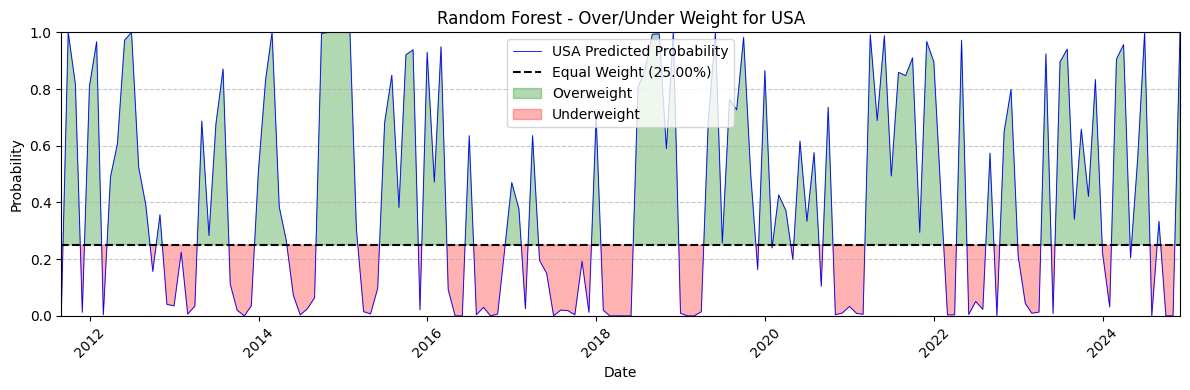

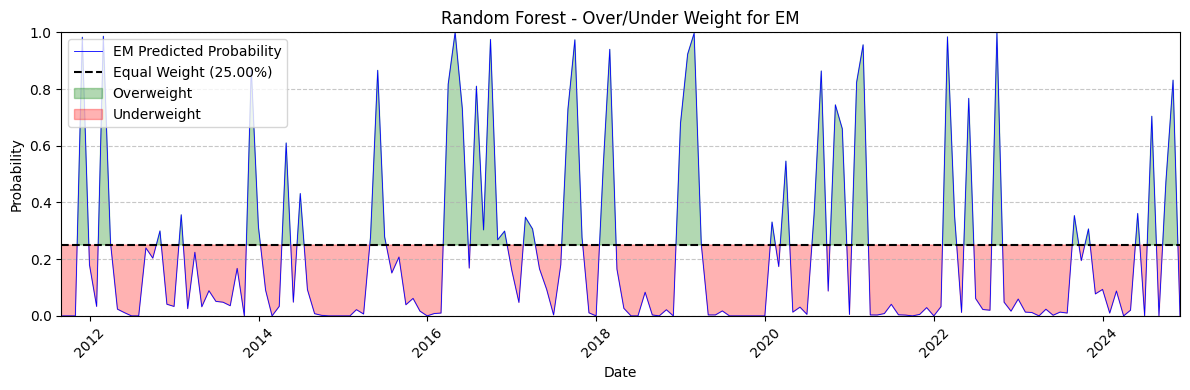

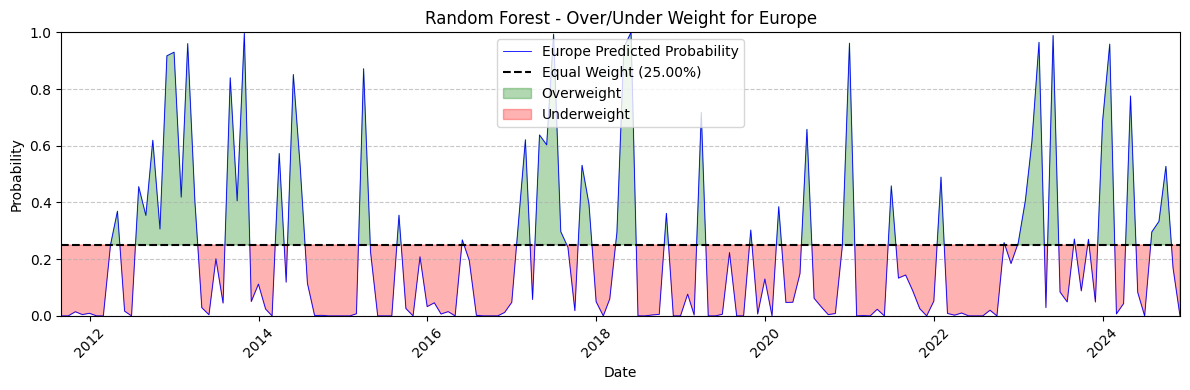

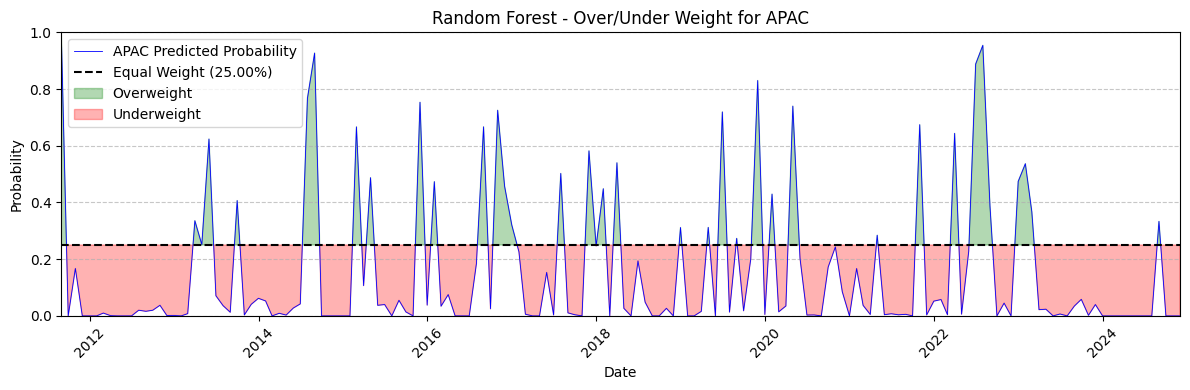

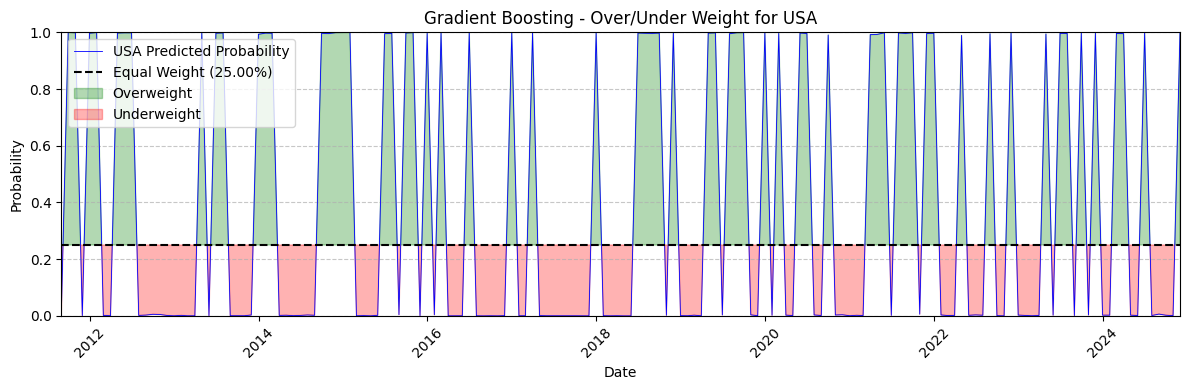

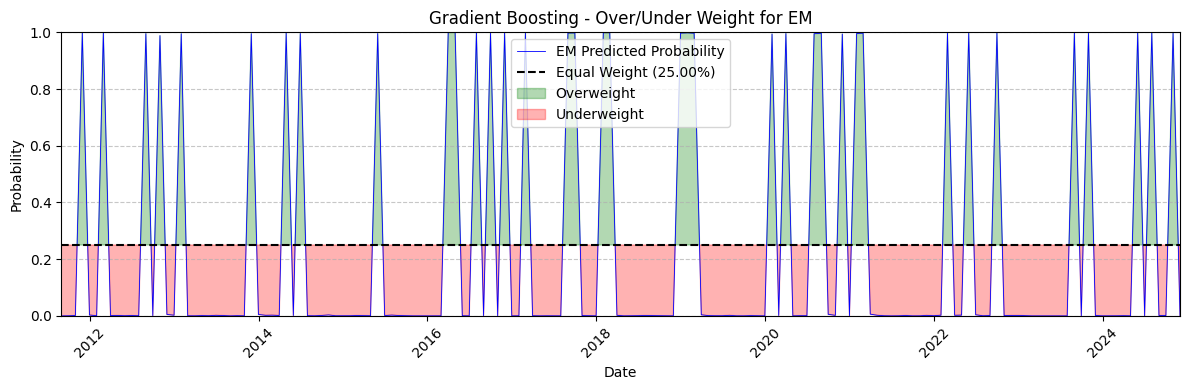

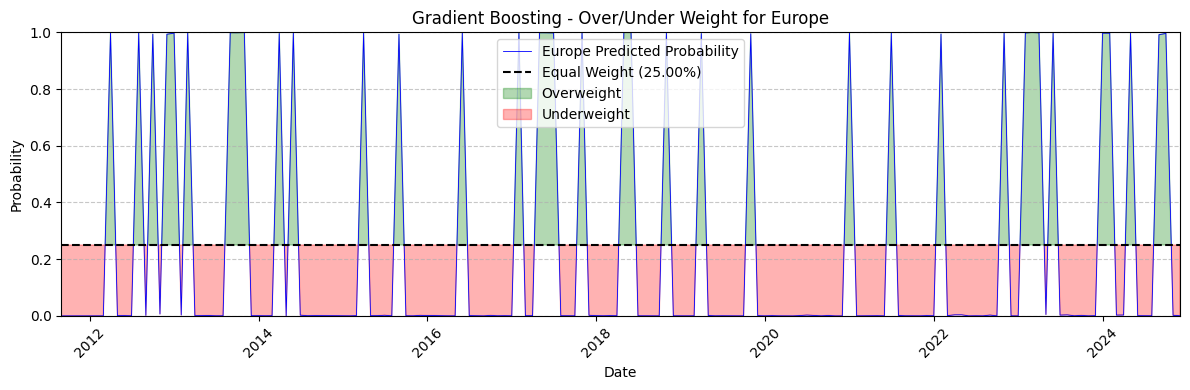

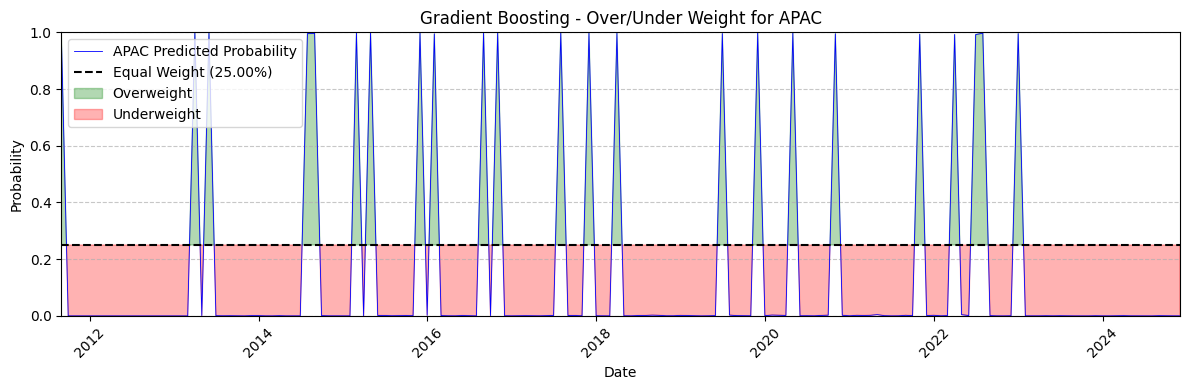

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Toggle:
combine_all_models = False  # Set to True to combine all models into the same charts; False for individual charts per model

# Set the date range for viewing.
start_date = pd.to_datetime("1968-07-30")
end_date   = pd.to_datetime("2024-11-30")

# Define static equal weight value.
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors equal_weight = 0.20

if combine_all_models:
    # Combined charts: One set of subplots (one per factor) for all models.
    n_factors = len(FACTORS)
    fig, axs = plt.subplots(n_factors, 1, figsize=(12, 4 * n_factors), sharex=False)
    if n_factors == 1:
        axs = [axs]  # ensure axs is iterable

    for i, factor in enumerate(FACTORS):
        ax = axs[i]
        min_dates = []
        max_dates = []

        # Loop through each model's results
        for model_key, df_model in results_dfs.items():
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            # Stack predicted probabilities into a DataFrame.
            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            ax.plot(filtered_df["Date"], filtered_df[factor],
                    label=f"{factor}_{model_key}", linewdth=0.6)

            min_dates.append(filtered_df["Date"].min())
            max_dates.append(filtered_df["Date"].max())

        # Set x-axis limits to exactly the data span (if any data exist)
        if min_dates and max_dates:
            ax.set_xlim(min(min_dates), max(max_dates))

        # Draw the static equal weight horizontal line.
        ax.axhline(equal_weight, color='black', linestyle='--',
                   label=f"Equal Weight ({equal_weight:.2%})")

        ax.set_title(f"{factor} Predicted Probabilities Across Models", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(loc='best', fontsize='small')

    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    # Separate charts: Loop over each model and for each factor create individual charts.
    for model_key, df_model in results_dfs.items():
        for factor in FACTORS:
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            plt.figure(figsize=(12, 4))
            plt.plot(filtered_df["Date"], filtered_df[factor],
                     label=f"{factor} Predicted Probability", color='blue', linewidth=0.6)

            plt.axhline(equal_weight, color='black', linestyle='--',
                        label=f"Equal Weight ({equal_weight:.2%})")

            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] > equal_weight),
                             interpolate=True, color='green', alpha=0.3, label='Overweight')
            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] < equal_weight),
                             interpolate=True, color='red', alpha=0.3, label='Underweight')

            plt.title(f"{model_key} - Over/Under Weight for {factor}")
            plt.xlabel("Date")
            plt.ylabel("Probability")
            plt.ylim(0, 1)
            # Set x-axis limits to exactly where data exists.
            plt.xlim(filtered_df["Date"].min(), filtered_df["Date"].max())
            plt.legend(loc='best')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


##Total outperforming probabilities

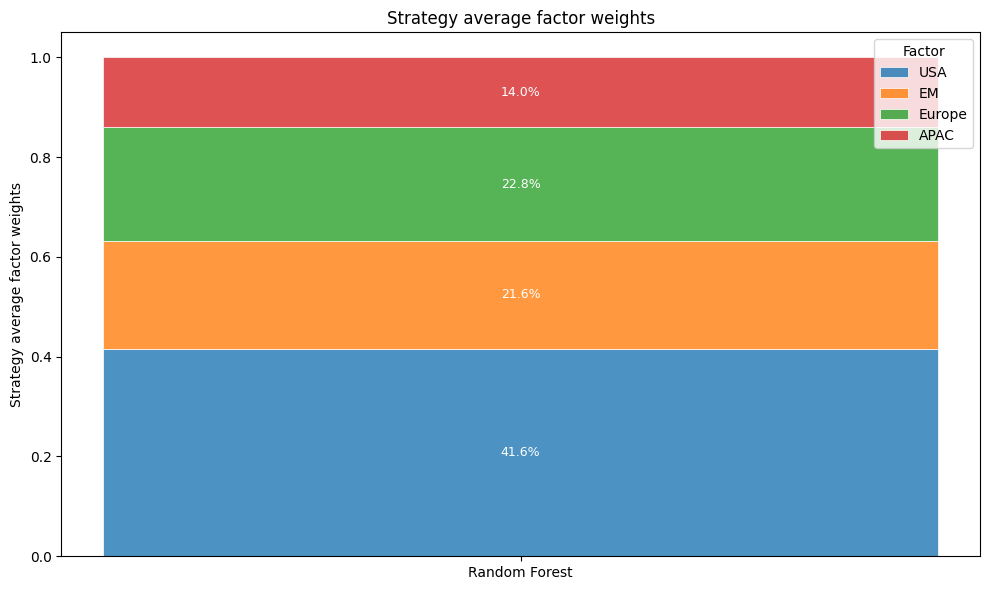

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# ----------------------------------------------------
# 1. Compute average predicted probabilities per model
# ----------------------------------------------------
avg_probs_dict = {}
avg_highest_factor_weight_dict = {}

for model_key, df_model in results_dfs.items():
    full_probs = np.vstack(df_model["Predicted_Probabilities"].values)

    # 1a. Compute the average probabilities across all rows
    avg = full_probs.mean(axis=0)
    avg_probs_dict[model_key] = pd.Series(avg, index=FACTORS)

    # 1b. Compute the average of the highest weight factor
    #     (for each time step, pick the max factor weight, then average those)
    avg_highest_factor_weight_dict[model_key] = full_probs.max(axis=1).mean()

# Create a DataFrame where rows = models, columns = factors
avg_probs_df = pd.DataFrame(avg_probs_dict).T
avg_probs_df.index.name = "Model"
avg_probs_df = avg_probs_df.round(4)

# ----------------------------------------------------
# 2. Generate consistent factor colors from stackplot
# ----------------------------------------------------
# Use a dummy stackplot to extract the assigned factor colors
_, ax_dummy = plt.subplots()
dummy_data = np.random.rand(10, len(FACTORS))
dummy_dates = pd.date_range("2000-01-01", periods=10)
stack = ax_dummy.stackplot(dummy_dates, dummy_data.T, labels=FACTORS, alpha=0.8)
plt.close()  # We don’t want to display this

# Build color map: factor name → RGBA color
factor_colors = {factor: poly.get_facecolor()[0] for factor, poly in zip(FACTORS, stack)}

# ----------------------------------------------------
# 3. Display HTML Table of average probabilities
# ----------------------------------------------------
html_table = avg_probs_df.reset_index().to_html(index=False, classes="table table-striped table-bordered", border=0)
display(HTML("<h3>Average Outperforming Probabilities by Model</h3>" + html_table))

# ----------------------------------------------------
# 4. Print average of the highest factor weight by model
# ----------------------------------------------------
display(HTML("<h4>Average of the Highest Factor Weight by Model</h4>"))
for model_key, avg_highest in avg_highest_factor_weight_dict.items():
    display(HTML(f"<p><strong>{model_key}:</strong> {avg_highest:.4f}</p>"))

# ----------------------------------------------------
# 5. Stacked Bar Chart with Consistent Colors and Labels
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(avg_probs_df))
x = np.arange(len(avg_probs_df))

for factor in FACTORS:
    values = avg_probs_df[factor].values
    bars = ax.bar(x, values, bottom=bottom,
                  label=factor,
                  color=factor_colors[factor],
                  edgecolor="white",
                  linewidth=0.5)

    # Centered labels
    for bar, val in zip(bars, values):
        if val > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val * 100:.1f}%",
                ha="center", va="center", fontsize=9, color="white"
            )

    bottom += values

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(avg_probs_df.index)
ax.set_ylabel("Strategy average factor weights")
ax.set_title("Strategy average factor weights")
ax.legend(title="Factor", loc="upper right")
plt.tight_layout()
plt.show()


#Return data

In [ ]:
import pandas as pd
from IPython.display import display

# ==============================================================================
# Step 0: Define column orders based on your requirements
# ------------------------------------------------------------------------------
# Common columns that are identical across all models.
common_cols = ['Predicted_month', 'Mkt', 'RF', 'Mkt-RF', 'Us_standard'] + FACTORS + ['Equal_Weight_Return', 'Actual_Winner']

# Model-specific columns that will be renamed.
model_specific_cols = ['Allocated_Return', 'Predicted_Winner']

# ==============================================================================
# Step 1. Build a base common DataFrame from one model's merged results.
# ------------------------------------------------------------------------------
# Take the first model as the base to extract common columns.
base_key, base_df = list(results_dfs.items())[0]
base_df = base_df.copy()
base_df['Predicted_month'] = pd.to_datetime(base_df['Predicted_month'], errors='coerce')

# Merge with df_sorted (the master DataFrame sorted by date) on date.
base_df_local = base_df.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')
common_df = base_df_local[[c for c in common_cols if c in base_df_local.columns]].copy()

# ==============================================================================
# Step 2. Process each model individually to extract the model-specific columns.
# ------------------------------------------------------------------------------
# We'll assign a new display name using numbering such that each model gets:
# "ML{number}: {Model Name}"
model_dfs = []         # Will hold one DataFrame per model.
new_model_names = []   # To store new model names.
for i, (model_key, df_model) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_key}"  # New display name.
    new_model_names.append(new_model_name)

    df_temp = df_model.copy()
    df_temp['Predicted_month'] = pd.to_datetime(df_temp['Predicted_month'], errors='coerce')

    # Merge with df_sorted on 'Predicted_month' = 'Date'
    df_temp_local = df_temp.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')

    # Keep only the 'Predicted_month' plus the model-specific columns.
    subset_cols = ['Predicted_month'] + [col for col in model_specific_cols if col in df_temp_local.columns]
    df_subset = df_temp_local[subset_cols].copy()

    # Rename model-specific columns with the new model name.
    rename_dict = {}
    for col in model_specific_cols:
        if col in df_subset.columns:
            rename_dict[col] = f"{new_model_name} {col}"
    df_subset.rename(columns=rename_dict, inplace=True)

    model_dfs.append(df_subset)

# ==============================================================================
# Step 3. Merge each model-specific DataFrame with the common DataFrame.
# ------------------------------------------------------------------------------
combined_df = common_df.copy()
for df_sub in model_dfs:
    combined_df = combined_df.merge(df_sub, on='Predicted_month', how='left')

# ==============================================================================
# Step 4. Reorder the columns to match the desired order.
# ------------------------------------------------------------------------------
benchmark_cols = ['Mkt', 'RF', 'Mkt-RF', 'Us_standard']
common_order = ['Predicted_month'] + benchmark_cols + FACTORS
# Model-specific allocated return columns.
allocated_cols = [f"{name} Allocated_Return" for name in new_model_names]
# Model-specific predicted winner columns.
predicted_cols = [f"{name} Predicted_Winner" for name in new_model_names]

final_order = common_order + ['Equal_Weight_Return'] + allocated_cols + ['Actual_Winner'] + predicted_cols
final_order = [col for col in final_order if col in combined_df.columns]

combined_df = combined_df[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ==============================================================================
# Step 5. Display the final combined results table.
# ------------------------------------------------------------------------------
display(combined_df)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).max())


Predicted_month       USA        EM    Europe      APAC  \
0        2011-08-31 -0.059561 -0.093684 -0.104339 -0.088098   
1        2011-09-30 -0.007178 -0.086927 -0.046135 -0.030133   
2        2011-10-31  0.068820  0.089855  0.077718  0.038112   
3        2011-11-30  0.031280 -0.032465 -0.014210 -0.032784   
4        2011-12-31  0.045612  0.024319  0.020420  0.040287   
..              ...       ...       ...       ...       ...   
162      2025-02-28 -0.014731  0.005777  0.034796 -0.001724   
163      2025-03-31 -0.095809 -0.034750 -0.043569 -0.045308   
164      2025-04-30 -0.053567 -0.038013 -0.013582 -0.023111   
165      2025-05-31  0.063705  0.040535  0.039211  0.046022   
166      2025-06-30       NaN       NaN       NaN       NaN   

     Equal_Weight_Return  ML1: RF Allocated_Return  ML2: GB Allocated_Return  \
0              -0.086421                 -0.084584                 -0.088093   
1              -0.042593                 -0.016635                 -0.007213   
2               0.068626                  0.069994                  0.068846   
3              -0.012045                 -0.019726                 -0.032390   
4               0.032660                  0.040399                  0.045545   
..                   ...                       ...                       ...   
162             0.006029                  0.022769                  0.034559   
163            -0.054859                 -0.051391                 -0.043711   
164            -0.032068                 -0.036590                 -0.038028   
165             0.047368                  0.041070                  0.039280   
166                  NaN                       NaN                       NaN   

    Actual_Winner ML1: RF Predicted_Winner ML2: GB Predicted_Winner  
0             USA                     APAC                     APAC  
1             USA                      USA                      USA  
2              EM                      USA                      USA  
3             USA                       EM                       EM  
4             USA                      USA                      USA  
..            ...                      ...                      ...  
162        Europe                   Europe                   Europe  
163            EM                   Europe                   Europe  
164        Europe                       EM                       EM  
165           USA                   Europe                   Europe  
166           NaN                      USA                      USA  

[167 rows x 11 columns]


First date in 'Predicted_month': 2011-08-31 00:00:00
Last date in 'Predicted_month': 2025-06-30 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import textwrap
from IPython.display import display

# ==============================================================================
# ASSUMPTIONS:
# 1) `combined_df` already exists and contains:
#      - 'Predicted_month' (datetime)
#      - Possibly a column 'RF' representing the risk‐free (benchmark) return. 
#        If no such column exists, we'll treat RF = 0.
#      - 'Equal_Weight_Return'
#      - One or more "ML#:<Model Name> Allocated_Return" columns
#      - (Optionally) other columns such as 'Mkt', 'Mkt-RF', etc., but we only absolutely need 'RF'
# 2) `FEATURES` is a Python list (used earlier) but not directly needed here.
# ==============================================================================

# 0) Define your date range (adjust as needed):
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2025-12-30")

# 1) Filter `combined_df` by date. Create a copy so the original isn't modified.
filtered_df = combined_df.loc[
    (combined_df["Predicted_month"] >= start_date) & 
    (combined_df["Predicted_month"] <= end_date)
].copy()

# 2) Ensure there is a 'Year' column (for grouping). If it doesn't exist, create it.
if "Year" not in filtered_df.columns:
    filtered_df["Year"] = filtered_df["Predicted_month"].dt.year

# 3) Make sure there is an 'RF' column for the risk‐free rate. 
#    If it's missing, create an 'RF' column of zeros for every row.
if "RF" not in filtered_df.columns:
    filtered_df["RF"] = 0.0

# 4) Identify all “Allocated_Return” columns (these belong to your ML strategies).
#    We assume each such column has the substring "Allocated_Return" in its name.
ml_return_cols = [col for col in filtered_df.columns if "Allocated_Return" in col]

# 5) Build a shorter “model name → display name” map by stripping off the "Allocated_Return" suffix:
ml_name_map = {ml: ml.replace("Allocated_Return", "").strip() for ml in ml_return_cols}

# ==============================================================================
# Helper function: Compute annualized return, volatility, and Sharpe
# (volatility measured as stdev of (returns − rf) × sqrt(12), 
#  Sharpe = (ann_return − ann_rf) / ann_vol                      )
# ==============================================================================
def compute_annual_metrics(returns: pd.Series, rf: pd.Series):
    """
    Given a pd.Series of monthly returns and a pd.Series of monthly risk‐free returns:
      - Both must share the same DateTimeIndex or at least the same length.
      - We compute the annualized return as (1 + r1)*(1 + r2)*… − 1.
      - We compute the annualized rf similarly.
      - Excess return = ann_return − ann_rf.
      - Volatility = stdev(returns − rf) × sqrt(12).
      - Sharpe = excess_return / volatility (or NaN if vol=0).
    """
    returns = returns.dropna()
    if returns.empty:
        return np.nan, np.nan, np.nan

    # Align rf to the returns index; missing rf entries become NaN → drop them if needed
    rf_aligned = rf.reindex(returns.index).fillna(0.0)

    # 1) Annualized return of the strategy
    ann_ret = (1 + returns).prod() - 1

    # 2) Annualized return of the risk‐free
    ann_rf = (1 + rf_aligned).prod() - 1

    # 3) Annualized excess return
    ann_ex_ret = ann_ret - ann_rf

    # 4) Annualized volatility (std of (r − rf) × sqrt(12))
    diff = returns - rf_aligned
    ann_vol = diff.std(ddof=0) * np.sqrt(12)

    # 5) Sharpe ratio (if vol=0, set to NaN)
    ann_sharpe = ann_ex_ret / ann_vol if ann_vol != 0 else np.nan

    return ann_ret, ann_vol, ann_sharpe

# ==============================================================================
# 6) Build two DataFrames:
#    - df_metrics: contains raw annual metrics (Return, Vol, Sharpe) for Equal_Weight + each ML
#    - df_excess:  contains the excess (ML − Equal_Weight) for each metric
# ==============================================================================

metrics_rows = []
excess_rows  = []

# Group by Year
for year, grp in filtered_df.groupby("Year", observed=True):
    # 6a) Compute Equal‐Weight metrics
    ew_ret, ew_vol, ew_sharpe = compute_annual_metrics(
        grp["Equal_Weight_Return"], grp["RF"]
    )
    row_m = {
        "Year": year,
        "Equal_Weight Return": ew_ret,
        "Equal_Weight Vol":    ew_vol,
        "Equal_Weight Sharpe": ew_sharpe
    }
    row_e = {"Year": year}

    # 6b) Compute each ML strategy’s metrics and its excess over Equal_Weight
    for ml in ml_return_cols:
        # Extract the ML’s monthly returns and pass the same rf series
        ml_short = ml_name_map[ml]  # e.g. "ML1: Random Forest"
        ml_ret, ml_vol, ml_sharpe = compute_annual_metrics(grp[ml], grp["RF"])

        # Fill in raw metrics for this ML
        row_m[f"{ml_short} Return"] = ml_ret
        row_m[f"{ml_short} Vol"]    = ml_vol
        row_m[f"{ml_short} Sharpe"] = ml_sharpe

        # Compute and store excess metrics = (ML metric − EW metric)
        row_e[f"{ml_short} Excess Return"]  = ml_ret - ew_ret
        row_e[f"{ml_short} Excess Vol"]     = ml_vol - ew_vol
        row_e[f"{ml_short} Excess Sharpe"]  = ml_sharpe - ew_sharpe

    metrics_rows.append(row_m)
    excess_rows.append(row_e)

# Convert to DataFrame, set Year as index, and sort by Year
df_metrics = pd.DataFrame(metrics_rows).set_index("Year").sort_index()
df_excess  = pd.DataFrame(excess_rows).set_index("Year").sort_index()

# ==============================================================================
# 7) Wrapping long column names onto multiple lines (optional, for readability)
# ==============================================================================

def wrap_colname(colname: str, max_width: int = 15) -> str:
    """
    Insert newline breaks so that long column names wrap at `max_width` characters.
    """
    lines = textwrap.wrap(colname, width=max_width)
    return "\n".join(lines)

# Apply wrapping to all column names in df_metrics and df_excess
df_metrics.columns = [wrap_colname(col) for col in df_metrics.columns]
df_excess.columns  = [wrap_colname(col) for col in df_excess.columns]

# ==============================================================================
# 8) Styling function to allow multiline headers + format floats to 3 decimals
# ==============================================================================

def style_with_wrapping_and_format(df: pd.DataFrame):
    styled = (
        df.style
          .set_table_styles([
              {
                  "selector": "th",
                  "props": [
                      ("white-space", "pre-wrap"),   # preserve line breaks
                      ("word-wrap", "break-word")    # wrap long words
                  ]
              }
          ])
          .format(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
    )
    return styled

# ==============================================================================
# 9) Display the annual metrics and excess metrics tables
# ==============================================================================

display(style_with_wrapping_and_format(df_metrics))
display(style_with_wrapping_and_format(df_excess))

# ==============================================================================
# 10) Summary: Count how often each ML “beats” Equal Weight for each metric
# ==============================================================================

summary_rows = []
total_years = len(df_excess.index)

# Helper to get wrapped column names
def wrapped(col: str) -> str:
    return wrap_colname(col)

for ml in ml_return_cols:
    ml_short = ml_name_map[ml]  # e.g. "ML1: Random Forest"
    # Construct the exact wrapped column names for the excess metrics
    ret_col    = wrapped(f"{ml_short} Excess Return")
    vol_col    = wrapped(f"{ml_short} Excess Vol")
    sharpe_col = wrapped(f"{ml_short} Excess Sharpe")

    # Extract the series from df_excess
    ret_series    = df_excess[ret_col]
    vol_series    = df_excess[vol_col]
    sharpe_series = df_excess[sharpe_col]

    # Count how many years the ML’s excess return > 0, excess vol < 0, excess sharpe > 0
    ret_pos_count    = (ret_series > 0).sum()
    vol_neg_count    = (vol_series < 0).sum()
    sharpe_pos_count = (sharpe_series > 0).sum()

    # Compute average excess metrics across all years
    avg_ret    = ret_series.mean()
    avg_vol    = vol_series.mean()
    avg_sharpe = sharpe_series.mean()

    summary_rows.append({
        "Strategy": ml_short,
        "Excess Return (Positive) Count":    f"{ret_pos_count}/{total_years}",
        "Avg Excess Return":   avg_ret,
        "Excess Vol (Negative) Count":       f"{vol_neg_count}/{total_years}",
        "Avg Excess Vol":      avg_vol,
        "Excess Sharpe (Positive) Count":    f"{sharpe_pos_count}/{total_years}",
        "Avg Excess Sharpe":   avg_sharpe
    })

summary_df = pd.DataFrame(summary_rows)
# Wrap the final summary_df column names as well
summary_df.columns = [wrap_colname(col) for col in summary_df.columns]

# Display the summary table
display(style_with_wrapping_and_format(summary_df))

##Cumulative returns table

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# PRELIMINARY: Use the merged multi-model table (combined_df)
# ---------------------------------------------------------------------
start_date = pd.to_datetime('2000-01-01')
end_date   = pd.to_datetime('2025-05-30')
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Rename benchmark column if present (using the first element of BENCHMARK)
rename_dict = {}
if BENCHMARK[0] in df_filtered.columns:
    rename_dict[BENCHMARK[0]] = 'Benchmark Return'
df_filtered.rename(columns=rename_dict, inplace=True)

# ---------------------------------------------------------------------
# Remove RF from factors (we exclude it)
factors_to_use = [fac for fac in FACTORS if fac.upper() != 'RF']

# Define possible benchmark columns (for cumulative returns).
possible_bench = ["Benchmark Return", "Mkt", "Mkt-RF", "Us_standard"]
benchmark_cols = [col for col in possible_bench if col in df_filtered.columns]

# ---------------------------------------------------------------------
# Calculate Equal-Weighted Returns based on factors_to_use.
if all(f in df_filtered.columns for f in factors_to_use):
    df_filtered['Equal Factor Weight Strategy Return'] = df_filtered[factors_to_use].mean(axis=1)
    equal_ret_col_list = ['Equal Factor Weight Strategy Return']
else:
    equal_ret_col_list = []

# ---------------------------------------------------------------------
# Predicted Winner Weighted Strategy Return:
# Use the base model's predicted winner column using new naming.
base_model_key = list(results_dfs.keys())[0]
base_model_new = f"ML1: {base_model_key}"  # First model is ML1.
base_model_pred_col = f"{base_model_new} Predicted_Winner"
if base_model_pred_col in df_filtered.columns:
    df_filtered['Predicted_Winner'] = df_filtered[base_model_pred_col]

def calc_winner_strategy(row):
    pred = row['Predicted_Winner']
    if pred in factors_to_use:
        other_factors = [f for f in factors_to_use if f != pred]
        if other_factors:
            return 0.5 * row[pred] + 0.5 * row[other_factors].mean()
        else:
            return row[pred]
    else:
        return row[factors_to_use].mean()

df_filtered['Predicted Winner Weighted Strategy Return'] = df_filtered.apply(calc_winner_strategy, axis=1)

# ---------------------------------------------------------------------
# Compute cumulative returns for each return series.
# We'll work on a copy for cumulative computations.
cum = df_filtered.copy()

# 1. For each model's allocated return (using new names).
allocated_cum_cols = []
new_model_names = [f"ML{i}: {model_key}" for i, model_key in enumerate(results_dfs.keys(), 1)]
for name in new_model_names:
    col_alloc = f"{name} Allocated_Return"
    if col_alloc in cum.columns:
        new_cum_col = col_alloc.replace("Allocated_Return", "Cumulative Allocated Return")
        cum[new_cum_col] = (1 + cum[col_alloc]).cumprod() - 1
        allocated_cum_cols.append(new_cum_col)

# 2. For equal factor weight returns.
if 'Equal Factor Weight Strategy Return' in cum.columns:
    cum['Equal Factor Weight Cumulative Return'] = (1 + cum['Equal Factor Weight Strategy Return']).cumprod() - 1
    equal_cum_cols = ['Equal Factor Weight Cumulative Return']
else:
    equal_cum_cols = []

# 3. For each benchmark column.
bench_cum_cols = []
# If "Benchmark Return" is available, use the actual benchmark name from BENCHMARK[0].
if "Benchmark Return" in cum.columns:
    new_bench_col = f"{BENCHMARK[0]} Cumulative Return"
    cum[new_bench_col] = (1 + cum["Benchmark Return"]).cumprod() - 1
    bench_cum_cols.append(new_bench_col)
# Process any other benchmark columns
for col in benchmark_cols:
    if col != "Benchmark Return":
        new_col = col + " Cumulative Return"
        cum[new_col] = (1 + cum[col]).cumprod() - 1
        bench_cum_cols.append(new_col)

# 4. For Predicted Winner Weighted Strategy Return.
if 'Predicted Winner Weighted Strategy Return' in cum.columns:
    cum['Predicted Winner Weighted Cumulative Return'] = (1 + cum['Predicted Winner Weighted Strategy Return']).cumprod() - 1

# 5. For each factor in factors_to_use: compute cumulative returns.
factor_cum_cols = []
for fac in factors_to_use:
    if fac in cum.columns:
        new_name = fac + " Cumulative"
        cum[new_name] = (1 + cum[fac]).cumprod() - 1
        factor_cum_cols.append(new_name)

# ---------------------------------------------------------------------
# Build the final cumulative returns table.
# Final order:
#   a. Common columns: Predicted_month, then benchmark cumulative returns, then factor cumulative returns.
#   b. Then Equal Factor Weight Cumulative Return.
#   c. Then each model's Cumulative Allocated Return.
#   d. Then Predicted Winner Weighted Cumulative Return.
# ---------------------------------------------------------------------
final_common_order = ['Predicted_month'] + bench_cum_cols + factor_cum_cols
final_order = final_common_order + equal_cum_cols + allocated_cum_cols
if 'Predicted Winner Weighted Cumulative Return' in cum.columns:
    final_order.append('Predicted Winner Weighted Cumulative Return')

final_order = [col for col in final_order if col in cum.columns]
cumulative_table = cum[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ---------------------------------------------------------------------
# Display the Final Cumulative Returns Table.
# ---------------------------------------------------------------------
print("Cumulative Returns Table:")
display(cumulative_table)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).max())

Cumulative Returns Table:


Predicted_month  USA Cumulative  EM Cumulative  Europe Cumulative  \
0        2011-08-31       -0.059561      -0.093684          -0.104339   
1        2011-09-30       -0.066311      -0.172468          -0.145661   
2        2011-10-31       -0.002055      -0.098110          -0.079263   
3        2011-11-30        0.029160      -0.127390          -0.092346   
4        2011-12-31        0.076102      -0.106169          -0.073812   
..              ...             ...            ...                ...   
160      2024-12-31        5.309946       0.313657           0.852159   
161      2025-01-31        5.452640       0.326410           0.970890   
162      2025-02-28        5.357587       0.334072           1.039468   
163      2025-03-31        4.748472       0.287713           0.950611   
164      2025-04-30        4.440546       0.238763           0.924117   

     APAC Cumulative  Equal Factor Weight Cumulative Return  \
0          -0.088098                              -0.086421   
1          -0.115576                              -0.125333   
2          -0.081869                              -0.065308   
3          -0.111969                              -0.076566   
4          -0.076193                              -0.046407   
..               ...                                    ...   
160         0.845457                               1.366602   
161         0.857843                               1.427624   
162         0.854641                               1.442261   
163         0.770611                               1.308281   
164         0.729689                               1.234258   

     ML1: RF Cumulative Allocated Return  ML2: GB Cumulative Allocated Return  \
0                              -0.084584                            -0.088093   
1                              -0.099812                            -0.094671   
2                              -0.036804                            -0.032342   
3                              -0.055804                            -0.063684   
4                              -0.017659                            -0.021039   
..                                   ...                                  ...   
160                             1.723246                             1.527009   
161                             1.770659                             1.551780   
162                             1.833743                             1.639967   
163                             1.688113                             1.524571   
164                             1.589756                             1.428568   

     Predicted Winner Weighted Cumulative Return  
0                                      -0.086980  
1                                      -0.115090  
2                                      -0.054305  
3                                      -0.072132  
4                                      -0.037823  
..                                           ...  
160                                     1.433847  
161                                     1.483560  
162                                     1.522348  
163                                     1.393467  
164                                     1.311970  

[165 rows x 9 columns]


First date in 'Predicted_month': 2011-08-31 00:00:00
Last date in 'Predicted_month': 2025-04-30 00:00:00


##Cumulative returns chart

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────
# 0) Specify the path and sheet name
# ────────────────────────────────────────────────────────────────────
xls_path   = "/Users/oscarlindholm/Downloads/THE_2ND_latest.xlsx"
SHEET_NAME = "ajodata_alueet"

# ────────────────────────────────────────────────────────────────────
# 1) Read in the sheet that contains ACWI (and your FEATURES)
# ────────────────────────────────────────────────────────────────────
# We assume the sheet has a column for the date (e.g. “Date” or “Month”),
# plus a column named exactly “ACWI” (monthly returns), and also the eight
# feature columns (CESIUSD, CESIEM, CESIEUR, CESIAPAC, US_PE, EM_PE, EUR_PE, APAC_PE).
# If your date column is called something else—e.g. “Predicted_month” or “Date”—change parse_dates accordingly.

df_alueet = pd.read_excel(
    xls_path,
    sheet_name=SHEET_NAME,
    parse_dates=["Date"],   # ← replace "Date" with whatever your date‐column is called in ajodata_alueet
)
df_alueet.set_index("Date", inplace=True)

# Verify that “ACWI” is present:
if "ACWI" not in df_alueet.columns:
    raise KeyError("Could not find a column named 'ACWI' in sheet 'ajodata_alueet'.")

# ────────────────────────────────────────────────────────────────────
# 2) Compute the monthly ACWI cumulative‐return series
# ────────────────────────────────────────────────────────────────────
# Two common approaches:
#  a) If “ACWI” in your sheet is already the simple arithmetic monthly return (e.g. +0.01, −0.02),
#     then a “cumulative” series is simply the running sum:  0.01 → 0.01+0.02=0.03 → 0.03−0.01=0.02 → …
#  b) If “ACWI” is the raw return in decimal form and you want a compounding effect (wealth curve),
#     do (1 + r).cumprod() − 1. 
#
# The rest of your notebook seems to treat “cumulative” as a simple sum of returns, so we will:
df_alueet["ACWI Cumulative Return"] = df_alueet["ACWI"].cumsum()

# (If instead you prefer compounding, uncomment the line below and comment out the .cumsum() line above)
# df_alueet["ACWI Cumulative Return"] = (1 + df_alueet["ACWI"].fillna(0)).cumprod() - 1

# ────────────────────────────────────────────────────────────────────
# 3) Now merge “ACWI Cumulative Return” into your existing cumulative_table
# ────────────────────────────────────────────────────────────────────
# We assume cumulative_table has already been built by your ML code, and
# that it either has a datetime index or a column named “Predicted_month” (datetime).
#
# First, coerce it to have a proper DateTimeIndex:
if "Predicted_month" in cumulative_table.columns:
    cumulative_table["Predicted_month"] = pd.to_datetime(cumulative_table["Predicted_month"])
    cumulative_table = cumulative_table.set_index("Predicted_month")
else:
    # If your cumulative_table index is already dates, just ensure dtype is datetime:
    cumulative_table.index = pd.to_datetime(cumulative_table.index)

# Perform a left‐join so that all ML rows remain intact, even if ACWI is missing for some dates
cumulative_table = cumulative_table.merge(
    df_alueet[["ACWI Cumulative Return"]],
    left_index=True,
    right_index=True,
    how="left"
)

# If there are any missing ACWI values (NaN), forward‐fill them or fill with 0:
cumulative_table["ACWI Cumulative Return"] = (
    cumulative_table["ACWI Cumulative Return"]
    .ffill()
    .fillna(0)
)

# At this point, verify your index and column:
print("Index range of cumulative_table:", cumulative_table.index.min(), "→", cumulative_table.index.max())
print("Columns now include:", [c for c in cumulative_table.columns if "ACWI" in c])

# ────────────────────────────────────────────────────────────────────
# 4) Finally, plot everything on one chart
# ────────────────────────────────────────────────────────────────────

# 4a) User toggles (you can adjust these as needed)
cut_off_date        = pd.to_datetime("2000-01-01")  # the date to rebase everyone to 1
show_50_50_strategy = False   # if you have a “Predicted Winner Weighted Cumulative Return”
show_benchmark      = True    # we want ACWI in the plot
use_log_scale       = False    # True → log‐scale Y, False → linear
shade_out_of_sample = True    # True → shade any date > cut_off_date

# 4b) Rebase all “Cumulative” series so that value(at cut_off_date) = 1
df_plot = cumulative_table.copy()

# Ensure index is datetime
df_plot.index = pd.to_datetime(df_plot.index)

start_dt = df_plot.index.min()
end_dt   = df_plot.index.max()

def rebase_to_one(series: pd.Series, cut_date: pd.Timestamp) -> pd.Series:
    """Turn a cumulative‐return series into a wealth‐index, then rebase to 1 at cut_date."""
    wealth = 1 + series
    if cut_date in wealth.index and wealth.loc[cut_date] != 0:
        return wealth.div(wealth.loc[cut_date])
    else:
        # fallback: divide by the first non‐NaN point
        first_val = wealth.dropna().iloc[0]
        return wealth.div(first_val)

# Build a dictionary of rebased series for every column whose name contains “Cumulative”
rebased_cols = {}
for col in df_plot.columns:
    if "Cumulative" in col:
        rebased_cols[col] = rebase_to_one(df_plot[col], cut_off_date)

# 4c) Create the plot
plt.figure(figsize=(12, 6))
plt.clf()

#  (i) Plot each ML strategy’s “Cumulative Allocated Return”
#       (we assume these column names all contain the substring "Cumulative Allocated Return")
for col_name, series in rebased_cols.items():
    if "Cumulative Allocated Return" in col_name:
        plt.plot(series.index, series, label=col_name)

#  (ii) Plot “Equal Factor Weight Cumulative Return” if it exists
eq_label = "Equal Factor Weight Cumulative Return"
if eq_label in rebased_cols:
    plt.plot(
        rebased_cols[eq_label].index,
        rebased_cols[eq_label],
        color="green",
        linestyle="--",
        linewidth=2,
        label="Equal Factor Weight"
    )

#  (iii) Plot ACWI in a dotted black line
if show_benchmark:
    acwi_label = "ACWI Cumulative Return"
    if acwi_label in rebased_cols:
        plt.plot(
            rebased_cols[acwi_label].index,
            rebased_cols[acwi_label],
            color="black",
            linestyle=":",
            linewidth=2,
            label="ACWI (Benchmark)"
        )
    else:
        print("⚠️  Warning: 'ACWI Cumulative Return' not found in rebased_cols. "
              "Please check that step 3 succeeded.")

#  (iv) Optionally plot a 50/50 Predicted Winner curve
if show_50_50_strategy:
    fifty_label = "Predicted Winner Weighted Cumulative Return"
    if fifty_label in rebased_cols:
        plt.plot(
            rebased_cols[fifty_label].index,
            rebased_cols[fifty_label],
            color="purple",
            linestyle="-.",
            linewidth=2,
            label="50%/50% Predicted Winner"
        )

# ────────────────────────────────────────────────────────────────────
# 4d) Final cosmetics: axis labels, legend, grid, log‐scale, shading
# ────────────────────────────────────────────────────────────────────
plt.xlabel("Date")
plt.ylabel("Growth of €1 Invested")
plt.title("Cumulative Strategy Growth")

plt.xlim(start_dt, end_dt)
plt.yscale("log" if use_log_scale else "linear")
plt.grid(which="both", linestyle=":")
plt.legend(loc="upper left", fontsize="small")

# Vertical cut‐off marker
plt.axvline(cut_off_date, color="gray", linestyle="--", linewidth=1)

# Shade out‐of‐sample region (all dates > cut_off_date)
if shade_out_of_sample:
    plt.axvspan(cut_off_date, end_dt, color="lightgray", alpha=0.3, label="_nolegend_")

plt.tight_layout()
plt.show()

#PERFORMANCE METRICS

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# ╔═══════════════════════════════════════════════════════════════════╗
# ║                    U S E R   C O N F I G                         ║
# ╚═══════════════════════════════════════════════════════════════════╝
METRIC_START_DATE = '2000-01-30'     # inclusive – set None for "earliest"
METRIC_END_DATE   = '2025-05-30'     # inclusive – set None for "latest"

# ─────────────────────────────────────────────────────────────────────
#  1)  S U B S E T   D A T A
# ─────────────────────────────────────────────────────────────────────
df_metrics = combined_df.copy()
df_metrics['Predicted_month'] = pd.to_datetime(df_metrics['Predicted_month'])

if METRIC_START_DATE is not None:
    df_metrics = df_metrics[df_metrics['Predicted_month'] >= METRIC_START_DATE]
if METRIC_END_DATE   is not None:
    df_metrics = df_metrics[df_metrics['Predicted_month'] <= METRIC_END_DATE]

print(f"\n=== PERFORMANCE METRICS "
      f"({df_metrics['Predicted_month'].min().date()} → "
      f"{df_metrics['Predicted_month'].max().date()}) ===")

# ─────────────────────────────────────────────────────────────────────
#  2)  H E L P E R   F N S
# ─────────────────────────────────────────────────────────────────────
def annualized_metrics(monthly_returns):
    """Annualised return, volatility & Sharpe from monthly returns."""
    monthly_returns = monthly_returns.fillna(0)
    mean_m, std_m = monthly_returns.mean(), monthly_returns.std()
    ann_ret = mean_m * 12
    ann_vol = std_m * np.sqrt(12)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

def max_drawdown(monthly_returns):
    wealth = (1 + monthly_returns.fillna(0)).cumprod()
    return (wealth / wealth.cummax() - 1).min()

# ─────────────────────────────────────────────────────────────────────
#  3)  P I C K   S T R A T E G Y   C O L U M N S
#      (same logic you had, just on the *filtered* frame)
# ─────────────────────────────────────────────────────────────────────
all_columns = df_metrics.columns.tolist()
strategy_cols = [
    col for col in all_columns
    if (
        (("Return" in col) or (col == BENCHMARK[0]) or (col == "Benchmark Return"))
        and ("Cumulative" not in col)
        and (col not in ["Actual_Winner", "Predicted_month"])
    )
]

print("Strategy columns used:")
print(strategy_cols)

# ─────────────────────────────────────────────────────────────────────
#  4)  C A L C U L A T E   M E T R I C S
# ─────────────────────────────────────────────────────────────────────
metrics = []
for col in strategy_cols:
    monthly = df_metrics[col]
    ann_ret, ann_vol, sharpe = annualized_metrics(monthly)
    mdd = max_drawdown(monthly)
    metrics.append({
        "Strategy": col,
        "Annualised Return":   f"{ann_ret*100:.2f}%",
        "Annualised Volatility": f"{ann_vol*100:.2f}%",
        "Sharpe Ratio":        f"{sharpe:.2f}",
        "Max Drawdown":        f"{mdd*100:.2f}%"
    })

metrics_df = (
    pd.DataFrame(metrics)
      .sort_values("Strategy")
      .reset_index(drop=True)
)

# ─────────────────────────────────────────────────────────────────────
#  5)  D I S P L A Y   (with title above the table)   ⟵  updated
# ─────────────────────────────────────────────────────────────────────
title = f"PERFORMANCE METRICS ({df_metrics['Predicted_month'].min().date()} → " \
        f"{df_metrics['Predicted_month'].max().date()})"

html = metrics_df.to_html(index=False)                # the table itself
display(HTML(f"<h3 style='margin-bottom:8px'>{title}</h3>{html}"))


=== PERFORMANCE METRICS (2011-08-31 → 2025-04-30) ===
Strategy columns used:
['Equal_Weight_Return', 'ML1: RF Allocated_Return', 'ML2: GB Allocated_Return']


##Drawdown chart

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -------------------------------------------------------------------------
# 1. TOGGLE OPTIONS
# -------------------------------------------------------------------------
show_benchmark_drawdown = True           # Toggle benchmark drawdown
show_equal_weight_drawdown = True        # Toggle Equal Weight (single) drawdown
show_winner_weighted_drawdown = False     # Toggle Winner Weighted drawdown

# -------------------------------------------------------------------------
# 2. COPY cumulative_table (assumed computed previously)
# -------------------------------------------------------------------------
drawdown_df = cumulative_table.copy()

# -------------------------------------------------------------------------
# 3. CALCULATE DRAWDOWNS USING WEALTH INDEX (Wealth = 1 + Cumulative Return)
# -------------------------------------------------------------------------

# a) For each ML model's cumulative allocated return column:
ml_alloc_cols = [col for col in drawdown_df.columns if "Cumulative Allocated Return" in col]
for col in ml_alloc_cols:
    wealth = 1 + drawdown_df[col]
    drawdown_name = col.replace("Cumulative Allocated Return", "Drawdown")
    drawdown_df[drawdown_name] = wealth / wealth.cummax() - 1

# b) For Benchmark:
# Use the benchmark name from BENCHMARK[0]
benchmark_name = BENCHMARK[0]  # for example, "Mkt"
benchmark_cum_col = f"{benchmark_name} Cumulative Return"
if benchmark_cum_col in drawdown_df.columns:
    wealth = 1 + drawdown_df[benchmark_cum_col]
    drawdown_df[f"{benchmark_name} Drawdown"] = wealth / wealth.cummax() - 1
elif "Mkt Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Mkt Cumulative Return"]
    drawdown_df["Mkt Drawdown"] = wealth / wealth.cummax() - 1
else:
    print("WARNING: No benchmark cumulative return column found.")

# c) For Equal Weight (single version):
if "Equal Factor Weight Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Equal Factor Weight Cumulative Return"]
    drawdown_df["Equal Weight Drawdown"] = wealth / wealth.cummax() - 1

# d) For Predicted Winner Weighted:
if "Predicted Winner Weighted Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Predicted Winner Weighted Cumulative Return"]
    drawdown_df["Winner Weighted Drawdown"] = wealth / wealth.cummax() - 1

# -------------------------------------------------------------------------
# 4. FILTER BY DATE RANGE
# -------------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")
drawdown_df["Predicted_month"] = pd.to_datetime(drawdown_df["Predicted_month"])
plot_df = drawdown_df[(drawdown_df["Predicted_month"] >= start_date) &
                      (drawdown_df["Predicted_month"] <= end_date)]

# -------------------------------------------------------------------------
# 5. PLOT THE DRAWDOWNS
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.clf()  # Clear any existing figure

# a) Plot each ML model's drawdown (those columns that start with "ML" and contain "Drawdown")
for col in plot_df.columns:
    if col.startswith("ML") and "Drawdown" in col:
        plt.plot(plot_df["Predicted_month"], plot_df[col], label=col)

# b) Plot Benchmark Drawdown if toggled on
if show_benchmark_drawdown:
    # Look for the benchmark drawdown column with the actual benchmark name (e.g., "Mkt Drawdown")
    bench_drawdown_col = f"{benchmark_name} Drawdown"
    if bench_drawdown_col in plot_df.columns:
        plt.plot(plot_df["Predicted_month"], plot_df[bench_drawdown_col], label=bench_drawdown_col)

# c) Plot Equal Weight Drawdown if available
if show_equal_weight_drawdown and "Equal Weight Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Equal Weight Drawdown"], label="Equal Weight Drawdown")

# d) Plot Winner Weighted Drawdown if toggled on
if show_winner_weighted_drawdown and "Winner Weighted Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Winner Weighted Drawdown"], label="Winner Weighted Drawdown")

# Format the y-axis as percentages.
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, _: f"{val*100:.0f}%")
)

# -------------------------------------------------------------------------
# 6. ENSURE THE X-AXIS SPANS EXACTLY THE DEFINED DATE RANGE
# -------------------------------------------------------------------------
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.title("Drawdowns of Strategies")
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Regression

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
subtract_rf    = True
reg_start_date = pd.to_datetime('1972-04-30')
reg_end_date   = pd.to_datetime('2024-11-30')

# -----------------------------------------------------------------------------
# 1. LOAD FAMA–FRENCH DATA
# -----------------------------------------------------------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5", dtype=str)
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
all_ff5_cols = factors + ['RF']

for col in all_ff5_cols:
    df_factors[col] = (
        df_factors[col]
          .str.replace(",", ".", regex=False)
          .astype(float)
          .div(100)      # convert from percent to decimal
    )

df_factors = df_factors.sort_values("Date").reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. PREPARE MODEL NAMES AND STORAGE
# -----------------------------------------------------------------------------
# `results_dfs` and `combined_df` must already exist in your session.
new_model_names         = [f"ML{i}: {k}" for i, k in enumerate(results_dfs.keys(), 1)]
regression_summary_list = []

# -----------------------------------------------------------------------------
# 3. RUN REGRESSIONS FOR EACH MODEL
# -----------------------------------------------------------------------------
for new_model_name in new_model_names:
    col = f"{new_model_name} Allocated_Return"
    if col not in combined_df.columns:
        print(f"Skipping {new_model_name}: no column '{col}'")
        continue

    # filter & rename
    df_model = (
        combined_df.loc[
            (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
            (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
            ['Predicted_month', col]
        ]
        .rename(columns={col: "Allocated_Return"})
    )
    df_model['Predicted_month'] = pd.to_datetime(df_model['Predicted_month'])

    # merge factors
    merged = (
        pd.merge(
            df_model,
            df_factors[['Date'] + all_ff5_cols],
            left_on="Predicted_month", right_on="Date", how="inner")
          .drop(columns=["Date"])
    )

    # subtract RF?
    merged['Y'] = merged['Allocated_Return'] - merged['RF'] if subtract_rf else merged['Allocated_Return']

    # regress
    X     = sm.add_constant(merged[factors])
    y     = merged['Y']
    model = sm.OLS(y, X, missing='drop').fit()

    # extract
    alpha_dec   = model.params.get('const', np.nan)
    alpha_t     = model.tvalues.get('const', np.nan)
    beta_mkt    = model.params.get('Mkt-RF', np.nan)
    beta_smb    = model.params.get('SMB',    np.nan)
    beta_hml    = model.params.get('HML',    np.nan)
    beta_rmw    = model.params.get('RMW',    np.nan)
    beta_cma    = model.params.get('CMA',    np.nan)
    r2          = model.rsquared
    r2_adj      = model.rsquared_adj
    pval        = model.f_pvalue

    # print in percent
    print(f"\n=== {new_model_name} vs. FF5 ===")
    print(model.summary())
    print(f"Monthly Alpha:    {alpha_dec*100:.3f}%")
    print(f"Alpha t-stat:     {alpha_t:.3f}")
    print(f"Market Beta:      {beta_mkt:.3f}")
    print("="*80)

    # store decimals for table
    regression_summary_list.append({
        "Model":           new_model_name,
        "Alpha (dec)":     alpha_dec,
        "Alpha t-stat":    alpha_t,
        "Market Beta":     beta_mkt,
        "SMB Beta":        beta_smb,
        "HML Beta":        beta_hml,
        "RMW Beta":        beta_rmw,
        "CMA Beta":        beta_cma,
        "R-squared":       r2,
        "Adj. R-squared":  r2_adj,
        "p-value":         pval
    })

# -----------------------------------------------------------------------------
# 4. EQUAL-WEIGHT STRATEGY
# -----------------------------------------------------------------------------
eq = (
    combined_df.loc[
        (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
        (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
        ['Predicted_month', 'Equal_Weight_Return']
    ]
    .rename(columns={'Equal_Weight_Return':'EW_Return'})
)
eq['Predicted_month'] = pd.to_datetime(eq['Predicted_month'])

eqm = (
    pd.merge(
        eq,
        df_factors[['Date'] + all_ff5_cols],
        left_on="Predicted_month", right_on="Date", how="inner")
      .drop(columns=["Date"])
)
eqm['Y'] = eqm['EW_Return'] - eqm['RF'] if subtract_rf else eqm['EW_Return']

X_eq     = sm.add_constant(eqm[factors])
y_eq     = eqm['Y']
model_eq = sm.OLS(y_eq, X_eq, missing='drop').fit()

alpha_eq_dec = model_eq.params.get('const', np.nan)
alpha_eq_t   = model_eq.tvalues.get('const', np.nan)
beta_eq      = model_eq.params.get('Mkt-RF', np.nan)
beta_eq_smb  = model_eq.params.get('SMB',    np.nan)
beta_eq_hml  = model_eq.params.get('HML',    np.nan)
beta_eq_rmw  = model_eq.params.get('RMW',    np.nan)
beta_eq_cma  = model_eq.params.get('CMA',    np.nan)

print("\n=== Equal-Weight vs. FF5 ===")
print(model_eq.summary())
print(f"Monthly Alpha:    {alpha_eq_dec*100:.3f}%")
print(f"Alpha t-stat:     {alpha_eq_t:.3f}")
print(f"Market Beta:      {beta_eq:.3f}")
print("="*80)

regression_summary_list.append({
    "Model":           "Equal-Weight",
    "Alpha (dec)":     alpha_eq_dec,
    "Alpha t-stat":    alpha_eq_t,
    "Market Beta":     beta_eq,
    "SMB Beta":        beta_eq_smb,
    "HML Beta":        beta_eq_hml,
    "RMW Beta":        beta_eq_rmw,
    "CMA Beta":        beta_eq_cma,
    "R-squared":       model_eq.rsquared,
    "Adj. R-squared":  model_eq.rsquared_adj,
    "p-value":         model_eq.f_pvalue
})

# -----------------------------------------------------------------------------
# 5. SUMMARY TABLE (with % conversions)
# -----------------------------------------------------------------------------
df_sum = pd.DataFrame(regression_summary_list)

# convert decimals to percent in new columns
df_sum['Alpha (%)']           = df_sum['Alpha (dec)'] * 100
df_sum['Ann. Alpha (%) comp'] = (1 + df_sum['Alpha (dec)'])**12 - 1
df_sum['Ann. Alpha (%) comp'] = df_sum['Ann. Alpha (%) comp'] * 100
df_sum['Ann. Alpha (%) lin']  = df_sum['Alpha (dec)'] * 12 * 100

# round
df_sum = (
    df_sum.rename(columns={
        'Alpha t-stat':   'Alpha t-stat',
        'Market Beta':    'Market Beta',
        'SMB Beta':       'SMB Beta',
        'HML Beta':       'HML Beta',
        'RMW Beta':       'RMW Beta',
        'CMA Beta':       'CMA Beta',
        'R-squared':      'R²',
        'Adj. R-squared': 'Adj. R²',
        'p-value':        'p-value'
    })
    .round({
        'Alpha (%)':           3,
        'Alpha t-stat':        3,
        'Market Beta':         3,
        'SMB Beta':            3,
        'HML Beta':            3,
        'RMW Beta':            3,
        'CMA Beta':            3,
        'R²':                  3,
        'Adj. R²':             3,
        'p-value':             6,
        'Ann. Alpha (%) comp': 3,
        'Ann. Alpha (%) lin':  3
    })
)

# ---------------- NEW, FRIENDLIER HEADLINE WITH DATE WINDOW -----------------
date_window = f"{reg_start_date.strftime('%b %Y')} – {reg_end_date.strftime('%b %Y')}"
print(f"\n=== Summary of All Models ({date_window}, in percent) ===")
# -----------------------------------------------------------------------------

display(df_sum[[
    'Model',
    'Alpha (%)',
    'Alpha t-stat',
    'Market Beta',
    'SMB Beta',
    'HML Beta',
    'RMW Beta',
    'CMA Beta',
    'R²',
    'Adj. R²',
    'p-value',
    'Ann. Alpha (%) comp',
    'Ann. Alpha (%) lin'
]])

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annual_sharpe(series):
    """
    Calculate the annual Sharpe ratio from a monthly return Series.
    - Annual return = (product(1 + monthly returns)) - 1
    - Annual volatility = std(monthly returns) * sqrt(12)
    - Sharpe = annual return / annual volatility (assuming risk-free rate = 0)
    """
    annual_return = (1 + series).prod() - 1
    annual_vol = series.std() * np.sqrt(12)
    if annual_vol == 0:
        return np.nan
    return annual_return / annual_vol

# ---------------------------------------------------------------------
# 1) Define the date range and filter combined_df accordingly.
# ---------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame for the desired date range.
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column from Predicted_month.
df_filtered["Year"] = df_filtered["Predicted_month"].dt.year

# ---------------------------------------------------------------------
# 2) Identify Strategy Columns for Regression Metrics:
#    - ML strategy columns: Expected to have names like "ML1: Random Forest Allocated_Return", etc.
#    - Benchmark: "Benchmark Return"
#    - Equal Weight: "Equal_Weight_Return"
# ---------------------------------------------------------------------
ml_strategy_cols = [col for col in df_filtered.columns
                    if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]

bench_col = "Benchmark Return" if "Benchmark Return" in df_filtered.columns else None
eq_col    = "Equal_Weight_Return" if "Equal_Weight_Return" in df_filtered.columns else None

print("Strategy columns used for annual Sharpe calculation:")
print("ML Strategy Columns:", ml_strategy_cols)
if bench_col:
    print("Benchmark Column:", bench_col)
if eq_col:
    print("Equal Weight Column:", eq_col)

# ---------------------------------------------------------------------
# 3) Compute Annual Sharpe Ratios for Each Strategy
# ---------------------------------------------------------------------
annual_sharpe_dict = {}

# Compute for each ML model column.
for col in ml_strategy_cols:
    annual_sharpe_dict[col] = df_filtered.groupby("Year")[col].apply(annual_sharpe)

# Compute for benchmark (if available).
if bench_col is not None:
    annual_sharpe_dict[bench_col] = df_filtered.groupby("Year")[bench_col].apply(annual_sharpe)

# Compute for equal weight (if available).
if eq_col is not None:
    annual_sharpe_dict[eq_col] = df_filtered.groupby("Year")[eq_col].apply(annual_sharpe)

# ---------------------------------------------------------------------
# 4) Combine the Results into One DataFrame and Round to 3 Decimals
# ---------------------------------------------------------------------
annual_sharpe_table = pd.DataFrame(annual_sharpe_dict)
annual_sharpe_table = annual_sharpe_table.round(3)

# ---------------------------------------------------------------------
# 5) Display the Annual Sharpe Ratios as a Neatly Formatted HTML Table
# ---------------------------------------------------------------------
display(HTML("<h3>Annual Sharpe Ratios by Year and Strategy</h3>" + annual_sharpe_table.to_html(index=True)))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# ============================================================================
# 1) Prepare Annual Return Data
# ============================================================================

# Define the date range for annual analysis.
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame (combined_df) for the desired date range.
# (combined_df comes from your earlier multi‑model merging steps.)
df_annual = combined_df[(combined_df['Predicted_month'] >= start_date) &
                          (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column.
df_annual['Year'] = df_annual['Predicted_month'].dt.year

# ---------------------------------------------------------------------
# Identify columns:
#   • ML strategy columns: they contain "Allocated_Return" (e.g., "ML1: Random Forest Allocated_Return")
#   • Benchmark: assume the column is "Benchmark Return" (or use what was defined earlier).
#   • Equal Weight: assume "Equal_Weight_Return"
#   • Factor columns: using the global FACTORS (e.g., ['SMB', 'HML', 'CMA', 'RMW'])
# ---------------------------------------------------------------------
ml_cols = [col for col in df_annual.columns if ("Allocated_Return" in col) and ("Cumulative" not in col)]
benchmark_col = "Benchmark Return" if "Benchmark Return" in df_annual.columns else None
equal_weight_col = "Equal_Weight_Return" if "Equal_Weight_Return" in df_annual.columns else None
factor_cols = [fac for fac in FACTORS if fac in df_annual.columns]

print("ML Strategy Columns:", ml_cols)
print("Benchmark Column:", benchmark_col)
print("Equal Weight Column:", equal_weight_col)
print("Factor Columns:", factor_cols)

# ---------------------------------------------------------------------
# Function to compute annual return as the compounded return over the year.
# ---------------------------------------------------------------------
def annual_return(group, col):
    """Compound return over the group: product(1 + r) - 1."""
    return (1 + group[col]).prod() - 1

# ---------------------------------------------------------------------
# Compute annual returns for each strategy.
# We'll build a dictionary where keys are strategy names and values are Series indexed by Year.
annual_returns = {}

# For each ML model column.
for col in ml_cols:
    annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))

# For benchmark.
if benchmark_col is not None:
    annual_returns[benchmark_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, benchmark_col))

# For equal weight strategy.
if equal_weight_col is not None:
    annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))

# For each factor.
for fac in factor_cols:
    annual_returns[fac] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, fac))

# Combine the computed annual returns into one DataFrame.
annual_returns_df = pd.DataFrame(annual_returns)
annual_returns_df = annual_returns_df.round(3)

# Display the Annual Returns Table.
display(HTML("<h3>Annual Returns Table</h3>" + annual_returns_df.to_html()))

# ============================================================================
# 2) Compute Excess Returns and Plot by Factor
# ============================================================================

# For each factor, compute excess return for each ML model relative to that factor.
# We define excess return as: (ML Annual Return) - (Factor Annual Return)
excess_returns = {}
for fac in factor_cols:
    # Create a DataFrame of excess returns for all ML models for factor 'fac'
    excess_df = pd.DataFrame()
    for ml in ml_cols:
        excess_df[ml] = annual_returns_df[ml] - annual_returns_df[fac]
    excess_returns[fac] = excess_df

# Now plot excess returns by factor.
n_factors = len(factor_cols)
if n_factors > 0:
    # Create one subplot per factor.
    fig, axes = plt.subplots(1, n_factors, figsize=(6 * n_factors, 5), sharex=True)
    if n_factors == 1:
        axes = [axes]
    for i, fac in enumerate(factor_cols):
        ax = axes[i]
        # Plot a line for each ML model excess return for this factor.
        for ml in ml_cols:
            ax.plot(excess_returns[fac].index, excess_returns[fac][ml],
                    marker='o', label=f'{ml} - {fac}')
        ax.set_title(f'Excess Return: ML - {fac}')
        ax.set_xlabel("Year")
        ax.set_ylabel("Excess Return")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# ============================================================================
# 3) (Optional) Compute and Plot Annual Returns for Benchmark and Equal Weight
# ============================================================================

# For convenience, let's display the annual returns for benchmark and equal weight strategies.
if benchmark_col is not None:
    print("\nAnnual Returns - Benchmark:")
    display(annual_returns_df[[benchmark_col]])
if equal_weight_col is not None:
    print("\nAnnual Returns - Equal Weight Strategy:")
    display(annual_returns_df[[equal_weight_col]])


##Return comparison by period

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# -------------------------------------------------
# 0) (NEW) Choose a DATE RANGE to analyse
#     • Set start_date / end_date to datetime-like strings or pd.Timestamp
#     • Leave either (or both) as None to make it “open-ended”
# -------------------------------------------------
start_date = pd.to_datetime("2000-01-01")   # e.g. "2000-01-01"
end_date   = pd.to_datetime("2024-12-31")   # e.g. "2024-12-31"

# -------------------------------------------------
# 1) (NEW)  Slice the dataframe to that date range
#           and add a “Year” column
# -------------------------------------------------
combined_df['Predicted_month'] = pd.to_datetime(combined_df['Predicted_month'])

mask = True
if start_date is not None:
    mask &= combined_df['Predicted_month'] >= start_date
if end_date is not None:
    mask &= combined_df['Predicted_month'] <= end_date

df_filtered = combined_df.loc[mask].copy()
df_filtered['Year'] = df_filtered['Predicted_month'].dt.year

# -------------------------------------------------
# 2) Define a Function to Calculate Annual Return
# -------------------------------------------------
def annual_return(series):
    """
    Compute the annual compounded return from a monthly return series.
    """
    return (1 + series).prod() - 1

# -------------------------------------------------
# 3) Compute Annual Returns for Each Strategy:
#    a) For each ML model's allocated return.
#    b) For Benchmark Return.
#    c) For Equal Weight Return.
# -------------------------------------------------
# a) For ML models: we assume these columns start with "ML" and contain "Allocated_Return"
ml_cols = [col for col in df_filtered.columns
           if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]
annual_returns_ml = {col: df_filtered.groupby("Year")[col].apply(annual_return) for col in ml_cols}

# b) For Benchmark:
annual_return_bench = None
if "Benchmark Return" in df_filtered.columns:
    annual_return_bench = df_filtered.groupby("Year")["Benchmark Return"].apply(annual_return)

# c) For Equal Weight:
annual_return_eq = None
if "Equal_Weight_Return" in df_filtered.columns:
    annual_return_eq = df_filtered.groupby("Year")["Equal_Weight_Return"].apply(annual_return)

# -------------------------------------------------
# 4) Compute Annual Returns for Each Factor in FACTORS:
# -------------------------------------------------
annual_returns_factors = {}
for factor in FACTORS:
    if factor in df_filtered.columns:
        annual_returns_factors[factor] = df_filtered.groupby("Year")[factor].apply(annual_return)

# -------------------------------------------------
# 5) Compute Excess Returns for each ML model relative to each factor.
#    Excess = (ML Model Annual Return) - (Factor Annual Return)
# -------------------------------------------------
excess_returns = {}
for ml_col, ml_series in annual_returns_ml.items():
    df_excess = pd.DataFrame(index=ml_series.index)
    for factor, factor_series in annual_returns_factors.items():
        df_excess[f"Excess ({ml_col} - {factor})"] = ml_series - factor_series
    excess_returns[ml_col] = df_excess

# -------------------------------------------------
# 6) Build a Summary Table of Annual Returns for all Strategies
# -------------------------------------------------
years = sorted(df_filtered['Year'].unique())
annual_summary = pd.DataFrame(index=years)

# Add ML model returns.
for ml_col, series in annual_returns_ml.items():
    annual_summary[ml_col] = series

# Add benchmark return if available.
if annual_return_bench is not None:
    annual_summary["Benchmark Return"] = annual_return_bench

# Add equal weight return if available.
if annual_return_eq is not None:
    annual_summary["Equal_Weight_Return"] = annual_return_eq

# -------------------------------------------------
# 7) Display the Summary Table and (optionally) Excess Returns for the First ML Model
# -------------------------------------------------
print("Annual Returns Summary:")
display(annual_summary.round(3))

# Optionally, display excess returns for the first ML model.
first_ml_col = ml_cols[0] if ml_cols else None
if first_ml_col is not None:
    print(f"\nExcess Returns for {first_ml_col}:")
    display(excess_returns[first_ml_col].round(3))

# -------------------------------------------------
# 8) Plot annual *excess* returns for each ML model
#     relative to the Equal-Weight benchmark
# -------------------------------------------------
# --- choose the baseline you want to subtract ---
baseline_series = annual_return_eq           # <-- equal-weight
baseline_label  = "Equal-Weight"

# guard-rail in case Equal-Weight isn’t available
if baseline_series is None:
    raise ValueError("Equal-Weight returns not found; pick another baseline.")

# --- build a DataFrame whose columns are the excess returns we’ll plot ---
excess_plot_df = pd.concat(
    {ml_name.replace("Allocated_Return", "").strip(): ml_series - baseline_series
     for ml_name, ml_series in annual_returns_ml.items()},
    axis=1
)

# --- make the chart ------------------------------------------------------
plt.figure(figsize=(11,6))

for col in excess_plot_df.columns:
    plt.plot(
        excess_plot_df.index,            # years on the x-axis
        excess_plot_df[col],             # excess returns
        marker="o",                      # a dot on each year
        label=col                        # legend label = strategy name
    )

# horizontal line at 0 %
plt.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

# title reflects the selected date range
title_start = start_date.strftime("%Y-%m-%d") if start_date is not None else df_filtered["Predicted_month"].min().strftime("%Y-%m-%d")
title_end   = end_date.strftime("%Y-%m-%d")   if end_date   is not None else df_filtered["Predicted_month"].max().strftime("%Y-%m-%d")

plt.title(f"Annual Excess Returns ({title_start} → {title_end})")
plt.xlabel("Year")
plt.ylabel(f"Excess Return vs {baseline_label}")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()

# Corr Heat map & regiimi sharpet


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = xls_file.parse(SHEET_NAME)
df = df[["Date"] + FACTORS]

# Calculate correlations
correlation_matrix = df[FACTORS].corr()

# Show regular correlation table
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Factors")
plt.show()


In [ ]:
import os
import subprocess
import pandas as pd

# --- 1) Clone or pull your repo ---
repo_url  = "https://github.com/Elkkujou/Gradu.git"
repo_name = "Gradu"

if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# --- 2) Load the Excel sheet into data_ff5 ---
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
xls_file  = pd.ExcelFile(xlsx_path)

SHEET_NAME  = "ajodata_FF5"
data_ff5    = xls_file.parse(SHEET_NAME)

# --- 3) Parse the date column (assumed to be the first column) ---
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])

# --- 4) Compute z‑scores for your four features ---
FEATURES = ['CPI%','T10Y3M', 'CFNAI', 'GARCH']
z_cols   = [f + '_z' for f in FEATURES]

# Cross‑sample z‑score: (x – mean) / std
data_ff5[z_cols] = data_ff5[FEATURES].apply(lambda x: (x - x.mean()) / x.std())

# --- 5) Quick check ---
print(data_ff5.loc[:, FEATURES + z_cols].head(10))

In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Compute z-scores for CFNAI & GARCH
FEATURES = ["CFNAI", "GARCH"]
for feat in FEATURES:
    data_ff5[f"{feat}_z"] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 5) Plot
fig, ax = plt.subplots(figsize=(12, 6))
for feat in FEATURES:
    ax.plot(data_ff5.index, data_ff5[f"{feat}_z"], label=f"{feat} Z-Score")

ax.axhline(0, color="black", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
ax.legend()

# 6) Fix x-axis from first to last date, no padding
x0, x1 = data_ff5.index.min(), data_ff5.index.max()
ax.set_xlim(x0, x1)
ax.margins(x=0)

# 7) Tick every 5 years, label “YYYY”
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Compute z-scores for CPI% & T10Y3M
FEATURES = ["CPI%", "T10Y3M"]
for feat in FEATURES:
    data_ff5[f"{feat}_z"] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 5) Plot
fig, ax = plt.subplots(figsize=(12, 6))
for feat in FEATURES:
    ax.plot(data_ff5.index, data_ff5[f"{feat}_z"], label=f"{feat} Z-Score")

ax.axhline(0, color="black", lw=1)

ax.set_xlabel("Date")
ax.set_ylabel("Z-Score")
ax.legend()

# 6) Fix x-axis from first to last date, no padding
x0, x1 = data_ff5.index.min(), data_ff5.index.max()
ax.set_xlim(x0, x1)
ax.margins(x=0)

# 7) Tick every 5 years, label “YYYY”
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display

# 1) Define your features and factors

ZCOLS    = [f + '_z' for f in FEATURES]
FACTORS  = ['SMB', 'HML', 'CMA', 'RMW']

# 2) Prepare an empty DataFrame to hold Sharpe ratios
cols = []
for feat in FEATURES:
    cols += [f"{feat} > 0 SR", f"{feat} < 0 SR"]
sharpe_df = pd.DataFrame(index=FACTORS, columns=cols, dtype=float)

# 3) Compute annualized Sharpe = √12 * mean(return) / std(return)
for feat, zcol in zip(FEATURES, ZCOLS):
    for fac in FACTORS:
        mask_pos = data_ff5[zcol] > 0
        mask_neg = ~mask_pos

        r_pos = data_ff5.loc[mask_pos, fac]
        r_neg = data_ff5.loc[mask_neg, fac]

        # avoid division by zero
        sr_pos = np.sqrt(12) * r_pos.mean() / r_pos.std() if r_pos.std() != 0 else np.nan
        sr_neg = np.sqrt(12) * r_neg.mean() / r_neg.std() if r_neg.std() != 0 else np.nan

        sharpe_df.loc[fac, f"{feat} > 0 SR"] = sr_pos
        sharpe_df.loc[fac, f"{feat} < 0 SR"] = sr_neg

# 4) Round
sharpe_df = sharpe_df.round(3)

# 5) Convert to HTML and display in-notebook
html = sharpe_df.to_html(
    border=1,
    classes="dataframe",
    escape=False
)
display(HTML(html))

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) (Optional) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(
    xlsx_path,
    sheet_name="ajodata_FF5",
    parse_dates=[0]
)
# set the date column as a proper DateTimeIndex and sort
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define your four macro “features” and the FF5 factor returns
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z‐scores for each feature
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Helper to compute annualized Sharpe by regime
def compute_sharpe(regimes):
    sharpe = pd.DataFrame(index=FACTORS, columns=regimes.keys(), dtype=float)
    for fac in FACTORS:
        for name, mask in regimes.items():
            ret = data.loc[mask, fac]
            sharpe.loc[fac, name] = (
                np.sqrt(12) * ret.mean() / ret.std()
                if ret.std() != 0 else np.nan
            )
    return sharpe.round(3)

# 6) Helper to plot a 4×1 bar‐chart grid
def plot_grid(sharpe_df, title):
    regimes = sharpe_df.columns.tolist()
    fig, axes = plt.subplots(len(FACTORS), 1, figsize=(14, 10), sharex=True)
    for ax, fac in zip(axes, FACTORS):
        vals = sharpe_df.loc[fac].values.astype(float)
        bars = ax.bar(regimes, vals)
        ax.axhline(0, color="gray", linewidth=0.8)
        # annotate heights
        for b in bars:
            h = b.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(b.get_x() + b.get_width()/2, h),
                        xytext=(0, 4), textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)
        ax.set_ylim(-0.5, 1.6)
        ax.set_yticks(np.arange(-0.5, 1.6, 0.5))
        ax.set_title(fac, pad=8)
        # optional separators
        for sep in (1, 5):
            if sep < len(regimes):
                ax.axvline(sep - 0.5, color="gray", linestyle="--", linewidth=1)
    axes[-1].set_xticks(range(len(regimes)))
    axes[-1].set_xticklabels(regimes, rotation=45, ha="right")
    plt.suptitle(title, y=0.98, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 7) Build & plot regimes

# a) Growth (CFNAI) & Inflation (CPI%)
mask_all = pd.Series(True, index=data.index)
regimes1 = {
    "All":                        mask_all,
    "Growth Up":                  data["CFNAI_z"] > 0,
    "Growth Down":                data["CFNAI_z"] <= 0,
    "Inflation Up":               data["CPI%_z"] > 0,
    "Inflation Down":             data["CPI%_z"] <= 0,
    "Growth↑ & Inflation↑":       (data["CFNAI_z"] > 0) & (data["CPI%_z"] > 0),
    "Growth↑ & Inflation↓":       (data["CFNAI_z"] > 0) & (data["CPI%_z"] <= 0),
    "Growth↓ & Inflation↑":       (data["CFNAI_z"] <= 0) & (data["CPI%_z"] > 0),
    "Growth↓ & Inflation↓":       (data["CFNAI_z"] <= 0) & (data["CPI%_z"] <= 0),
}
sh1 = compute_sharpe(regimes1)
plot_grid(sh1, "Sharpe Ratios by Growth & Inflation Regimes")

# b) Term Spread (T10Y3M) & Volatility (GARCH)
regimes2 = {
    "All":                        mask_all,
    "Term Spread Up":             data["T10Y3M_z"] > 0,
    "Term Spread Down":           data["T10Y3M_z"] <= 0,
    "Volatility Up":              data["GARCH_z"] > 0,
    "Volatility Down":            data["GARCH_z"] <= 0,
    "Term↑ & Volatility↑":        (data["T10Y3M_z"] > 0) & (data["GARCH_z"] > 0),
    "Term↑ & Volatility↓":        (data["T10Y3M_z"] > 0) & (data["GARCH_z"] <= 0),
    "Term↓ & Volatility↑":        (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] > 0),
    "Term↓ & Volatility↓":        (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] <= 0),
}
sh2 = compute_sharpe(regimes2)
plot_grid(sh2, "Sharpe Ratios by Term Spread & Volatility Regimes")

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Even larger global font tweaks ────────────────────────────────────────────
plt.rcParams['axes.titlesize']    = 16   # subplot title
plt.rcParams['xtick.labelsize']   = 12   # x-axis tick labels
plt.rcParams['ytick.labelsize']   = 12   # y-axis tick labels

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5", parse_dates=[0])
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define features & FF5 factors
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z-scores
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Annualized Sharpe helper
def compute_sharpe(regimes):
    sharpe = pd.DataFrame(index=FACTORS, columns=regimes.keys(), dtype=float)
    for fac in FACTORS:
        for name, mask in regimes.items():
            ret = data.loc[mask, fac]
            sharpe.loc[fac, name] = (
                np.sqrt(12) * ret.mean() / ret.std()
                if ret.std() != 0 else np.nan
            )
    return sharpe.round(3)

# 6) Plot grid with larger annotations
def plot_grid(sharpe_df):
    regimes = sharpe_df.columns.tolist()
    fig, axes = plt.subplots(len(FACTORS), 1, figsize=(14, 10), sharex=True)
    for ax, fac in zip(axes, FACTORS):
        vals = sharpe_df.loc[fac].values.astype(float)
        bars = ax.bar(regimes, vals)
        ax.axhline(0, color="gray", linewidth=0.8)

        # annotate bars with fontsize=12
        for b in bars:
            h = b.get_height()
            ax.annotate(f"{h:.2f}",
                        xy=(b.get_x() + b.get_width()/2, h),
                        xytext=(0, 6),               # a little more vertical padding
                        textcoords="offset points",
                        ha="center", va="bottom",
                        fontsize=12)

        # separators
        for sep in (1, 5):
            if sep < len(regimes):
                ax.axvline(sep - 0.5, color="gray", linestyle="--", linewidth=1)

        ax.set_ylim(-0.5, 1.6)
        yticks = np.arange(-0.5, 1.6, 0.5)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y:.1f}" for y in yticks])

        ax.set_title(fac, pad=10)  # titlesize pulled from rcParams

    axes[-1].set_xticks(range(len(regimes)))
    axes[-1].set_xticklabels(regimes, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 7a) Growth & Inflation regimes
mask_all = pd.Series(True, index=data.index)
regimes1 = {
    "All":                         mask_all,
    "Growth Up":                   data["CFNAI_z"] > 0,
    "Growth Down":                 data["CFNAI_z"] <= 0,
    "Inflation Up":                data["CPI%_z"] > 0,
    "Inflation Down":              data["CPI%_z"] <= 0,
    "Growth Up & Inflation Up":     (data["CFNAI_z"] > 0) & (data["CPI%_z"] > 0),
    "Growth Up & Inflation Down":   (data["CFNAI_z"] > 0) & (data["CPI%_z"] <= 0),
    "Growth Down & Inflation Up":   (data["CFNAI_z"] <= 0) & (data["CPI%_z"] > 0),
    "Growth Down & Inflation Down": (data["CFNAI_z"] <= 0) & (data["CPI%_z"] <= 0),
}
sh1 = compute_sharpe(regimes1)
plot_grid(sh1)

# 7b) Term Spread & Volatility regimes
regimes2 = {
    "All":                              mask_all,
    "Term Spread Up":                   data["T10Y3M_z"] > 0,
    "Term Spread Down":                 data["T10Y3M_z"] <= 0,
    "Volatility Up":                    data["GARCH_z"] > 0,
    "Volatility Down":                  data["GARCH_z"] <= 0,
    "Term Spread Up & Volatility Up":    (data["T10Y3M_z"] > 0) & (data["GARCH_z"] > 0),
    "Term Spread Up & Volatility Down":  (data["T10Y3M_z"] > 0) & (data["GARCH_z"] <= 0),
    "Term Spread Down & Volatility Up":  (data["T10Y3M_z"] <= 0) & (data["GARCH_z"] > 0),
    "Term Spread Down & Volatility Down":(data["T10Y3M_z"] <= 0) & (data["GARCH_z"] <= 0),
}
sh2 = compute_sharpe(regimes2)
plot_grid(sh2)

In [ ]:
#!/usr/bin/env python3
import os
import subprocess
import pandas as pd
import itertools

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load the Excel sheet
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data_ff5  = pd.read_excel(xlsx_path, sheet_name="ajodata_FF5")

# 3) Parse the date column (assumed to be the first one), set as index, sort
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])
data_ff5.set_index(date_col, inplace=True)
data_ff5.sort_index(inplace=True)

# 4) Define your features & factors
FEATURES = ['CPI%', 'T10Y3M', 'CFNAI', 'GARCH']
FACTORS  = ['SMB', 'HML', 'CMA', 'RMW']

# 5) Compute z-scores for each feature
for feat in FEATURES:
    zcol = feat + "_z"
    data_ff5[zcol] = (data_ff5[feat] - data_ff5[feat].mean()) / data_ff5[feat].std()

# 6) Build all unique factor‐pairs and prepare the output table
pairs = list(itertools.combinations(FACTORS, 2))
row_index = [f"{i} – {j}" for i, j in pairs]

col_index = pd.MultiIndex.from_product(
    [FEATURES, ["> 0", "≤ 0"]],
    names=["Regime", "Sign"]
)

corr_table = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

# 7) Fill in the regime‐conditional correlations
for feat in FEATURES:
    zcol = feat + "_z"
    mask_pos = data_ff5[zcol] > 0
    mask_neg = ~mask_pos

    for i, j in pairs:
        corr_pos = data_ff5.loc[mask_pos, i].corr(data_ff5.loc[mask_pos, j])
        corr_neg = data_ff5.loc[mask_neg, i].corr(data_ff5.loc[mask_neg, j])

        corr_table.loc[f"{i} – {j}", (feat, "> 0")] = corr_pos
        corr_table.loc[f"{i} – {j}", (feat, "≤ 0")] = corr_neg

# 8) Round to three decimals and display
corr_table = corr_table.round(3)
print(corr_table)

In [ ]:
from IPython.display import HTML, display

html = """
<style>
  table {
    width: auto;               /* only as wide as it needs to be */
    table-layout: auto;        /* allow columns to size tightly */
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    font-size: 10px;           /* smaller font */
    margin: 0;                 /* remove extra breathing outside */
  }
  th, td {
    padding: 4px 6px;          /* much less padding */
    text-align: center;
    line-height: 1.2;          /* tighter line‐height */
  }
  thead tr:first-child th {
    font-weight: bold;
    border-bottom: 2px solid #333;
  }
  thead tr:nth-child(2) th {
    font-weight: bold;
    border-bottom: 1px solid #666;
  }
  tbody tr + tr td {
    border-top: 1px solid #e0e0e0;
  }
  tbody th {
    font-weight: bold;
    text-align: left;
    padding-left: 8px;         /* less indent */
  }
</style>

<table>
  <thead>
    <tr>
      <th rowspan="2"></th>
      <th colspan="2">CPI%</th>
      <th colspan="2">T10Y3M</th>
      <th colspan="2">CFNAI</th>
      <th colspan="2">GARCH</th>
    </tr>
    <tr>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
      <th>&gt; 0</th><th>≤ 0</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>SMB − HML</th>
      <td>−0.036</td><td> 0.042</td>
      <td> 0.010</td><td>−0.007</td>
      <td>−0.081</td><td> 0.089</td>
      <td>−0.002</td><td> 0.006</td>
    </tr>
    <tr>
      <th>SMB − CMA</th>
      <td>−0.062</td><td>−0.103</td>
      <td>−0.038</td><td>−0.123</td>
      <td>−0.081</td><td>−0.092</td>
      <td>−0.067</td><td>−0.084</td>
    </tr>
    <tr>
      <th>SMB − RMW</th>
      <td>−0.293</td><td>−0.392</td>
      <td>−0.308</td><td>−0.389</td>
      <td>−0.451</td><td>−0.256</td>
      <td>−0.376</td><td>−0.309</td>
    </tr>
    <tr>
      <th>HML − CMA</th>
      <td> 0.758</td><td> 0.617</td>
      <td> 0.674</td><td> 0.694</td>
      <td> 0.709</td><td> 0.662</td>
      <td> 0.655</td><td> 0.735</td>
    </tr>
    <tr>
      <th>HML − RMW</th>
      <td>−0.024</td><td> 0.153</td>
      <td>−0.091</td><td> 0.204</td>
      <td> 0.069</td><td> 0.098</td>
      <td> 0.285</td><td>−0.239</td>
    </tr>
    <tr>
      <th>CMA − RMW</th>
      <td>−0.105</td><td> 0.046</td>
      <td>−0.079</td><td> 0.027</td>
      <td>−0.057</td><td> 0.029</td>
      <td> 0.167</td><td>−0.299</td>
    </tr>
  </tbody>
</table>
"""
display(HTML(html))

In [ ]:
from IPython.display import HTML, display

html = """
<style>
  table {
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    font-size: 12px;
    margin: 10px 0;
  }
  th, td {
    padding: 6px 10px;
    text-align: center;
  }
  /* Outer border only on top of header and bottom of table */
  thead th {
    font-weight: bold;
    border-bottom: 1px solid #999;
  }
  /* horizontal lines between body rows */
  tbody tr {
    border-top: 1px solid #ddd;
  }
  /* no vertical borders */
  th, td {
    border: none;
  }
  /* left‐align the row labels */
  tbody th {
    font-weight: bold;
    text-align: left;
    padding-left: 12px;
  }
  /* bottom border after last row */
  tbody tr:last-child {
    border-bottom: 1px solid #999;
  }
</style>
<table>
  <thead>
    <tr>
      <th></th>
      <th>SMB</th>
      <th>HML</th>
      <th>CMA</th>
      <th>RMW</th>
    </tr>
  </thead>
  <tbody>
    <tr><th>SMB</th><td>1.00</td><td>0.00</td><td>−0.09</td><td>−0.35</td></tr>
    <tr><th>HML</th><td>0.00</td><td>1.00</td><td>0.68</td><td>0.08</td></tr>
    <tr><th>CMA</th><td>−0.09</td><td>0.68</td><td>1.00</td><td>−0.01</td></tr>
    <tr><th>RMW</th><td>−0.35</td><td>0.08</td><td>−0.01</td><td>1.00</td></tr>
  </tbody>
</table>
"""
display(HTML(html))

In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Clone or pull your repo
repo_url, repo_name = "https://github.com/Elkkujou/Gradu.git", "Gradu"
if os.path.isdir(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# 2) Load & prepare the data
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
data = pd.read_excel(
    xlsx_path,
    sheet_name="ajodata_FF5",
    parse_dates=[0],
)
data.set_index(data.columns[0], inplace=True)
data.sort_index(inplace=True)

# 3) Define macro “features” and FF-5 factors
FEATURES = ["CPI%", "T10Y3M", "CFNAI", "GARCH"]
FACTORS  = ["SMB", "HML", "CMA", "RMW"]

# 4) Compute z-scores for each feature
for feat in FEATURES:
    data[f"{feat}_z"] = (data[feat] - data[feat].mean()) / data[feat].std()

# 5) Compute annualized Sharpe ratios by regime for each feature
#    Sharpe = √12 * mean(r) / std(r)
sharpe = pd.DataFrame(
    index=FACTORS,
    columns=pd.MultiIndex.from_product([FEATURES, ["> 0", "≤ 0"]]),
    dtype=float,
)

for feat in FEATURES:
    for fac in FACTORS:
        mask_pos = data[f"{feat}_z"] > 0
        mask_neg = ~mask_pos
        r_pos = data.loc[mask_pos, fac]
        r_neg = data.loc[mask_neg, fac]

        sr_pos = np.sqrt(12) * r_pos.mean() / r_pos.std() if r_pos.std() != 0 else np.nan
        sr_neg = np.sqrt(12) * r_neg.mean() / r_neg.std() if r_neg.std() != 0 else np.nan

        sharpe.loc[fac, (feat, "> 0")] = sr_pos
        sharpe.loc[fac, (feat, "≤ 0")] = sr_neg

sharpe = sharpe.round(3)

# 6) Build pairwise‐difference table: rows = “F1 – F2”
rows = []
pairs = []
for i in range(len(FACTORS)):
    for j in range(i+1, len(FACTORS)):
        f1, f2 = FACTORS[i], FACTORS[j]
        rows.append(f"{f1} – {f2}")
        pairs.append((f1, f2))

diffs = pd.DataFrame(index=rows, columns=sharpe.columns, dtype=float)
for row, (f1, f2) in zip(rows, pairs):
    diffs.loc[row] = (sharpe.loc[f1] - sharpe.loc[f2]).values

diffs = diffs.round(3)

# 7) Display the DataFrame
print("\nPairwise Sharpe‐ratio differences by regime:\n")
print(diffs)

# 8) Plot as a Matplotlib table
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis("off")

# Flatten column labels for display
col_labels = [f"{feat}\n{reg}" for feat, reg in diffs.columns]

tbl = ax.table(
    cellText=diffs.values,
    rowLabels=diffs.index,
    colLabels=col_labels,
    loc="center",
    cellLoc="center",
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##Feature importance by period

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()